- cleaned up version of v3

Limit for SNR : in LSST Science Book the minimum SNR evaluated for elliptical galaxies at redshift 2 is 2.0 for one visit and 30 for the full survey in the R filter. Here we consider 100 visit and not the full survey (which is around 400 exposures, p.354 of science book) so: 

snr_lim = 100*(28-2)/(400) = 9 in R filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
from tools_for_VAE.results_processing import VAE_processing

In [4]:
from importlib import reload
import generator_vae
reload(plot)
reload(generator_vae)

from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent

In [5]:
from generator_vae import BatchGenerator

# Loading the trained VAE

In [7]:
vae_lsst_r_band_conv, vae_r_utils, encoder_R, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v21/bis_bis/mse/',1, folder = True)

In [8]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v12/bis/',6, folder= True) # v7 OK

In [9]:
vae_lsst_euclid_conv,vae_lsst_euclid_utils, encoder_LSST_EUCLID, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v9/bis/mse/',10, folder = True)

# Generators

In [10]:
list_of_samples_new=['/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/galaxies_test_v5.npy']

In [11]:
scale_radius = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/scale_radius_test_v5.npy', mmap_mode = 'c')

In [12]:
SNR_peak_old = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/SNR_peak_test_v5.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/SNR_peak_test_v5.npy'

In [13]:
SNR = np.load('/sps/lsst/users/barcelin/data/single/PSF_lsst_O.65/independant/SNR_test_v5.npy')

In [14]:
bands_r = [6]

In [15]:
batch_gen_new = BatchGenerator(bands_r, list_of_samples_new, total_sample_size=10000, batch_size= 100, size_of_lists = 10000, scale_radius = scale_radius,SNR = SNR,  trainval_or_test = 'test', noisy = True)

In [16]:
bands_lsst = [4,5,6,7,8,9]

In [17]:
batch_gen_lsst = BatchGenerator(bands_lsst, list_of_samples_new,total_sample_size=10000, batch_size= 100, size_of_lists = 10000, scale_radius = scale_radius, SNR = SNR, trainval_or_test = 'test', noisy = True)#list_of_redshift,

In [18]:
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

In [19]:
batch_gen_lsst_euclid = BatchGenerator(bands_lsst_euclid, list_of_samples_new,total_sample_size=10000, batch_size= 100, size_of_lists = 10000, scale_radius = scale_radius, SNR = SNR, trainval_or_test = 'test', noisy = True)#list_of_redshift,

In [20]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Test plot vae R band only

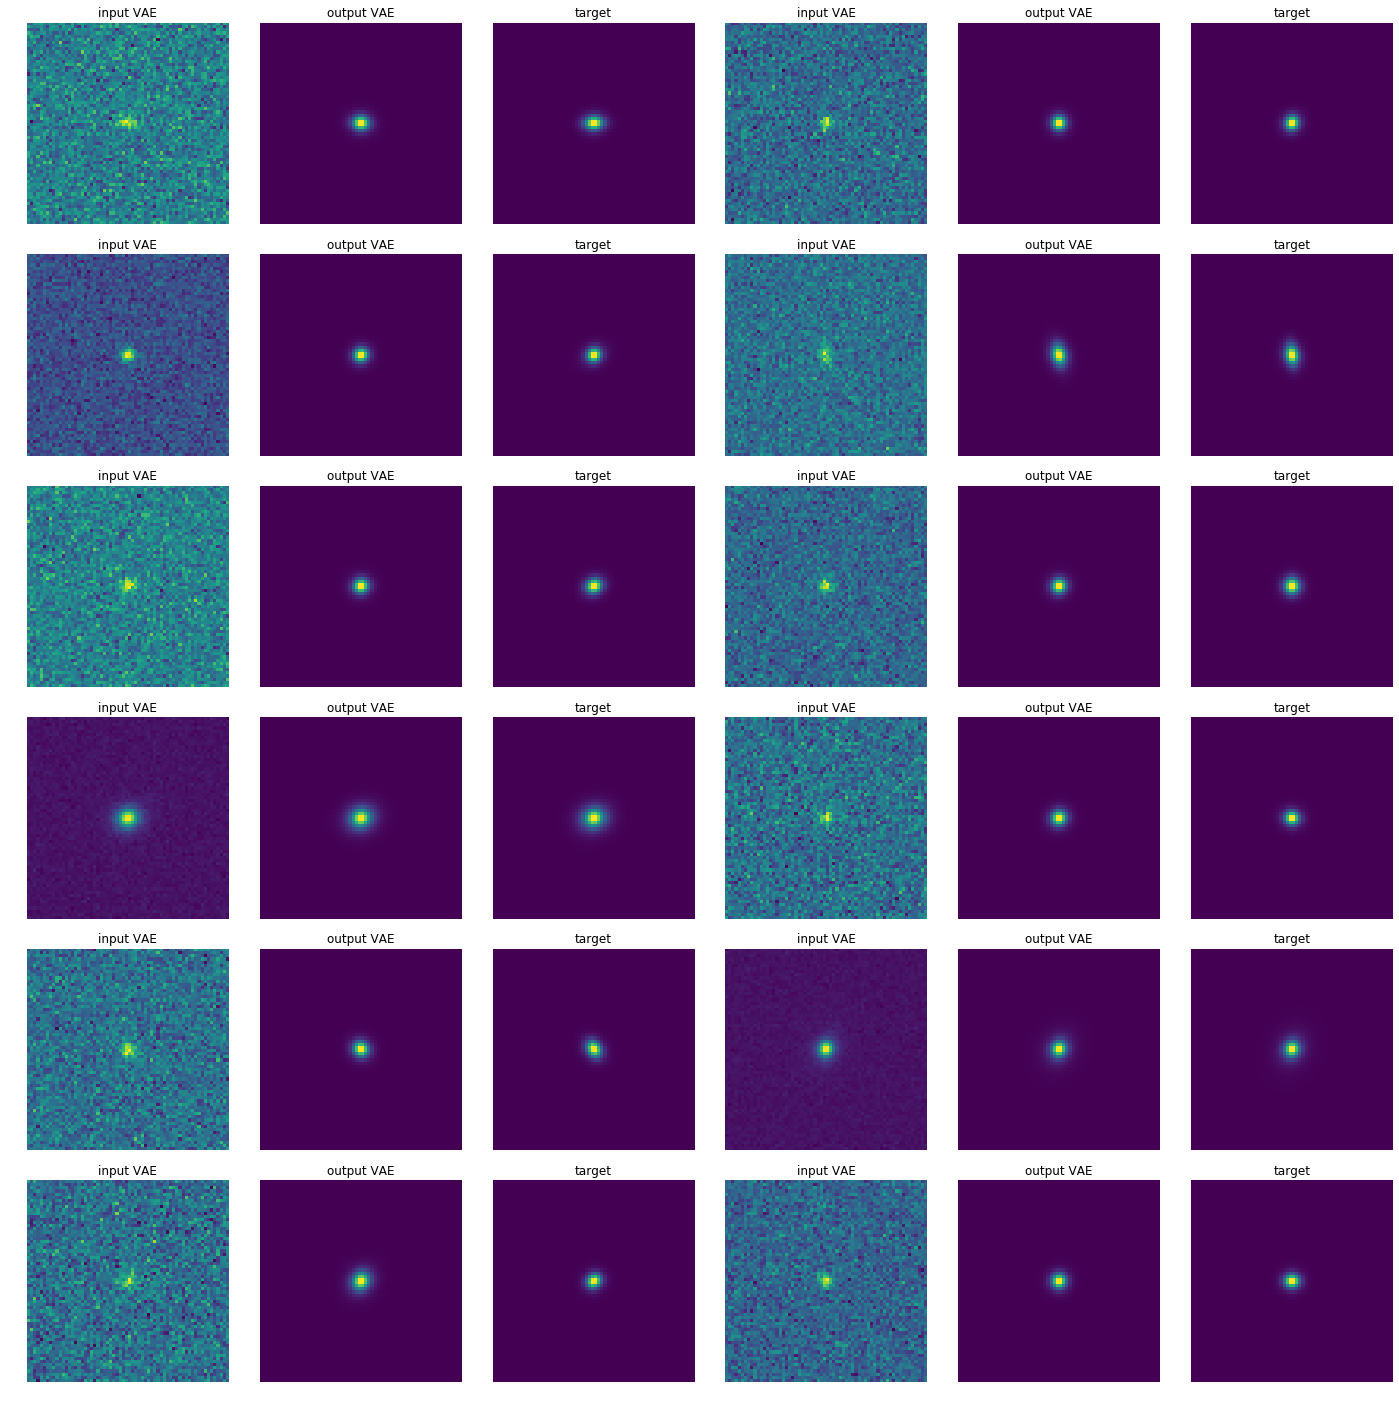

In [24]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_new.__getitem__(2)
output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_r, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_r, channel_last = True)
output_vae = denorm(output_vae, bands_r, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+1].imshow(output_vae[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]].reshape((64,64)))

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

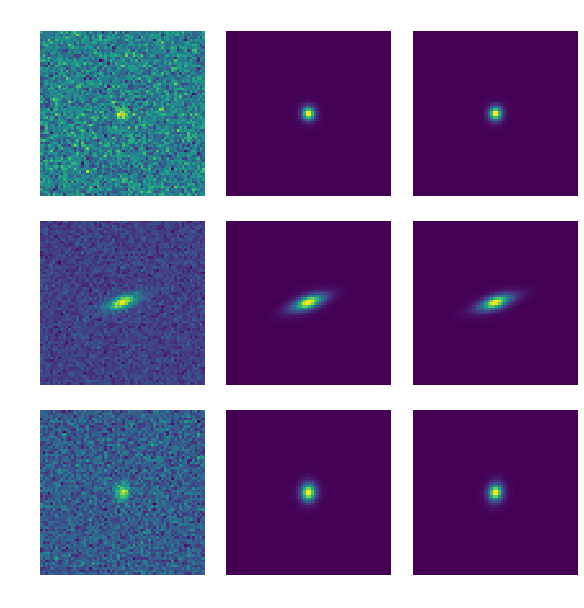

In [23]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


N_plot = 3
fig, axes = plt.subplots(3, N_plot, figsize=(10, 10))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_new.__getitem__(2)
output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = 100)
#print(np.max(output_vae, axis = (1,2)))
input_noisy = denorm(input_vae[0], bands_r, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_r, channel_last = True)
output_vae = denorm(output_vae, bands_r, channel_last = True)

for i in range(3):
    for j in range(0,N_plot,3):
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+1].imshow(output_vae[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]].reshape((64,64)))
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE', color = "w")
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE', color = "w")
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target', color = "w")

# Test plot for LSST all filters

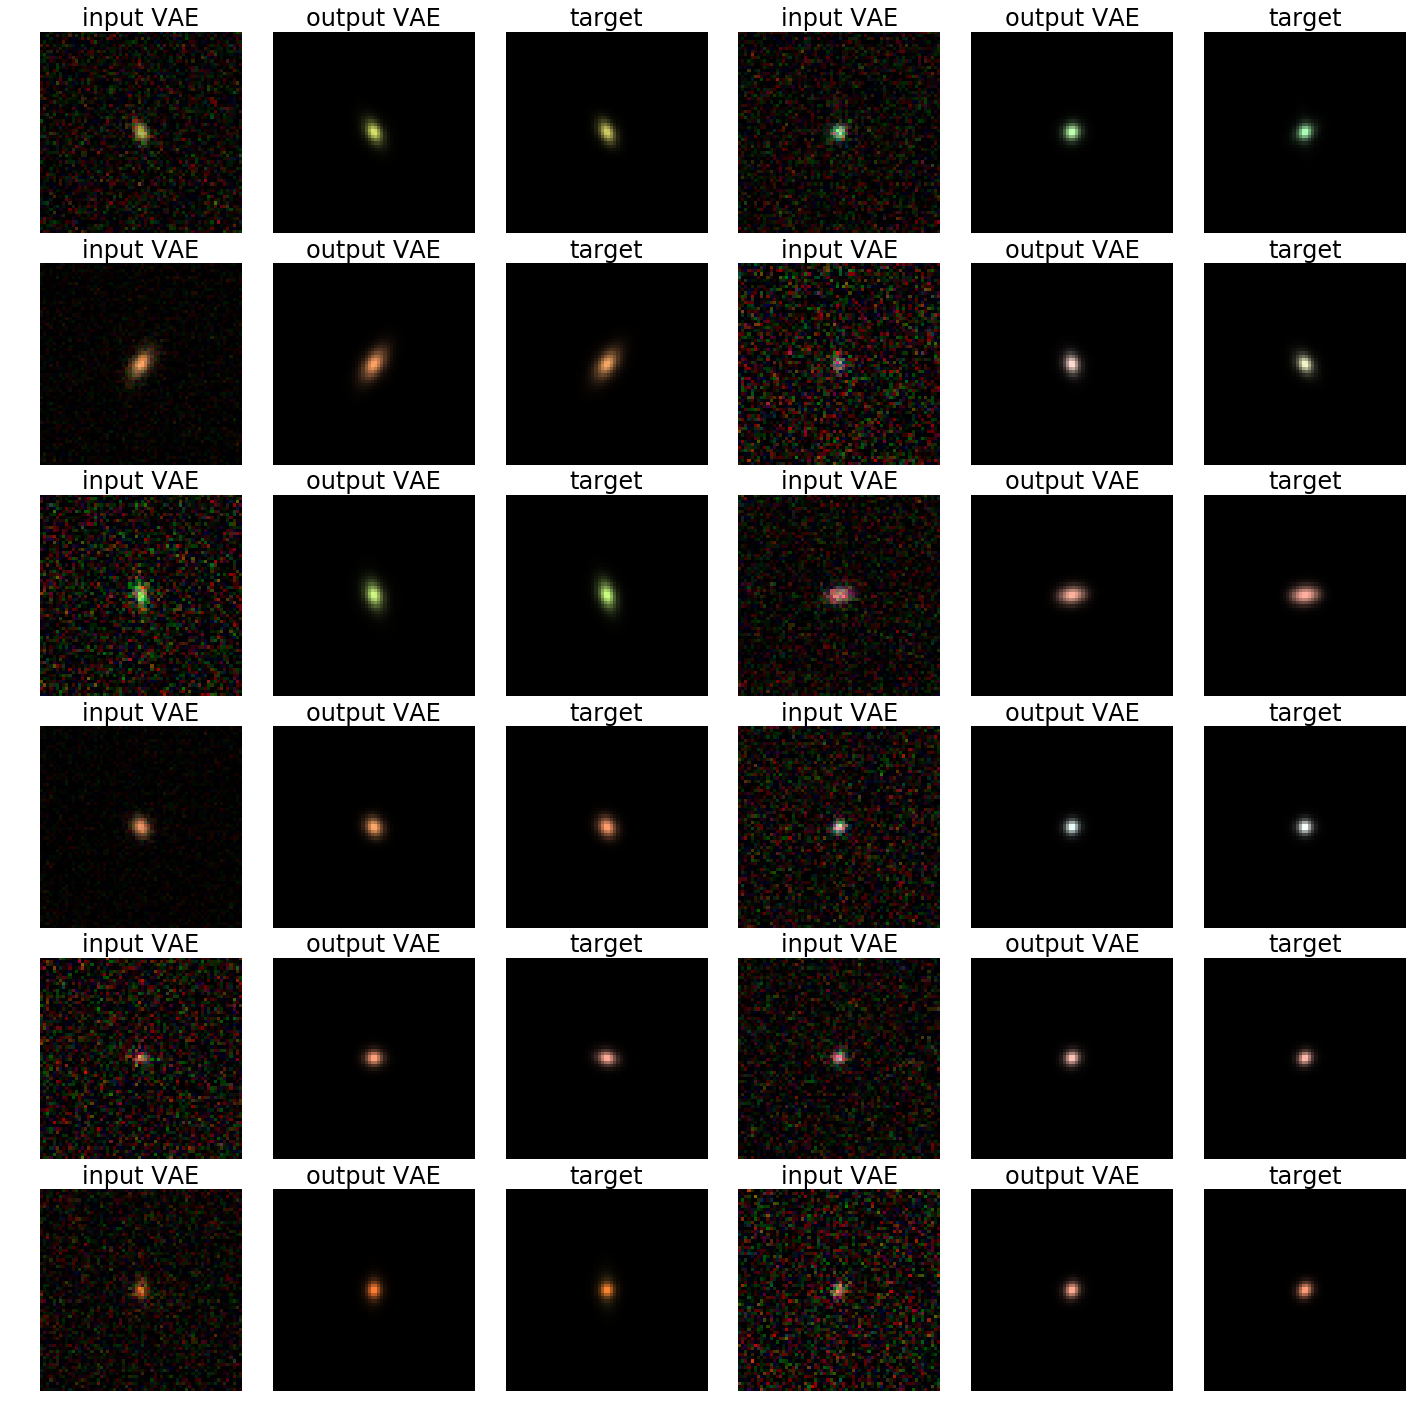

In [24]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst.__getitem__(2)
output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
output_vae = denorm(output_vae, bands_lsst, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

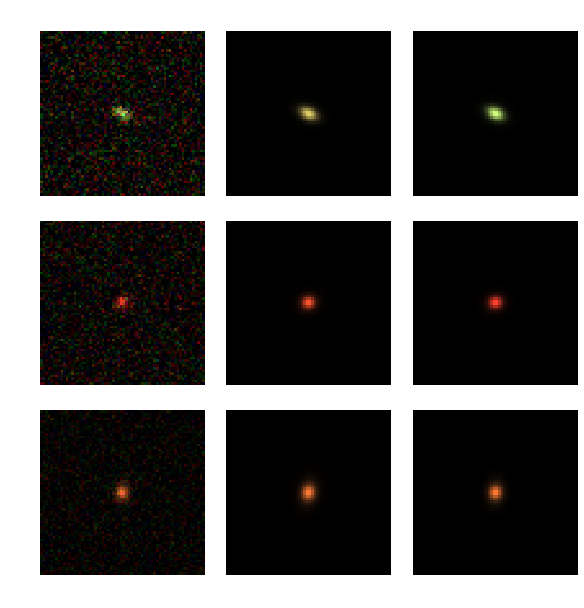

In [25]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

N_plot = 3
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst.__getitem__(2)
output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
output_vae = denorm(output_vae, bands_lsst, channel_last = True)

for i in range(3):
    for j in range(0,N_plot,3):
        
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE', color = "w")
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE', color = "w")
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target', color = "w")

# Test plot for LSST+Euclid filters

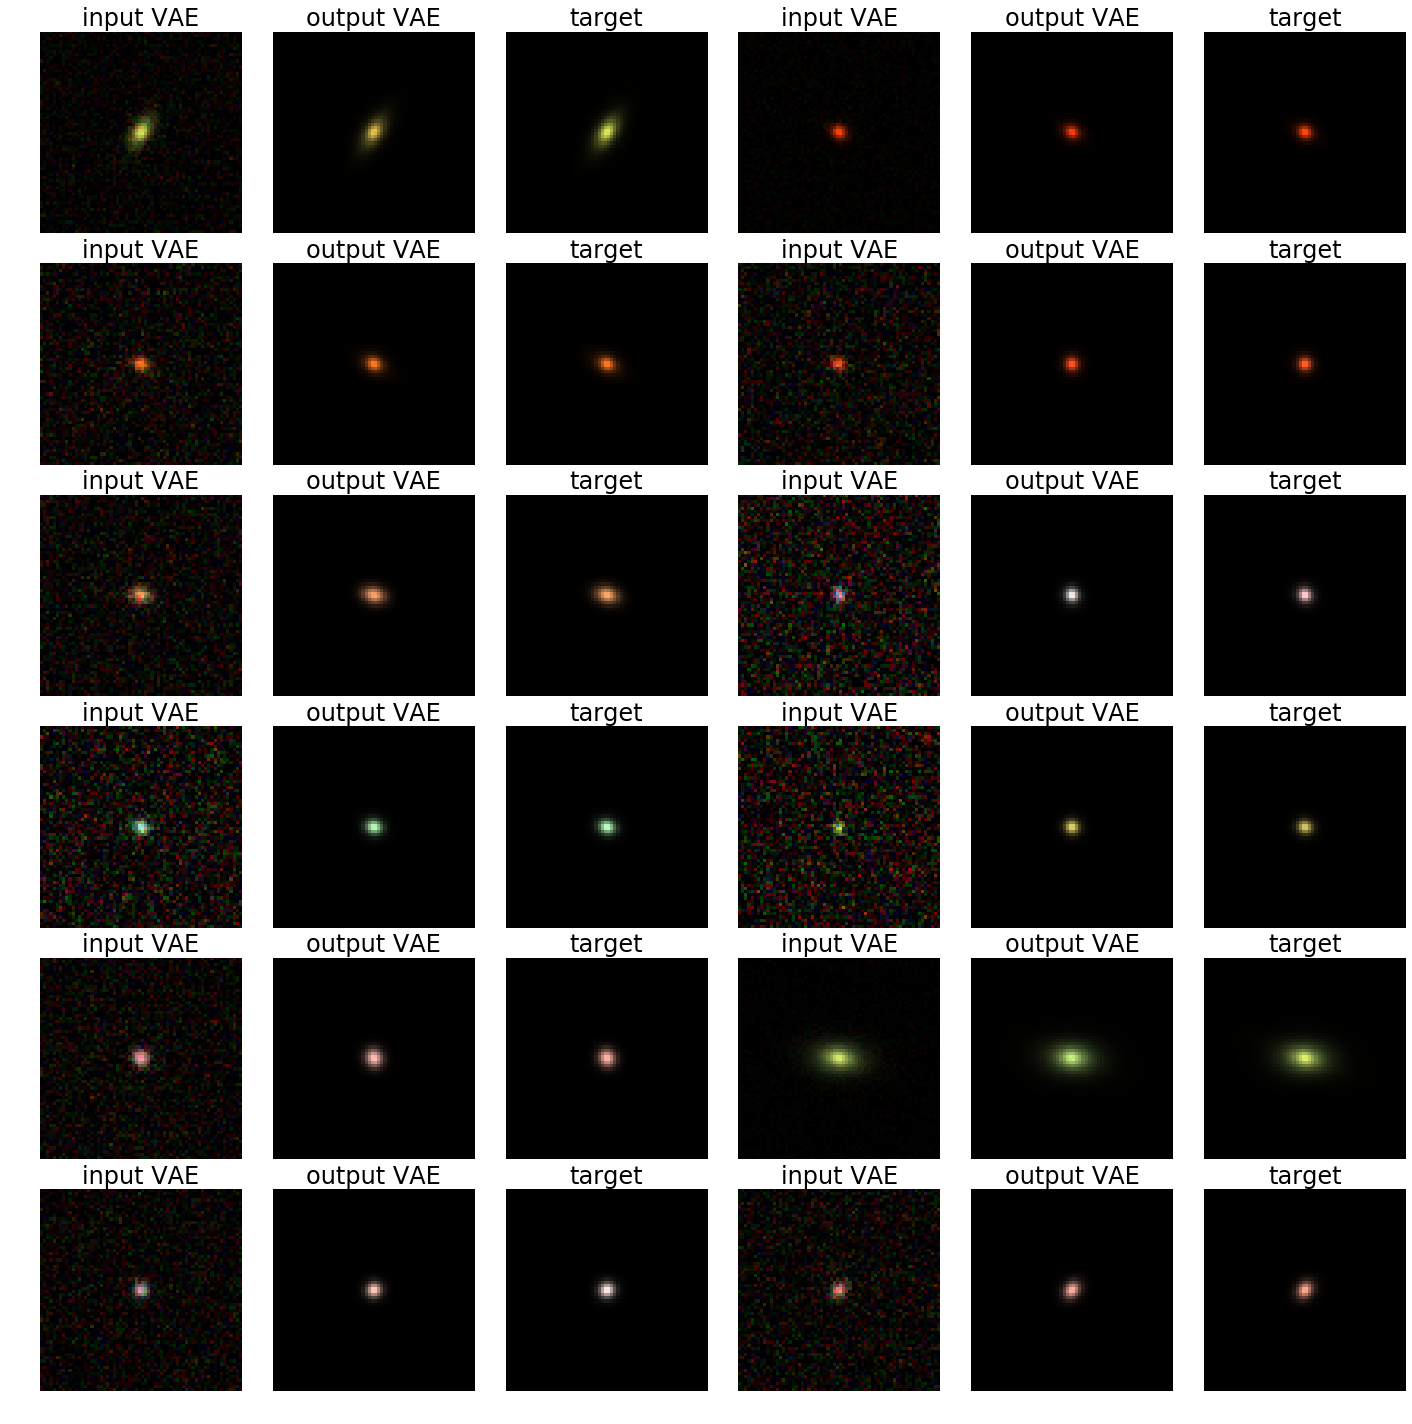

In [26]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst_euclid.__getitem__(2)
output_vae = vae_lsst_euclid_conv.predict(input_vae[0], batch_size = 100)


#input_noisy = input_vae[0]
#input_noiseless = input_vae[1]
input_noisy = denorm(input_vae[0], bands_lsst_euclid, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst_euclid, channel_last = True)
output_vae = denorm(output_vae, bands_lsst_euclid, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):

        plot_rgb_lsst_euclid(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst_euclid(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst_euclid(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

## VAE LSST R band

Test of data processing functions

In [ ]:
N = 100
batch_size = 100

ellipticities_r_band, e_beta_r, lum_in_simple_r, lum_out_simple_r, scale_radius_r, SNR_r = VAE_processing(vae_lsst_r_band_conv, batch_gen_new,bands_r,0,stamp_size, N, batch_size)

### Shape plots

Text(0, 0.5, 'e of output galaxy')

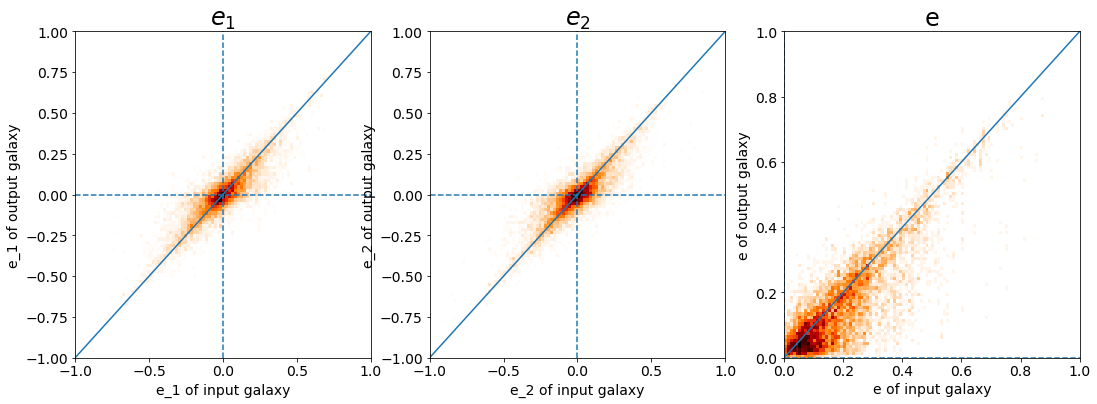

In [86]:
import matplotlib as mpl

fig, axes = plt.subplots(1,3, figsize=(18,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

_ = axes[2].hist2d(e_beta_r[:,0,0], e_beta_r[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('e'.format(i+1),fontsize=24)# color="w", 
axes[2].tick_params(axis='x')#, colors='w'
axes[2].tick_params(axis='y')#, colors='w'
axes[2].set_xlabel('e of input galaxy')
axes[2].set_ylabel('e of output galaxy')

Text(0, 0.5, 'e of output galaxy')

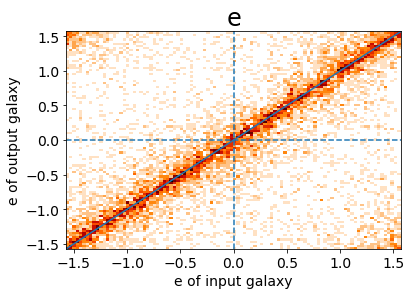

In [89]:
emax = np.pi/2
_ = plt.hist2d(e_beta_r[:,0,1], e_beta_r[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('e'.format(i+1),fontsize=24)# color="w", 
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('e of input galaxy')
plt.ylabel('e of output galaxy')

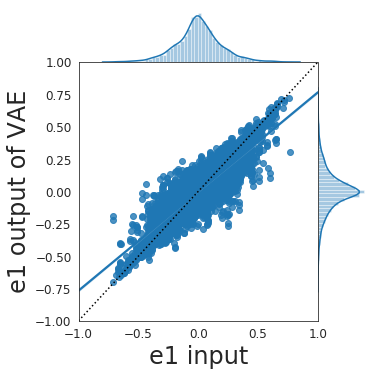

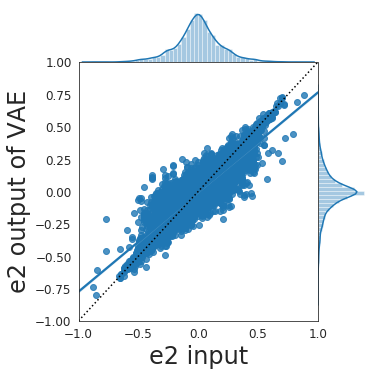

In [49]:
with sns.axes_style('white'):
            g1 = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g1.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g2 = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g2.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

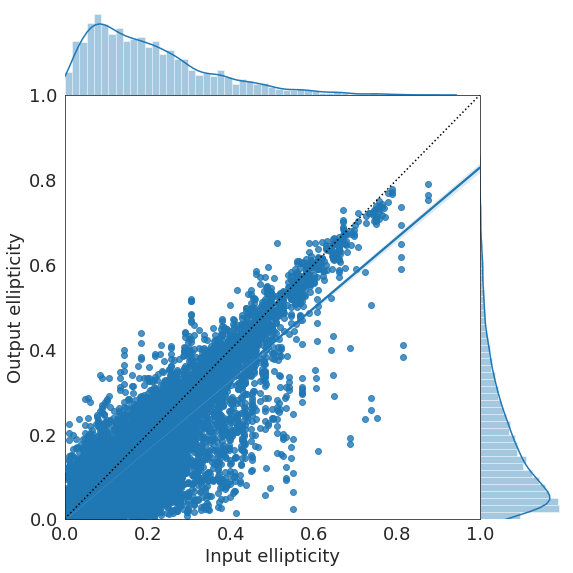

In [22]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
            g = sns.jointplot(e_beta_r[:,0,0], e_beta_r[:,1,0], kind='reg',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


In [23]:
# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(e_beta_r[:,0,0], e_beta_r[:,1,0])

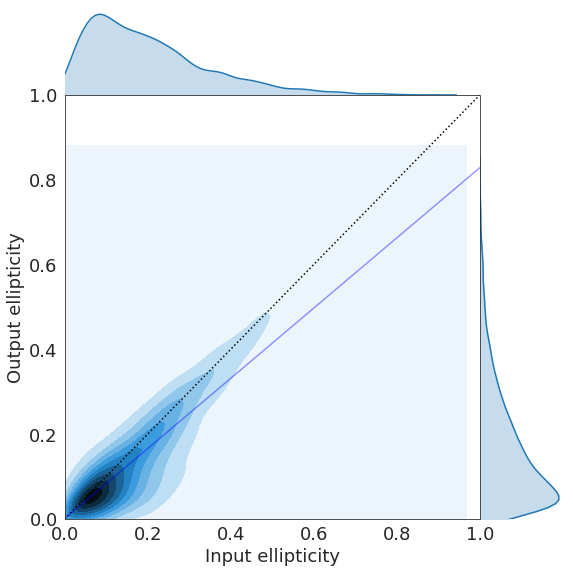

In [31]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
            g = sns.jointplot(e_beta_r[:,0,0], e_beta_r[:,1,0], kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope*np.linspace(0, 1)+intercept, color = 'b', alpha = 0.4)
            g.ax_joint.text(0, 0.95, '1 - slope = '+str(round(1-slope, 2)), fontsize =12, color='r')

(0, 200)

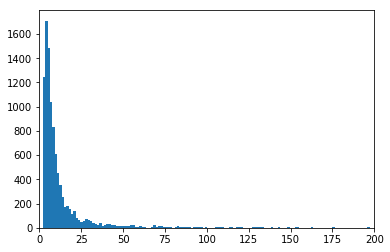

In [91]:
_ = plt.hist(SNR, bins = 1000)
plt.xlim(0,200)

In [93]:
weak_snr = np.where(SNR_r<9)

In [94]:
weak_snr[0].shape

(6234,)

In [95]:
weak_snr[0]

array([   1,    3,    4, ..., 9996, 9998, 9999])

In [96]:
ellipticities_r_band.shape

(10000, 2, 2)

In [97]:
ellipticities_r_band_mod = np.delete(ellipticities_r_band[:], weak_snr[0], axis = 0)

In [98]:
ellipticities_r_band_mod.shape

(3766, 2, 2)

In [99]:
e_beta_r_mod = np.delete(e_beta_r, weak_snr[0], axis = 0)

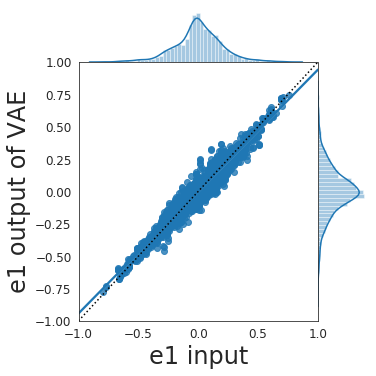

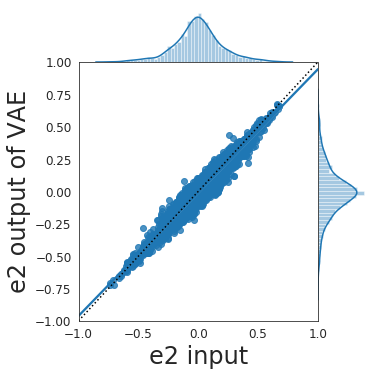

In [100]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band_mod[:,0,0], ellipticities_r_band_mod[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band_mod[:,0,1], ellipticities_r_band_mod[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

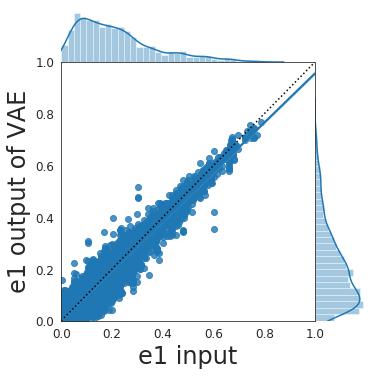

In [104]:
with sns.axes_style('white'):
            g = sns.jointplot(e_beta_r_mod[:,0,0], e_beta_r_mod[:,1,0], kind='reg',height =5,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


In [107]:
delta_e = e_beta_r[:,0,0]- e_beta_r[:,1,0]

In [108]:
len(delta_e), len(scale_radius), len(SNR)

(10000, 10000, 10000)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


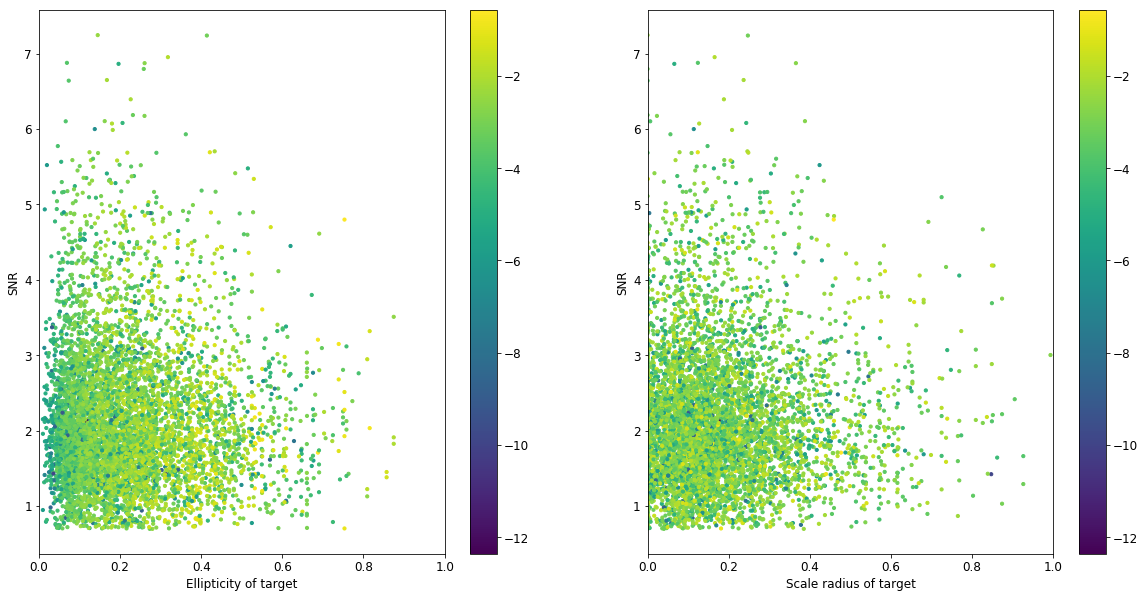

In [110]:
import matplotlib as mpl
fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].scatter(e_beta_r[:,0,0], np.log(SNR),  c = np.log(delta_e), s=10)#, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
axes[0].set_xlabel("Ellipticity of target")
axes[0].set_ylabel("SNR")#delta r to closest (arcsecond)/scale radius of centered
#plt.xscale('log')
axes[0].set_xlim(0,1)
fig.colorbar(im, ax=axes[0])

im = axes[1].scatter(scale_radius, np.log(SNR),  c = np.log(delta_e), s=10)#, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
axes[1].set_xlabel("Scale radius of target")
axes[1].set_ylabel("SNR")#delta r to closest (arcsecond)/scale radius of centered
#plt.xscale('log')
axes[1].set_xlim(0,1)
fig.colorbar(im, ax=axes[1])

In [111]:
np.mean(delta_e)

0.03512378047426242

### Luminosity plots

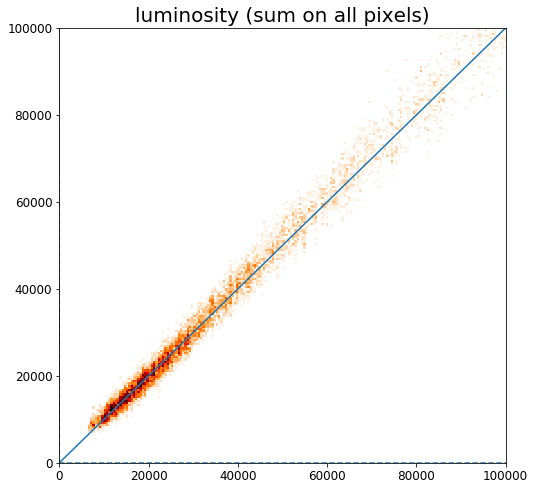

In [113]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple_r, lum_out_simple_r, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

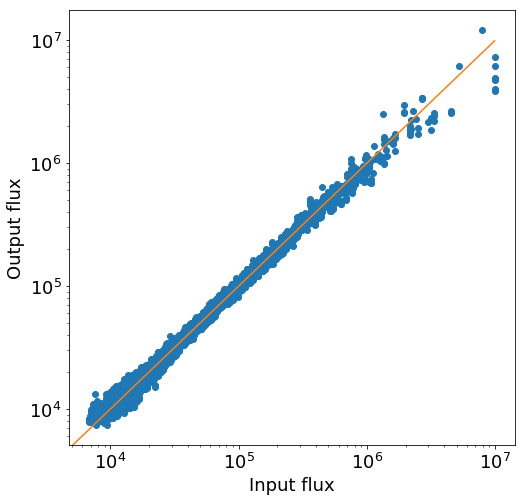

In [40]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = np.max(lum_in_simple_r)
axes.plot(lum_in_simple_r, lum_out_simple_r,'o')

axes.plot([-emax,+emax],[-emax,+emax])
#axes.axhline(y=0, ls='--')
#axes.axvline(x=0, ls='--')
#axes.set_title('luminosity (sum on all pixels)')#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlabel('Input flux')
axes.set_ylabel('Output flux')
axes.set_xscale('log')
axes.set_yscale('log')

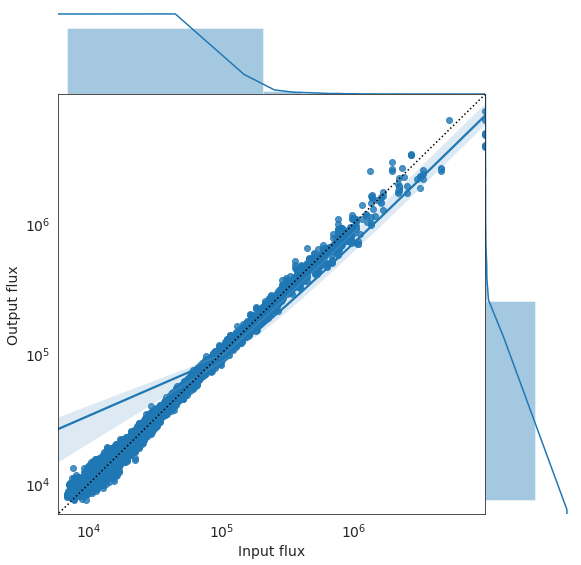

In [41]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
            g = sns.jointplot(lum_in_simple_r, lum_out_simple_r, kind='reg',height =8,
                              xlim =[np.min(lum_in_simple_r)-1000, np.max(lum_in_simple_r)], ylim=[np.min(lum_in_simple_r)-1000, np.max(lum_in_simple_r)],space=0).set_axis_labels('Input flux', 'Output flux')
            g.ax_joint.set_xscale('log')
            g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(lum_in_simple_r)),
                            np.linspace(-1, np.max(lum_in_simple_r)), ':k')

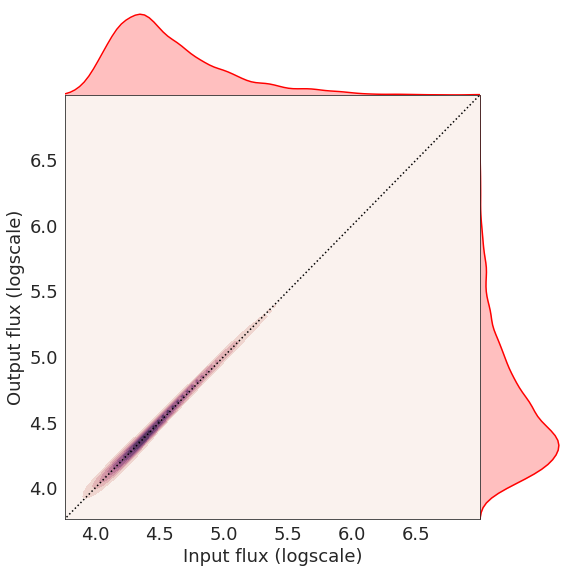

In [78]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(np.log10(lum_in_simple_r), np.log10(lum_out_simple_r), kind='kde',height =8,
                              xlim =[np.min(np.log10(lum_in_simple_r-1000)), np.max(np.log10(lum_in_simple_r))], ylim=[np.min(np.log10(lum_in_simple_r-1000)), np.max(np.log10(lum_in_simple_r))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(lum_in_simple_r))),
                            np.linspace(-1, np.max(np.log10(lum_in_simple_r))), ':k')

### Delta_e1 / Delta_e2

In [116]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

(-0.4, 0.4)

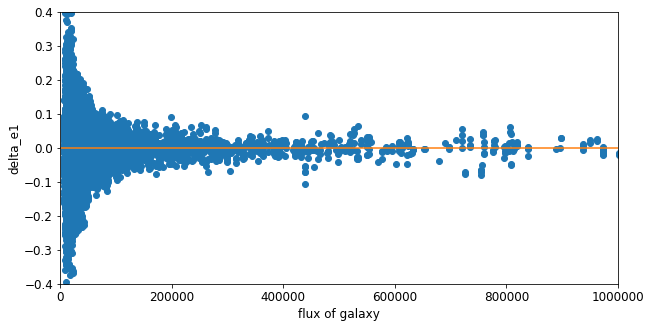

In [117]:
fig = plt.subplots(1,1, figsize=(10,5))
plt.plot(lum_in_simple_r[:len(delta_e1)], delta_e1, 'o')
plt.xlim(0,1000000)
plt.xlabel('flux of galaxy')
plt.ylabel('delta_e1')
plt.plot([0,1000000],[0,0])
plt.ylim(-0.4,0.4)

(-0.4, 0.4)

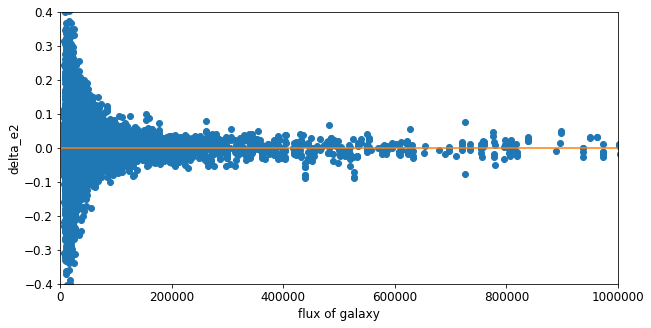

In [118]:
fig = plt.subplots(1,1, figsize=(10,5))
plt.plot(lum_in_simple_r[:len(delta_e2)], delta_e2, 'o')
plt.xlim(0,1000000)
plt.xlabel('flux of galaxy')
plt.ylabel('delta_e2')
plt.plot([0,1000000],[0,0])
plt.ylim(-0.4,0.4)

### Corner plot latent space

In [93]:
batch_size = 100

In [94]:
a = batch_gen_new.__getitem__(2)
output_enc = encoder_R.predict(a[0], batch_size = batch_size)

In [95]:
latent_dim =32
epsilon_std = 1.0

In [96]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

In [97]:
z = []
for i in range (100):
    a = batch_gen_new.__getitem__(2)
    output_enc = encoder_R.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))


In [98]:
z = np.concatenate(z, axis = 0)

In [99]:
len(z)

10000

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


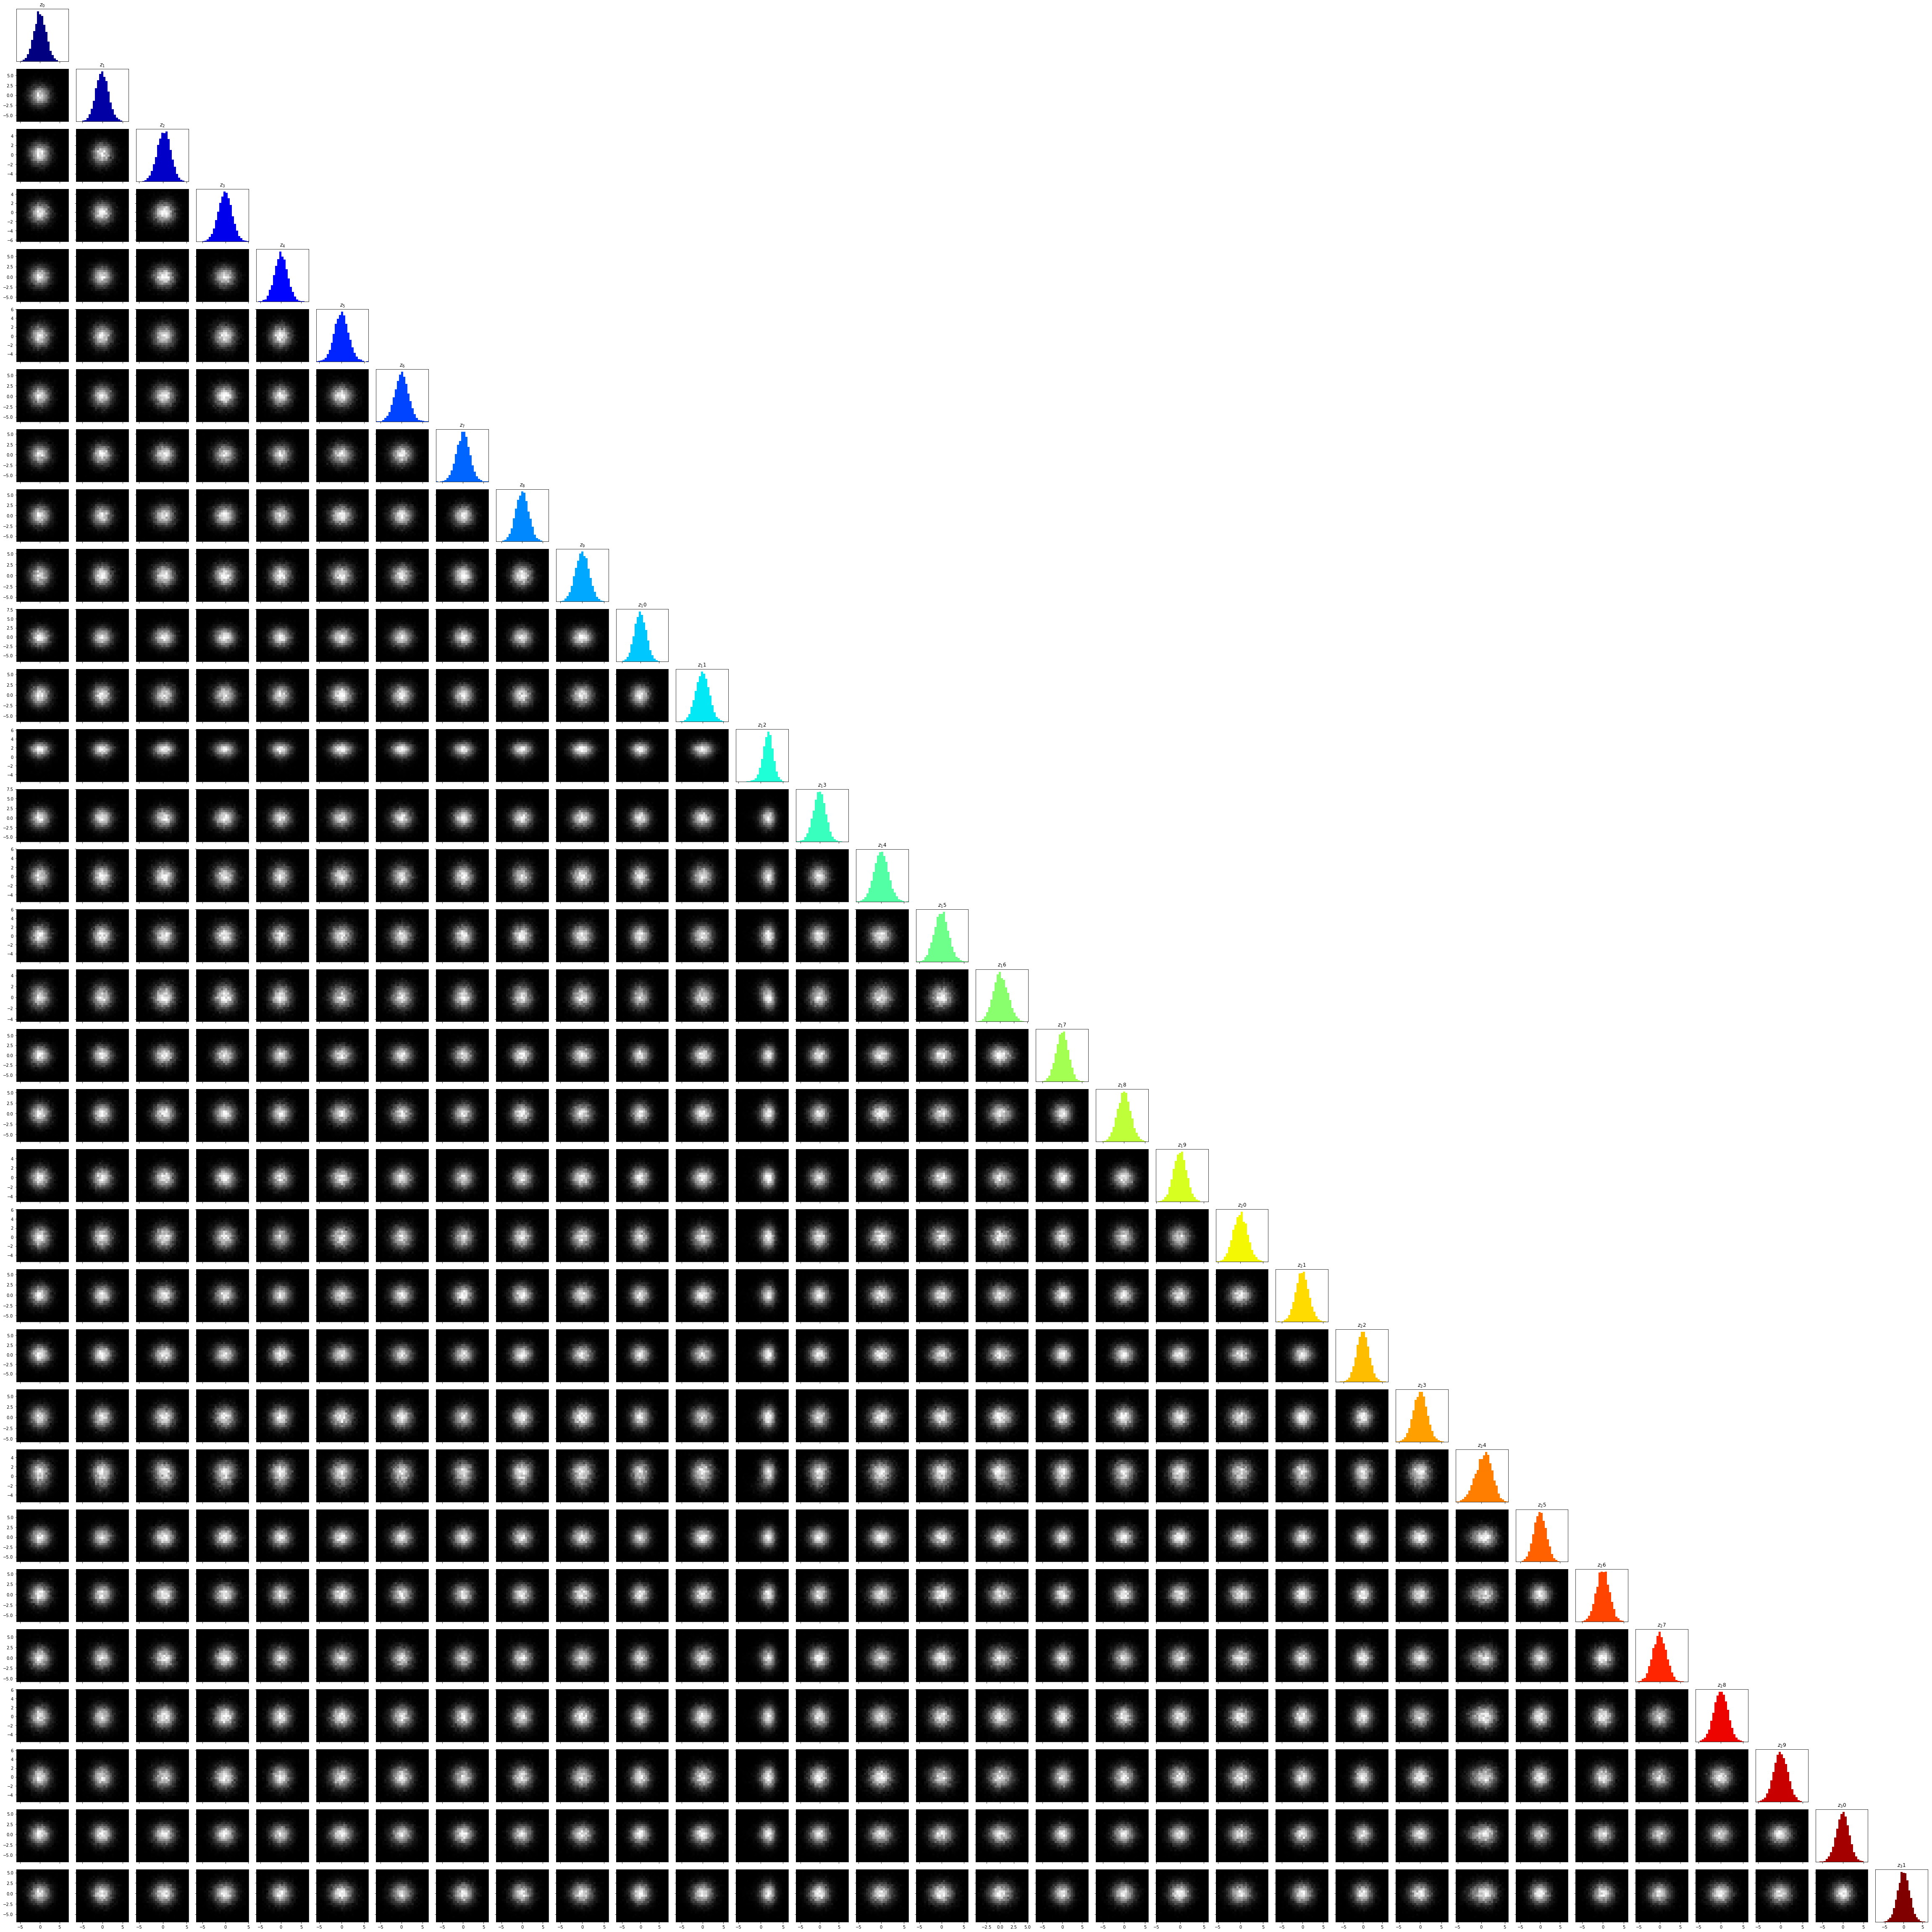

In [100]:
plot_corner_latent(z)

Load decoder to see generative model

In [99]:
from tools_for_VAE.utils import load_vae_decoder

In [100]:
from tools_for_VAE.utils import load_vae_decoder
decoder_r = load_vae_decoder('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v21/bis_bis/mse/',1, folder = True)

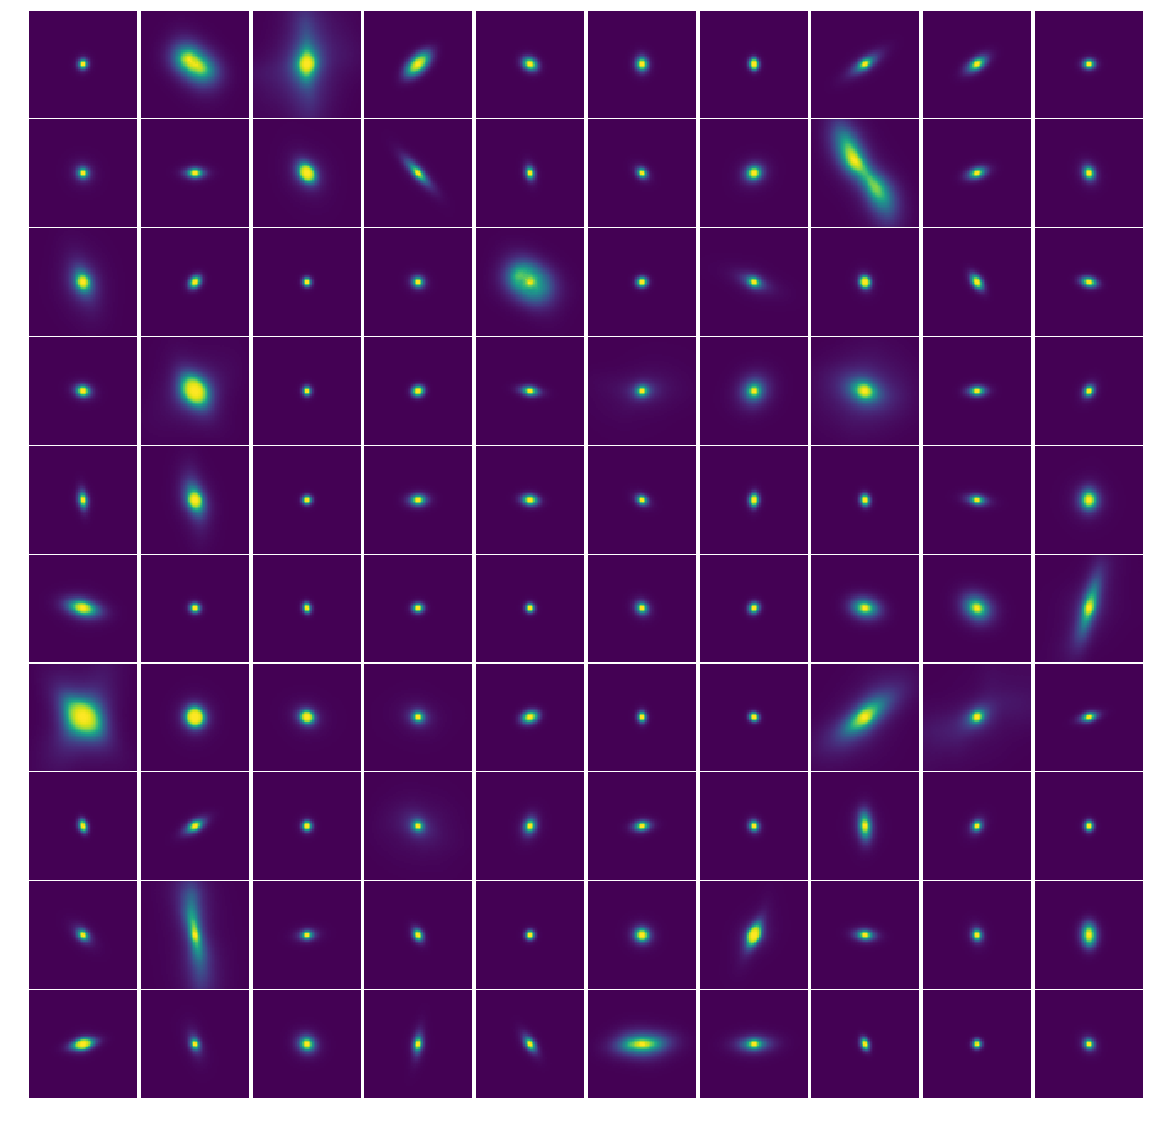

In [103]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(N_plot):
        
        # random sampling in normal distribution to create the latent variable
        xx1 = np.random.normal(size=32)
        z_sample1 = np.array([xx1])

        # use the generator/decoder trained to create 2 images of one galaxy
        x_decoded_1 = decoder_r.predict(z_sample1)
        gal_1 = x_decoded_1[0].reshape(64, 64)    

        axes[i,j].imshow(gal_1.reshape(64,64))#
        axes[i,j].axis('off')

## LSST all filters

In [32]:
N = 100
batch_size = 100

ellipticities_LSST, e_beta_LSST, lum_in_simple_lsst, lum_out_simple_lsst, scale_radius, SNR_lsst = VAE_processing(vae_lsst_conv, batch_gen_lsst,bands_lsst,2,stamp_size, N, batch_size)

### Shape plots

Text(0, 0.5, 'e of output galaxy')

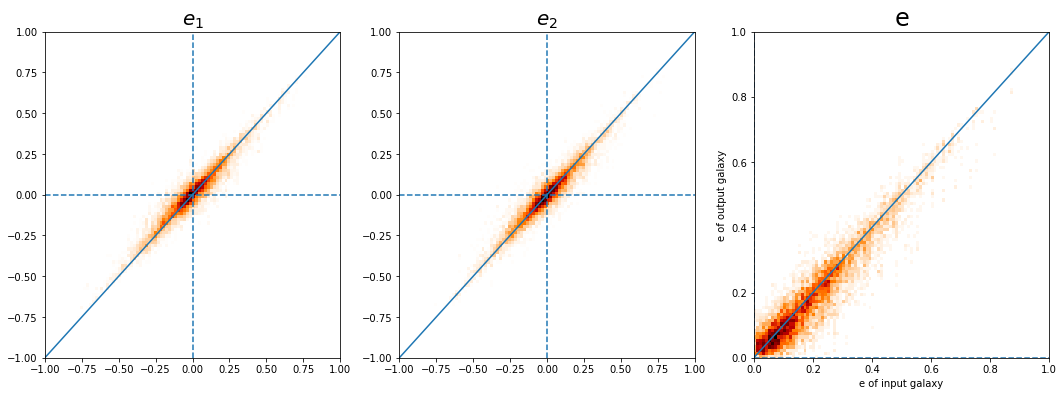

In [21]:
import matplotlib as mpl

fig, axes = plt.subplots(1,3, figsize=(18,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_LSST[:,0,i], ellipticities_LSST[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), fontsize=20)
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')
    axes[i].tick_params(axis='y')
    
_ = axes[2].hist2d(e_beta_LSST[:,0,0], e_beta_LSST[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
axes[2].tick_params(axis='x')#, colors='w'
axes[2].tick_params(axis='y')#, colors='w'
axes[2].set_xlabel('e of input galaxy')
axes[2].set_ylabel('e of output galaxy')

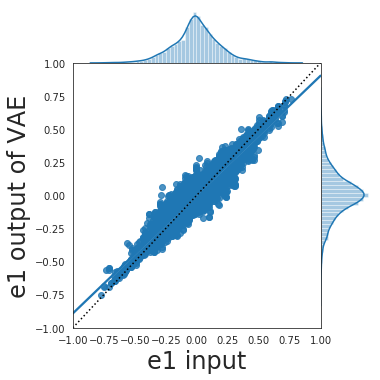

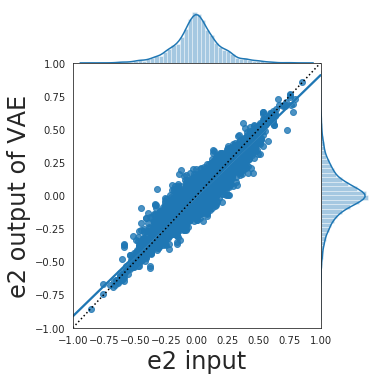

In [22]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_LSST[:,0,0], ellipticities_LSST[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_LSST[:,0,1], ellipticities_LSST[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

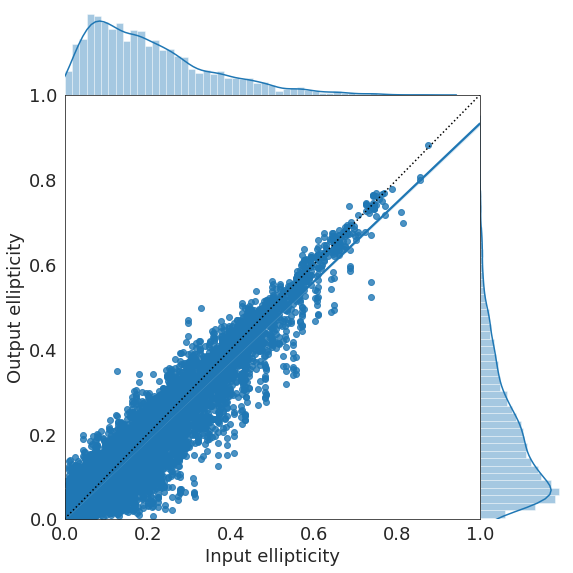

In [78]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}


with sns.axes_style('white'):
            g = sns.jointplot(e_beta_LSST[:,0,0], e_beta_LSST[:,1,0], kind='reg',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


In [33]:
# Linear regression
slope_lsst, intercept_lsst, r_value_lsst, p_value_lsst, std_err_lsst = stats.linregress(e_beta_LSST[:,0,0], e_beta_LSST[:,1,0])

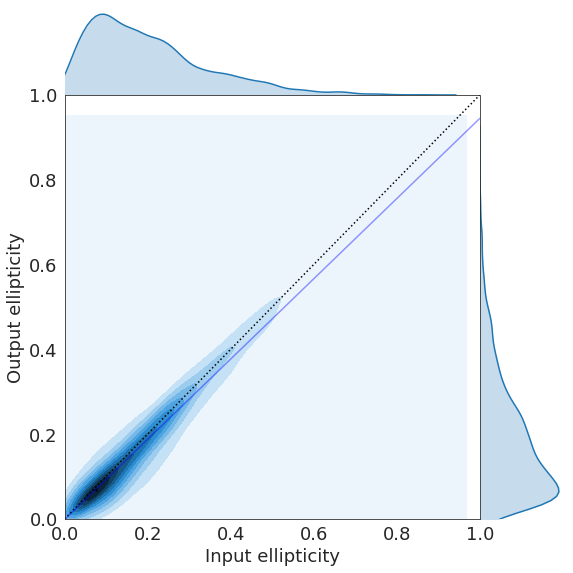

In [34]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(e_beta_LSST[:,0,0], e_beta_LSST[:,1,0], kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst*np.linspace(0, 1)+intercept_lsst,color = 'b', alpha = 0.4)
            

In [24]:
weak_snr_lsst = np.where(SNR_lsst<9)
ellipticities_LSST_mod = np.delete(ellipticities_LSST[:], weak_snr_lsst[0], axis = 0)
e_beta_LSST_mod = np.delete(e_beta_LSST[:], weak_snr_lsst[0], axis = 0)

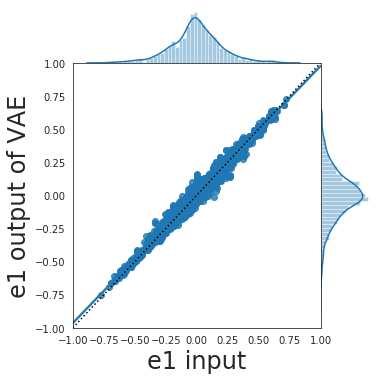

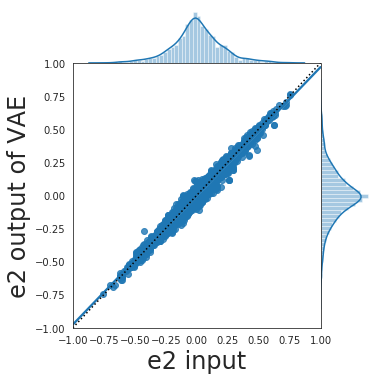

In [25]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_LSST_mod[:,0,0], ellipticities_LSST_mod[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_LSST_mod[:,0,1], ellipticities_LSST_mod[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

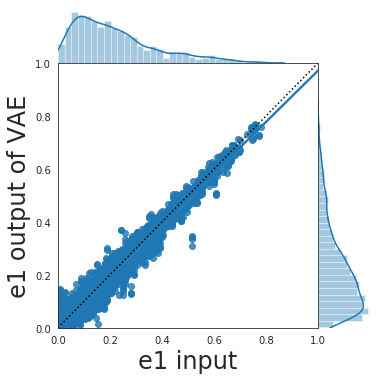

In [26]:
with sns.axes_style('white'):
            g = sns.jointplot(e_beta_LSST_mod[:,0,0], e_beta_LSST_mod[:,1,0], kind='reg',height =5,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


Text(0, 0.5, 'beta of output galaxy')

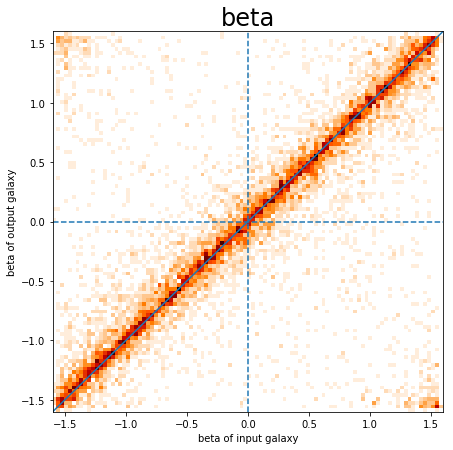

In [27]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1.6
_ = plt.hist2d(e_beta_LSST[:,0,1], e_beta_LSST[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('beta'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('beta of input galaxy')
plt.ylabel('beta of output galaxy')

### Luminosity plot

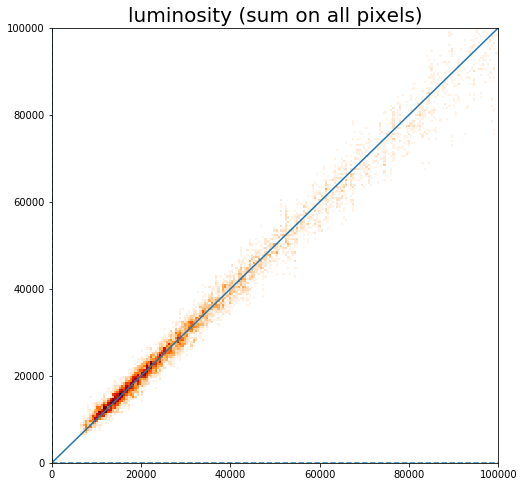

In [28]:
import matplotlib as mpl

fig, axes= plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple_lsst, lum_out_simple_lsst, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

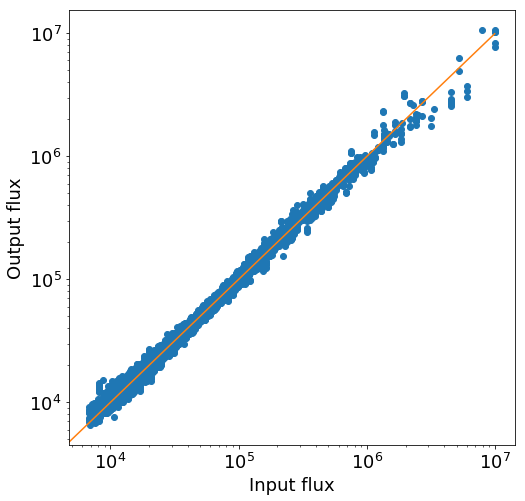

In [82]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = np.max(lum_in_simple_lsst)
axes.plot(lum_in_simple_lsst, lum_out_simple_lsst,'o')

axes.plot([-emax,+emax],[-emax,+emax])
#axes.axhline(y=0, ls='--')
#axes.axvline(x=0, ls='--')
#axes.set_title('luminosity (sum on all pixels)')#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlabel('Input flux')
axes.set_ylabel('Output flux')
axes.set_xscale('log')
axes.set_yscale('log')

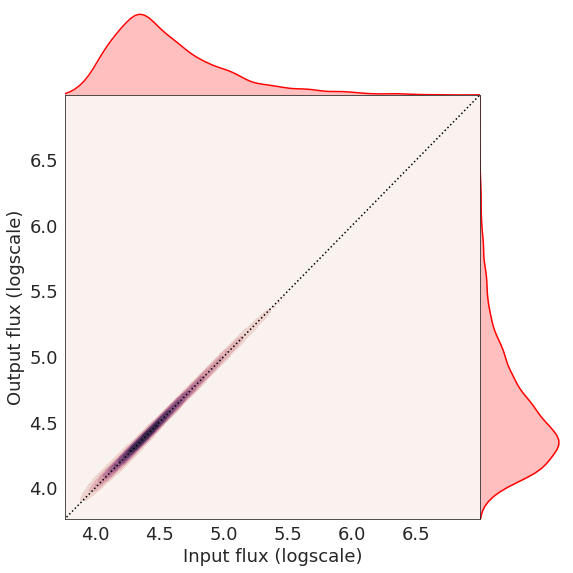

In [79]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(np.log10(lum_in_simple_lsst), np.log10(lum_out_simple_lsst), kind='kde',height =8,
                              xlim =[np.min(np.log10(lum_in_simple_lsst-1000)), np.max(np.log10(lum_in_simple_lsst))], ylim=[np.min(np.log10(lum_in_simple_lsst-1000)), np.max(np.log10(lum_in_simple_lsst))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(lum_in_simple_lsst))),
                            np.linspace(-1, np.max(np.log10(lum_in_simple_lsst))), ':k')

### Corner plot latent space

In [164]:
batch_size = 100
a = batch_gen_lsst.__getitem__(2)
output_enc = encoder_LSST.predict(a[0], batch_size = batch_size)
latent_dim =32
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

z = []

In [165]:
for i in range (100):
    a = batch_gen_lsst.__getitem__(2)
    output_enc = encoder_LSST.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))


z = np.concatenate(z, axis = 0)

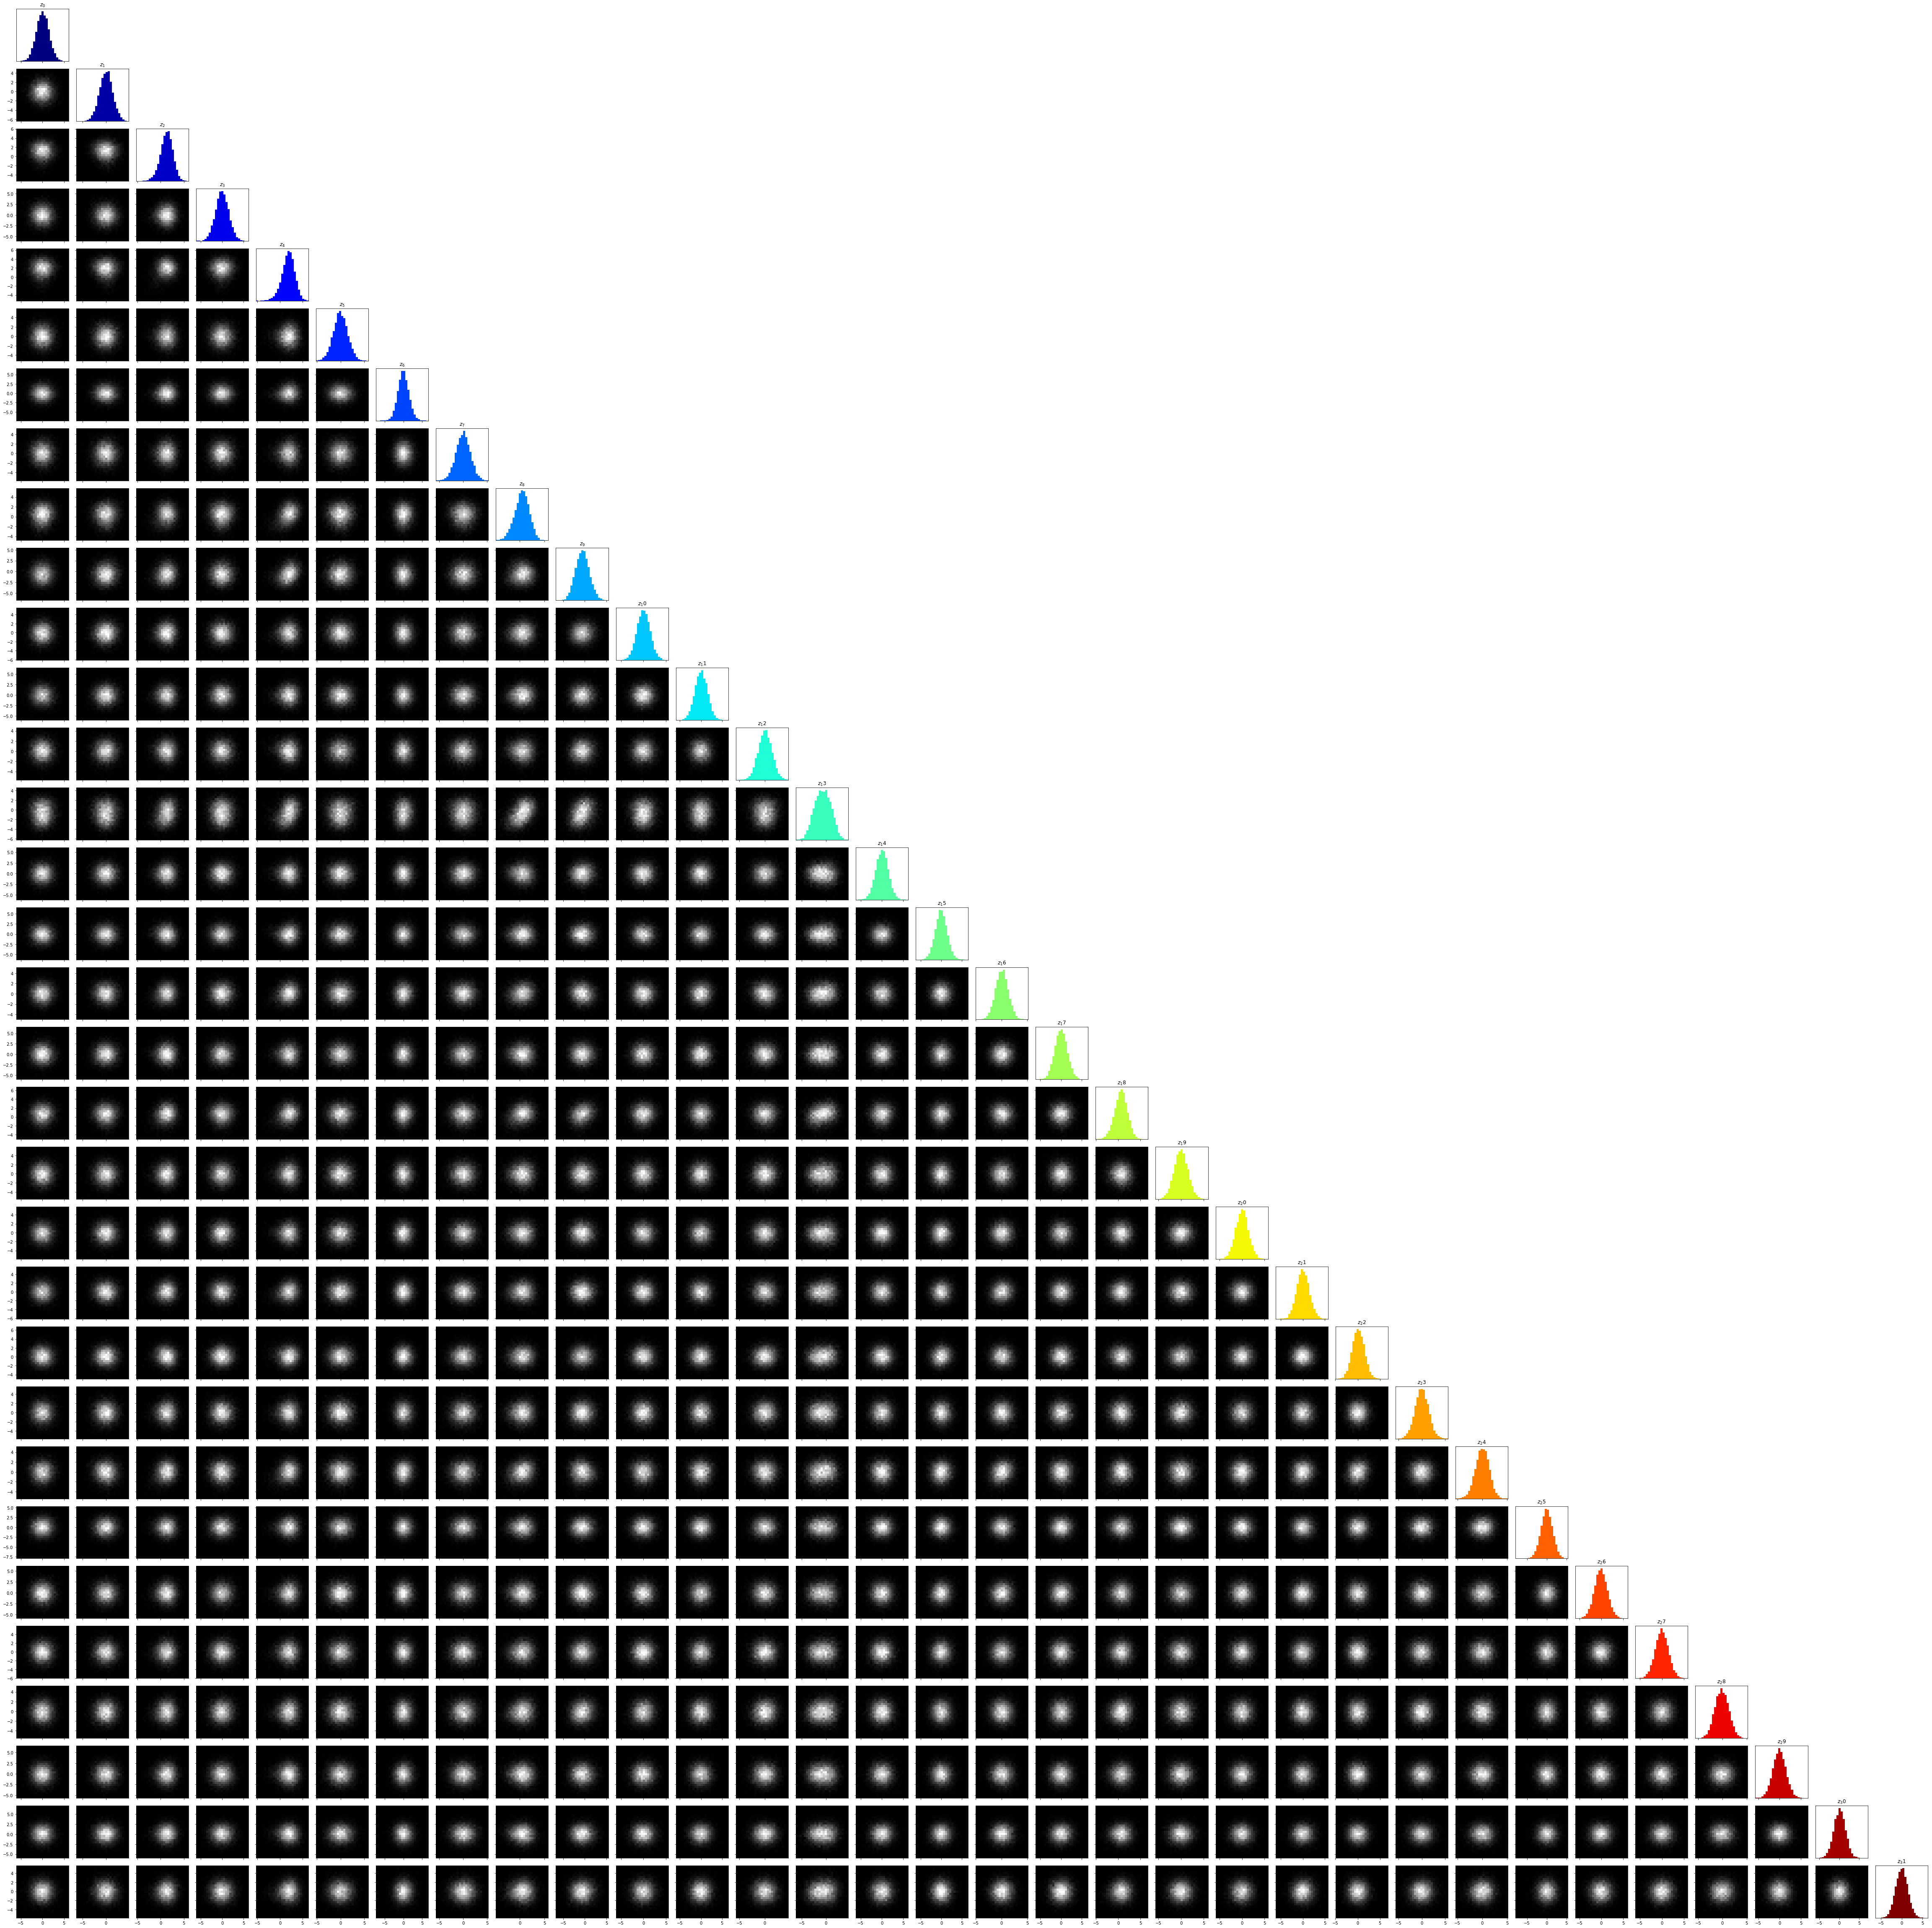

In [166]:
plot_corner_latent(z)

Test to load decoder for generation of galaxies

In [104]:
from tools_for_VAE.utils import load_vae_decoder
decoder_r = load_vae_decoder('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v12/',6, folder= True)

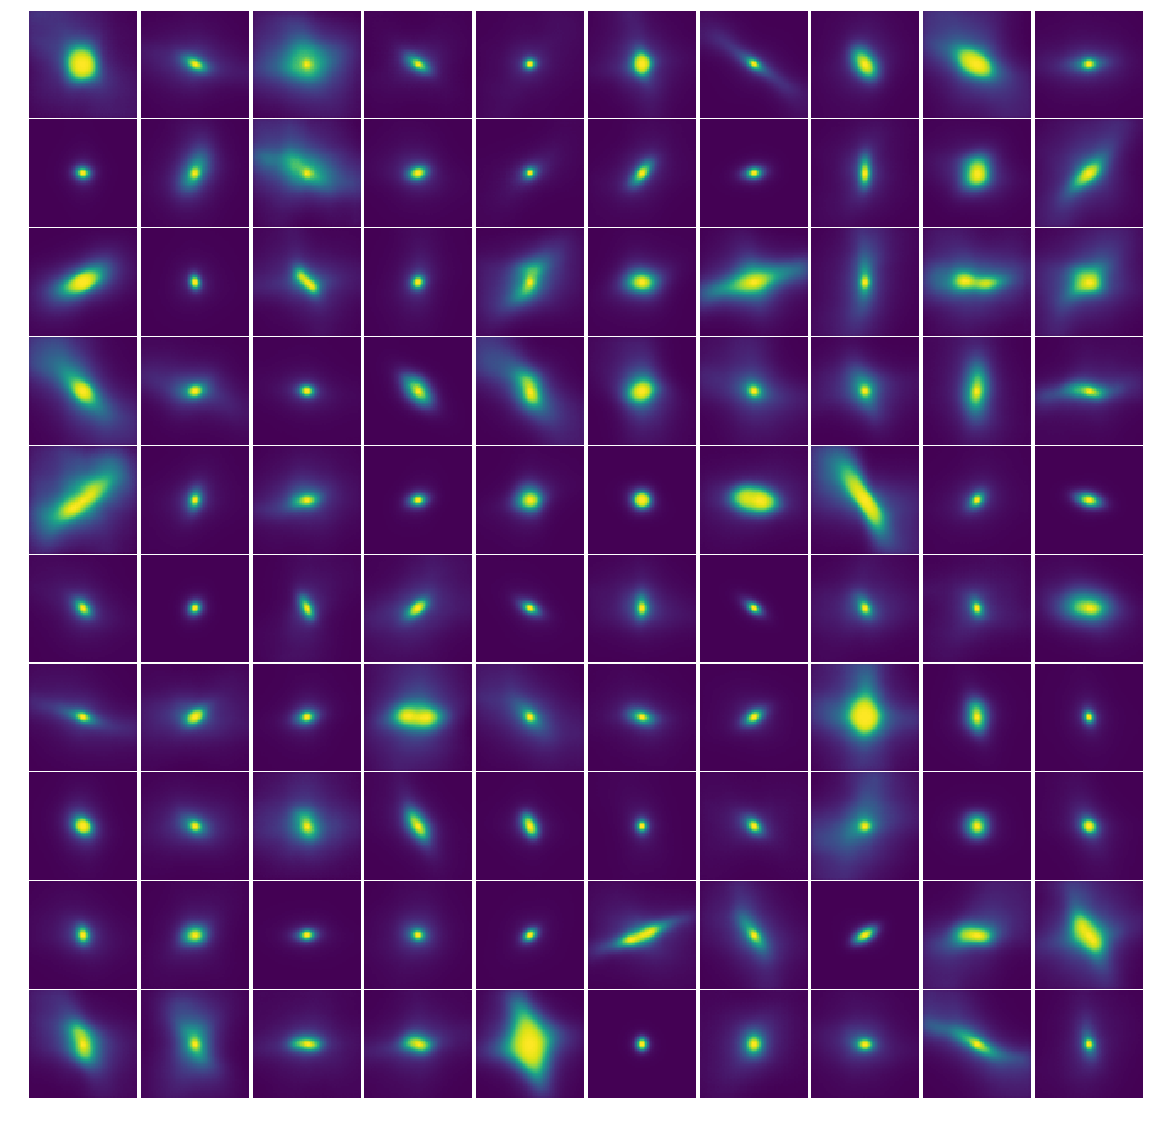

In [105]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(N_plot):
        
        # random sampling in normal distribution to create the latent variable
        xx1 = np.random.normal(size=32)
        z_sample1 = np.array([xx1])

        # use the generator/decoder trained to create 2 images of one galaxy
        x_decoded_1 = decoder_r.predict(z_sample1)
        gal_1 = x_decoded_1[0].reshape(64, 64,6)    

        axes[i,j].imshow(gal_1[:,:,2])#
        axes[i,j].axis('off')

## LSST + Euclid all filters

Test VAE_processing for LSST and Euclid all band-pass filters

In [35]:
N = 100
batch_size = 100

ellipticities_LSST_euclid, e_beta_LSST_euclid, lum_in_simple_lsst_euclid, lum_out_simple_lsst_euclid, scale_radius, SNR_lsst_euclid = VAE_processing(vae_lsst_euclid_conv, batch_gen_lsst_euclid,bands_lsst_euclid,6,stamp_size, N, batch_size)

### Shape plots

Text(0, 0.5, 'e of output galaxy')

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


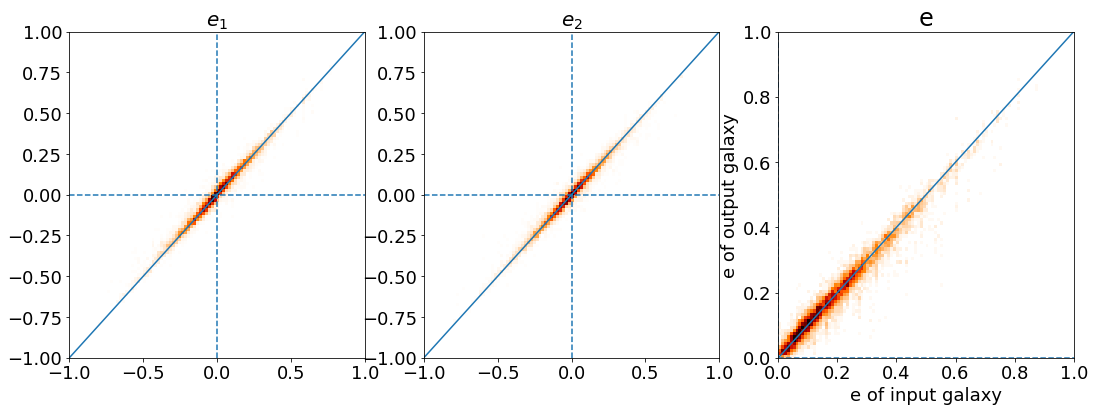

In [38]:
import matplotlib as mpl

fig, axes = plt.subplots(1,3, figsize=(18,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_LSST_euclid[:,0,i], ellipticities_LSST_euclid[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), fontsize=20)#, color="w"
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w')
    axes[i].tick_params(axis='y')#, colors='w')
    

_ = axes[2].hist2d(e_beta_LSST_euclid[:,0,0], e_beta_LSST_euclid[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('e'.format(i+1),fontsize=24)# color="w", 
axes[2].tick_params(axis='x')#, colors='w'
axes[2].tick_params(axis='y')#, colors='w'
axes[2].set_xlabel('e of input galaxy')
axes[2].set_ylabel('e of output galaxy')

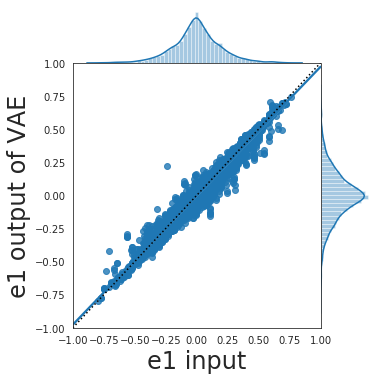

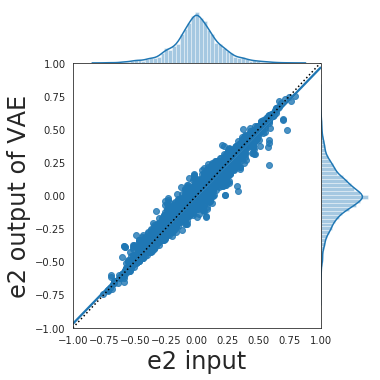

In [32]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_LSST_euclid[:,0,0], ellipticities_LSST_euclid[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_LSST_euclid[:,0,1], ellipticities_LSST_euclid[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

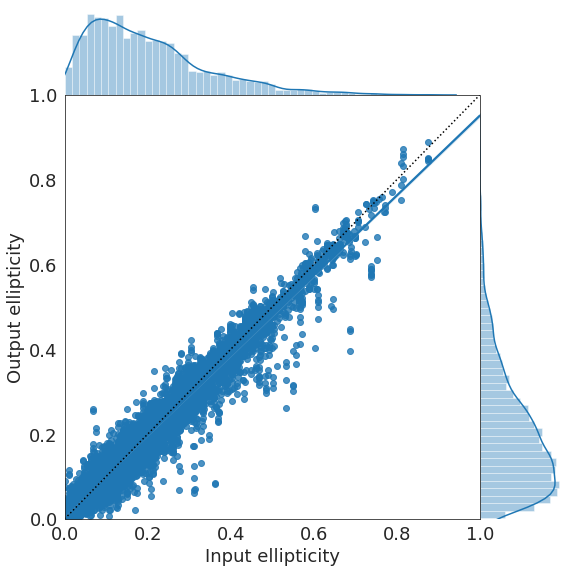

In [79]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}


with sns.axes_style('white'):
            g = sns.jointplot(e_beta_LSST_euclid[:,0,0], e_beta_LSST_euclid[:,1,0], kind='reg',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


In [36]:
# Linear regression
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(e_beta_LSST_euclid[:,0,0], e_beta_LSST_euclid[:,1,0])

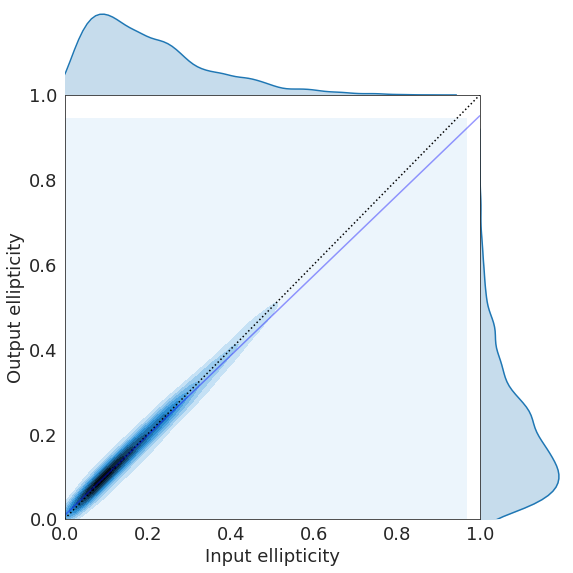

In [37]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(e_beta_LSST_euclid[:,0,0], e_beta_LSST_euclid[:,1,0], kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst_euclid*np.linspace(0, 1)+intercept_lsst_euclid, color = 'b', alpha = 0.4)

In [37]:
weak_snr_lsst_euclid = np.where(SNR_lsst_euclid<9)
print(weak_snr_lsst_euclid[0].shape)
ellipticities_LSST_euclid_mod = np.delete(ellipticities_LSST_euclid[:], weak_snr_lsst_euclid[0], axis = 0)
e_beta_LSST_euclid_mod = np.delete(e_beta_LSST_euclid[:], weak_snr_lsst_euclid[0], axis = 0)

(6205,)


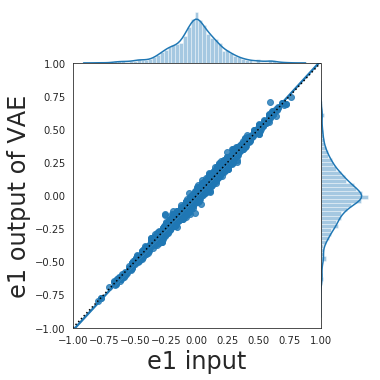

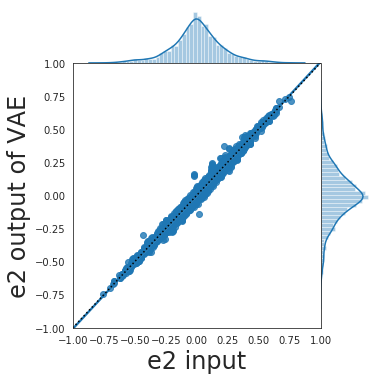

In [35]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_LSST_euclid_mod[:,0,0], ellipticities_LSST_euclid_mod[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_LSST_euclid_mod[:,0,1], ellipticities_LSST_euclid_mod[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

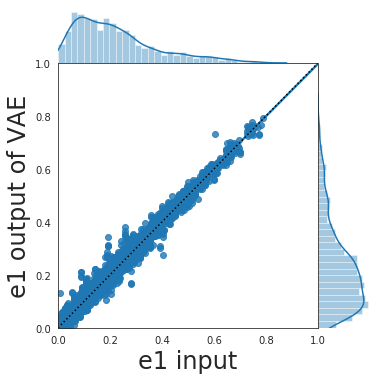

In [38]:
with sns.axes_style('white'):
            g = sns.jointplot(e_beta_LSST_euclid_mod[:,0,0], e_beta_LSST_euclid_mod[:,1,0], kind='reg',height =5,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


Error on ellipticity

In [39]:
delta_e_abs = e_beta_LSST_euclid[:,0,0]- e_beta_LSST_euclid[:,1,0]

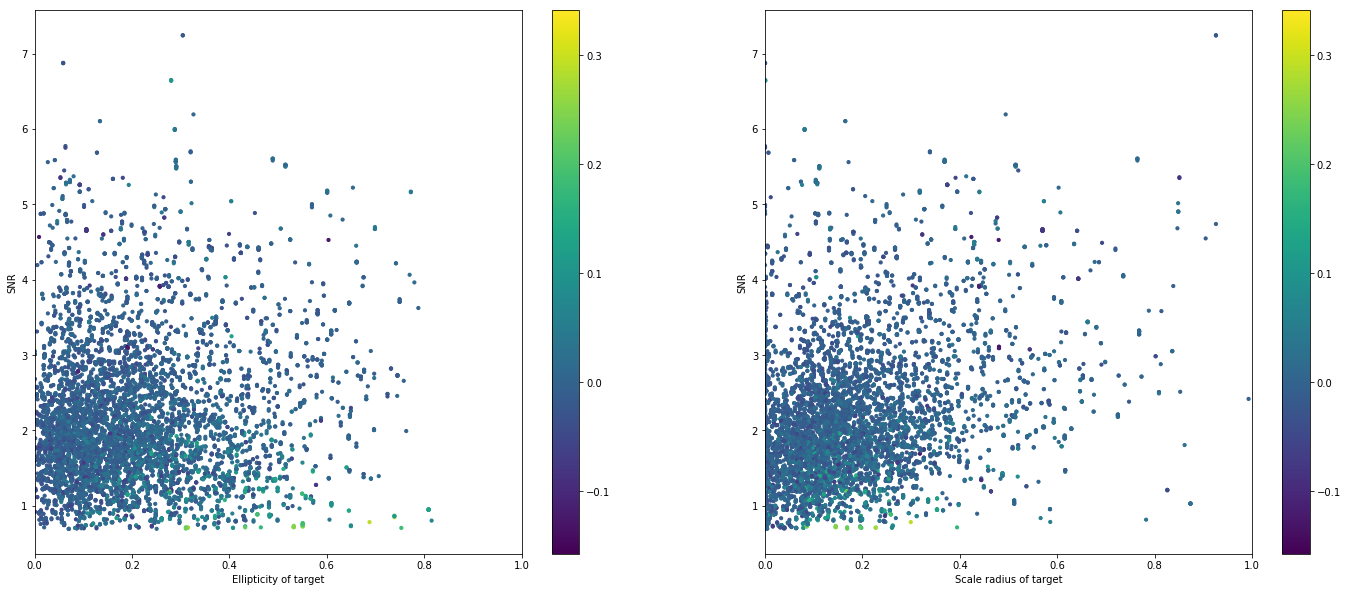

In [40]:
import matplotlib as mpl
fig, axes = plt.subplots(1,2, figsize=(24,10))

im = axes[0].scatter(e_beta_LSST_euclid[:,0,0], np.log(SNR_lsst_euclid),  c = delta_e_abs, s=10)#, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
axes[0].set_xlabel("Ellipticity of target")
axes[0].set_ylabel("SNR")#delta r to closest (arcsecond)/scale radius of centered
#axes[0].colorbar()
#plt.xscale('log')
axes[0].set_xlim(0,1)
fig.colorbar(im, ax=axes[0])

im = axes[1].scatter(scale_radius, np.log(SNR_lsst_euclid),  c = delta_e_abs, s=10)#, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
axes[1].set_xlabel("Scale radius of target")
axes[1].set_ylabel("SNR")#delta r to closest (arcsecond)/scale radius of centered
#axes[1].colorbar()
#plt.xscale('log')
axes[1].set_xlim(0,1)
fig.colorbar(im, ax=axes[1])

../../scripts/tools_for_VAE/tools_for_VAE/plot.py:56: RuntimeWarning: invalid value encountered in true_divide
  mean_y = ny/n
../../scripts/tools_for_VAE/tools_for_VAE/plot.py:58: RuntimeWarning: invalid value encountered in true_divide
  var_y = (ny2/n - mean_y**2)/n


Text(0, 0.5, 'mean and variance of absolute value of error on ellipticity (logscale)')

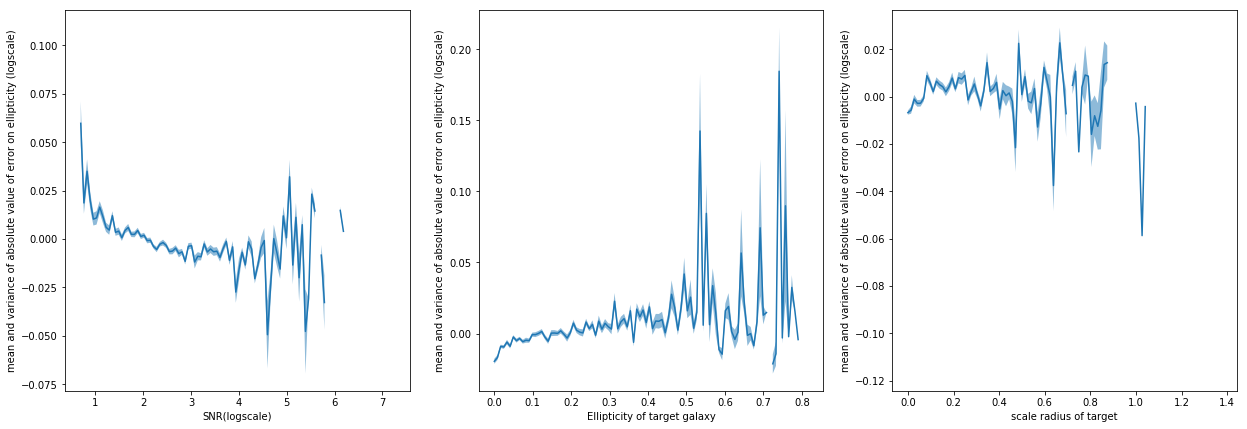

In [41]:
mean_delta, var_delta = mean_var(e_beta_LSST_euclid[:,0,0],delta_e_abs, bins = 100)

x = np.linspace(np.min(e_beta_LSST_euclid[:,0,0]), np.max(e_beta_LSST_euclid[:,0,0]), 100)
mid = (x[0:]+x[:])*0.5


mean_SNR, var_SNR = mean_var(np.log(SNR_lsst_euclid),delta_e_abs, bins = 100)

x_snr = np.linspace(np.min(np.log(SNR_lsst_euclid)), np.max(np.log(SNR_lsst_euclid)), 100)
mid_snr = (x_snr[0:]+x_snr[:])*0.5

mean_radius, var_radius = mean_var(scale_radius,delta_e_abs, bins = 100)

x_radius = np.linspace(np.min(scale_radius), np.max(scale_radius), 100)
mid_radius = (x_radius[0:]+x_radius[:])*0.5


fig, axes = plt.subplots(1,3, figsize=(21,7))

axes[0].plot(mid_snr,mean_SNR)
axes[0].fill_between(mid_snr, mean_SNR - var_SNR**0.5, mean_SNR + var_SNR**0.5, alpha=0.5)

axes[0].set_xlabel('SNR(logscale)')
axes[0].set_ylabel('mean and variance of absolute value of error on ellipticity (logscale)')
#axes[0].set_ylim(-6,0.5)


axes[1].plot(mid,mean_delta)
axes[1].fill_between(mid, mean_delta - var_delta**0.5, mean_delta + var_delta**0.5, alpha=0.5)

axes[1].set_xlabel('Ellipticity of target galaxy')
axes[1].set_ylabel('mean and variance of absolute value of error on ellipticity (logscale)')
#axes[1].set_ylim(-6,4)


axes[2].plot(mid_radius,mean_radius)
axes[2].fill_between(mid_radius, mean_radius - var_radius**0.5, mean_radius + var_radius**0.5, alpha=0.5)

axes[2].set_xlabel('scale radius of target')
axes[2].set_ylabel('mean and variance of absolute value of error on ellipticity (logscale)')
#axes[2].set_ylim(-6,0.5)

Text(0, 0.5, 'beta of output galaxy')

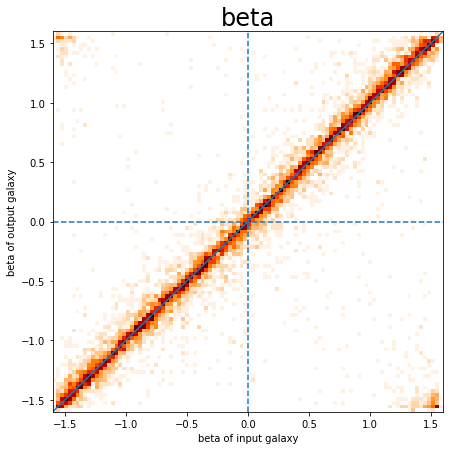

In [42]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1.6
_ = plt.hist2d(e_beta_LSST_euclid[:,0,1], e_beta_LSST_euclid[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('beta'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('beta of input galaxy')
plt.ylabel('beta of output galaxy')

### Luminosity plots

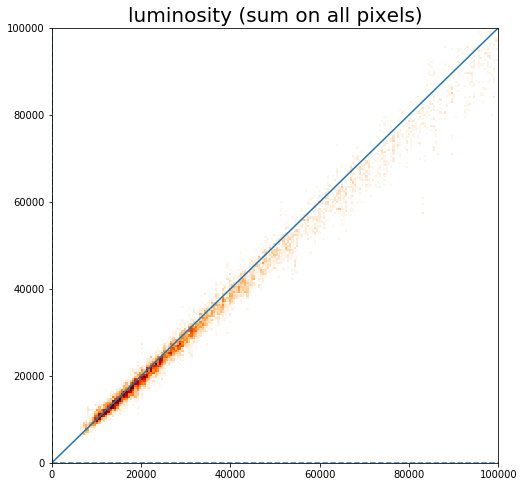

In [43]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple_lsst_euclid, lum_out_simple_lsst_euclid, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

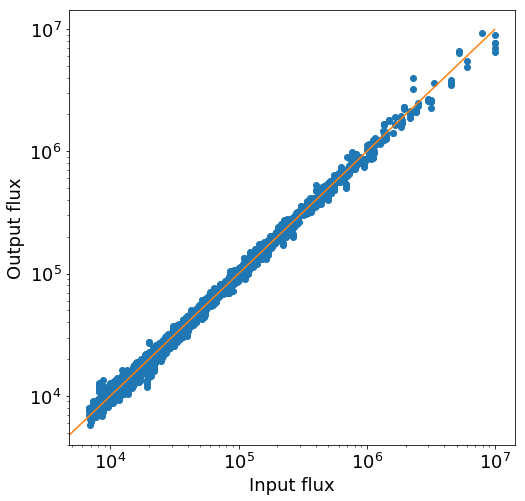

In [81]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = np.max(lum_in_simple_lsst_euclid)
axes.plot(lum_in_simple_lsst_euclid, lum_out_simple_lsst_euclid,'o')

axes.plot([-emax,+emax],[-emax,+emax])
#axes.axhline(y=0, ls='--')
#axes.axvline(x=0, ls='--')
#axes.set_title('luminosity (sum on all pixels)')#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlabel('Input flux')
axes.set_ylabel('Output flux')
axes.set_xscale('log')
axes.set_yscale('log')

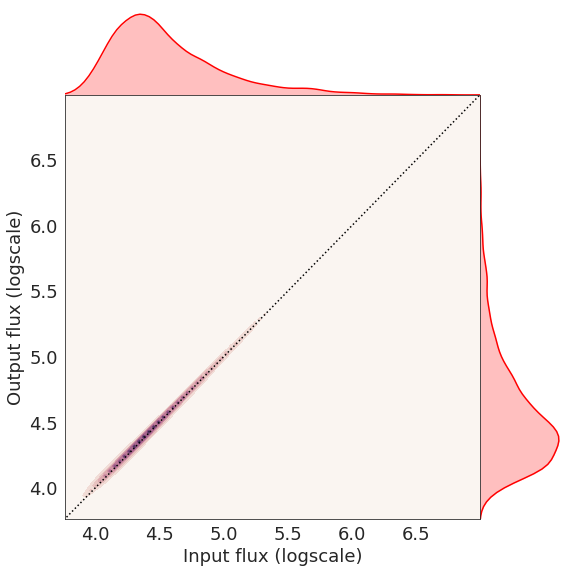

In [80]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(np.log10(lum_in_simple_lsst_euclid), np.log10(lum_out_simple_lsst_euclid), kind='kde',height =8,
                              xlim =[np.min(np.log10(lum_in_simple_lsst_euclid-1000)), np.max(np.log10(lum_in_simple_lsst_euclid))], ylim=[np.min(np.log10(lum_in_simple_lsst_euclid-1000)), np.max(np.log10(lum_in_simple_lsst_euclid))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(lum_in_simple_lsst_euclid))),
                            np.linspace(-1, np.max(np.log10(lum_in_simple_lsst_euclid))), ':k')

### Corner plot latent space

In [177]:
latent_dim =32
epsilon_std = 1.0

a = batch_gen_lsst_euclid.__getitem__(2)
output_enc = encoder_LSST_EUCLID.predict(a[0], batch_size = batch_size)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

In [178]:
z = []
for i in range (100):
    a = batch_gen_lsst_euclid.__getitem__(2)
    output_enc = encoder_LSST_EUCLID.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))

z = np.concatenate(z, axis = 0)

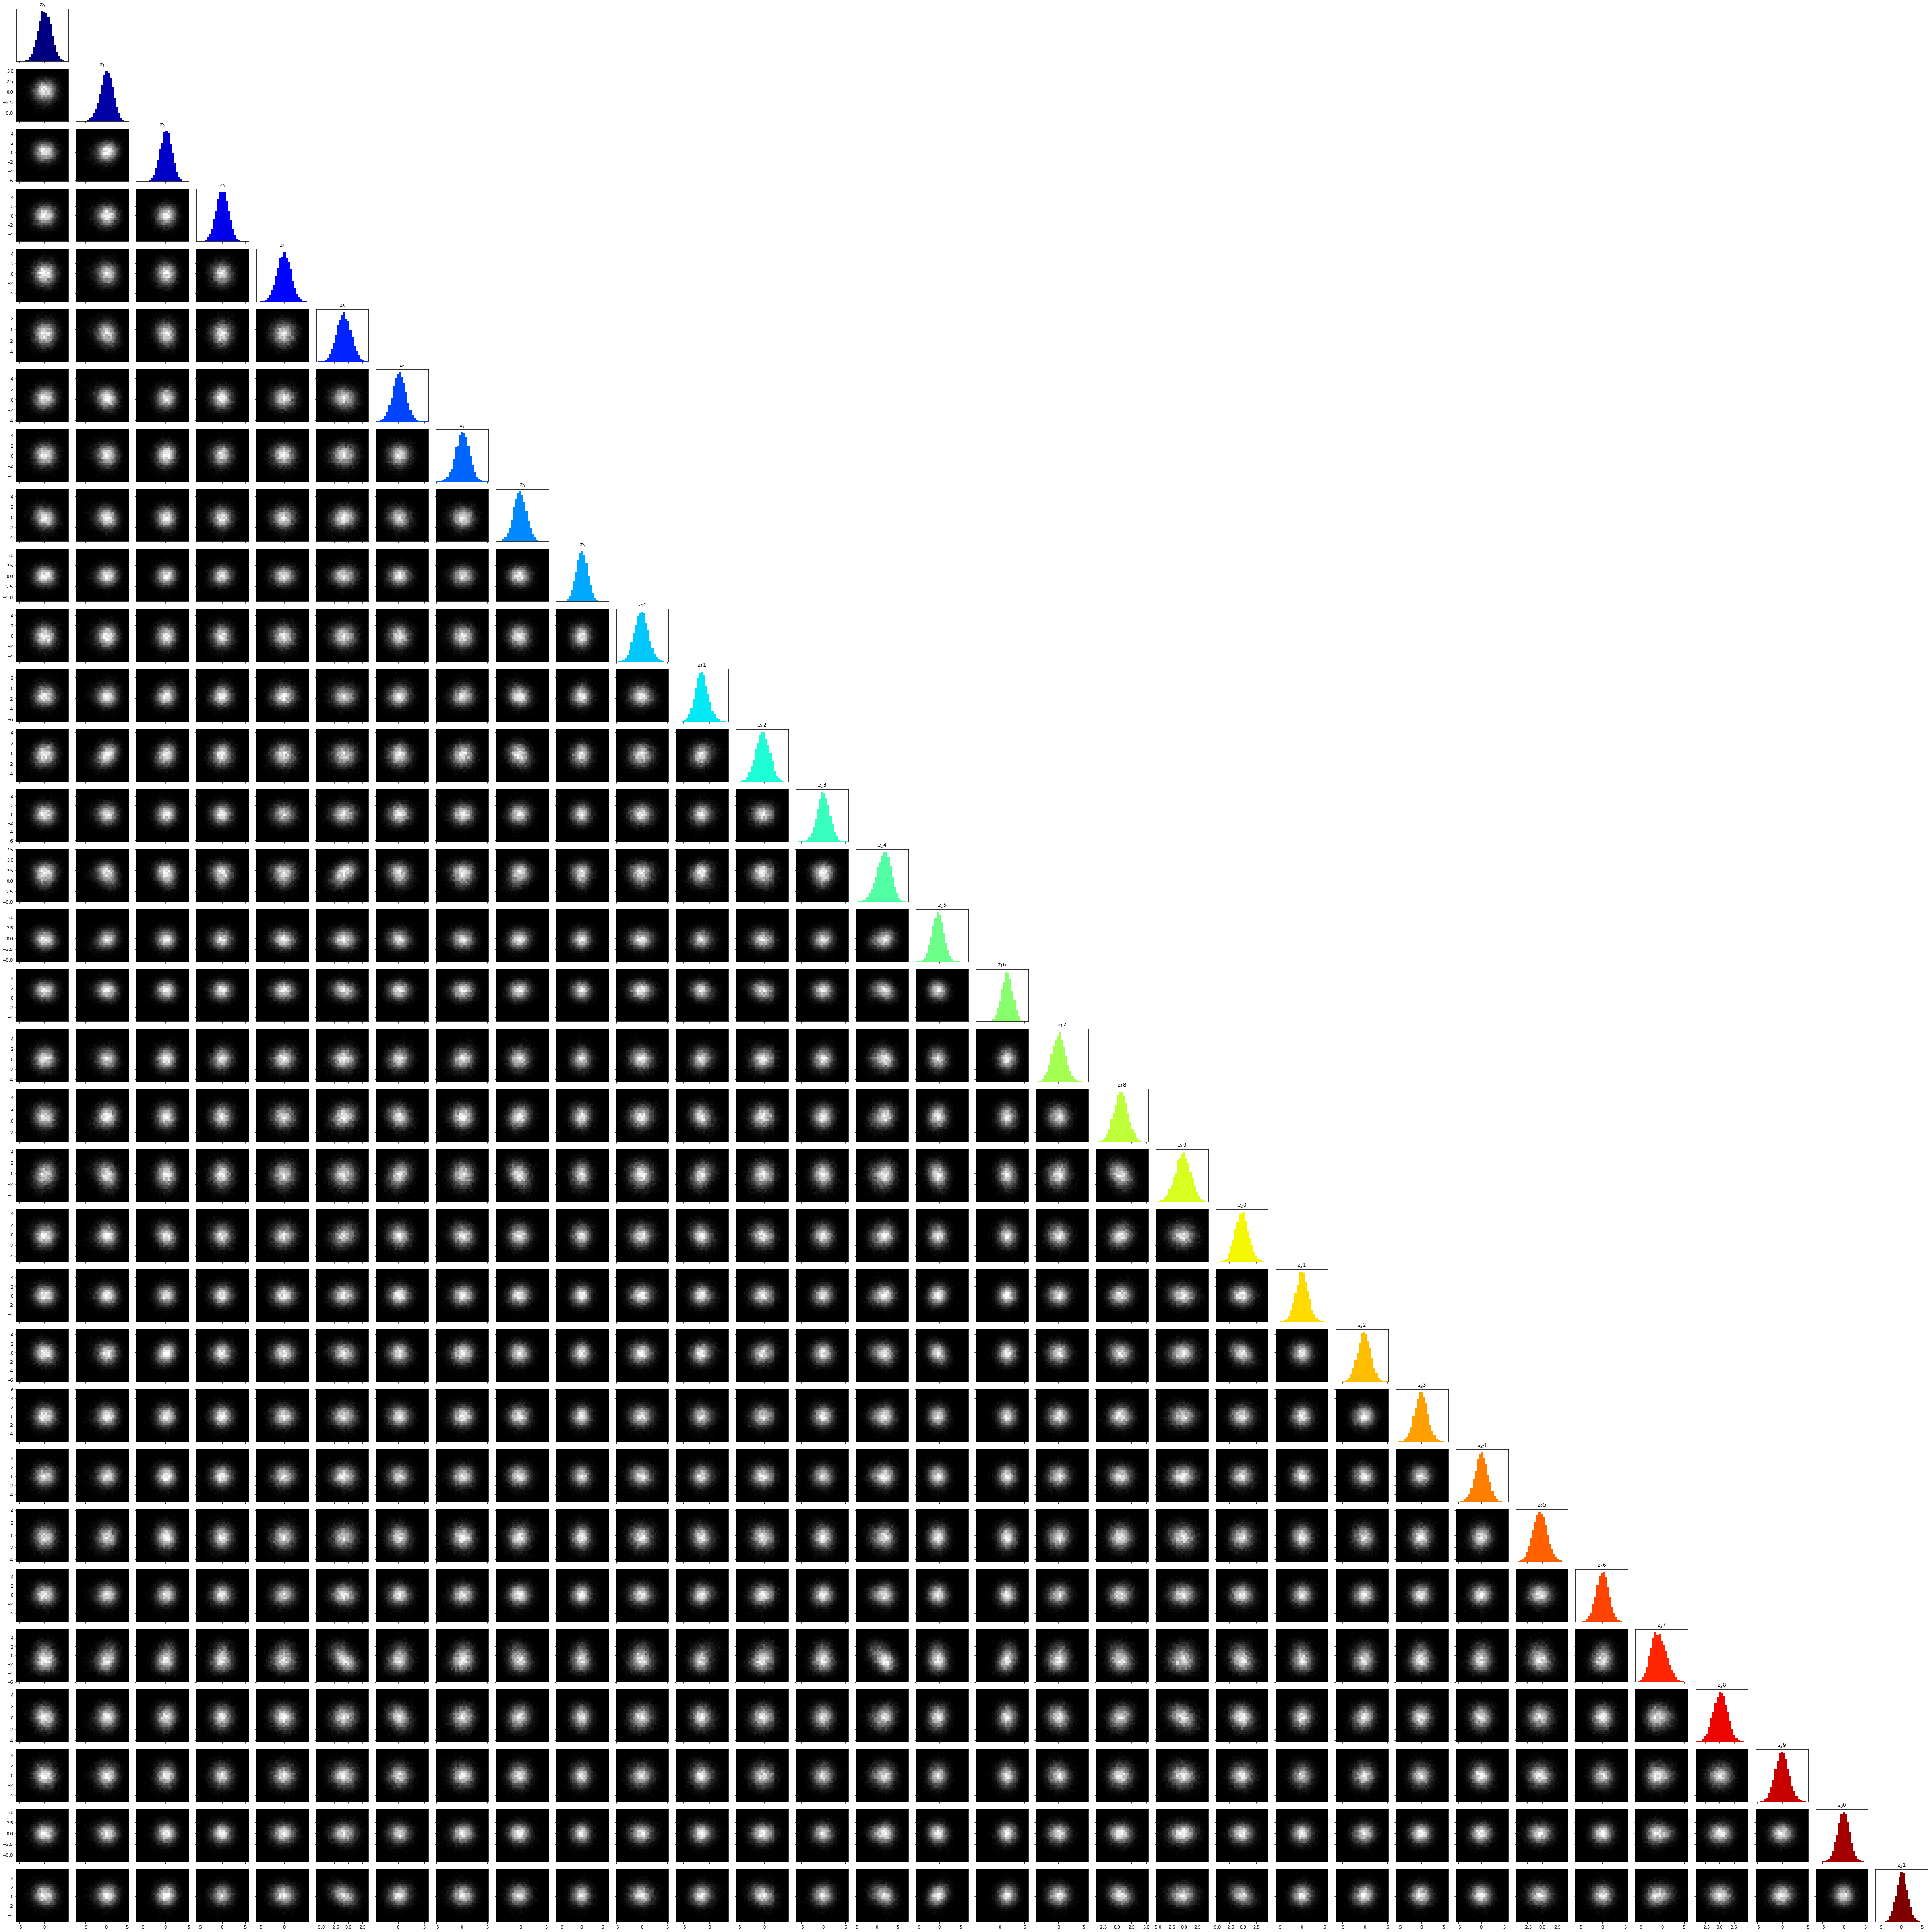

In [179]:
plot_corner_latent(z)

## Comparison between different VAE on SNR

median of input ellipticity: 0.16966985816320826
mean of input ellipticity: 0.20047713162747804


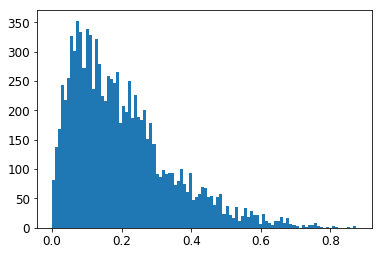

In [163]:
y, x, _ = plt.hist(e_beta_r[:,0,0], bins = 100)
print('median of input ellipticity: '+str(np.median(e_beta_r[:,0,0])))
print('mean of input ellipticity: '+str(np.mean(e_beta_r[:,0,0])))

In [168]:
y.max()

353.0

In [171]:
y.shape

(100,)

In [172]:
for i in range (100):
    if y[i] == y.max():
        print(x[i])

0.07002046752436526


In [47]:
SNR_over_1000 = np.where(SNR>1000)
print(SNR_over_1000[0].shape)

(6,)


In [48]:
SNR_over_100 = np.where(SNR>100)
print(SNR_over_100[0].shape)

(202,)


median of input SNR for LSST R filter VAE: 7.003564769743514
mean of input SNR for LSST R filter VAE: 15.671492082666557


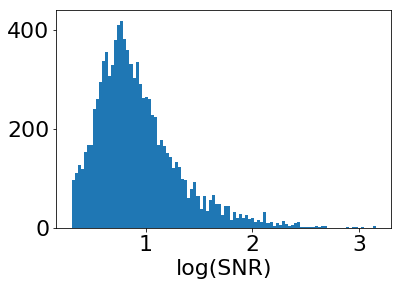

In [85]:
_ = plt.hist(np.log10(SNR[:]), bins = 100)
plt.xlabel('log(SNR)')
print('median of input SNR for LSST R filter VAE: '+str(np.median(SNR[:])))
print('mean of input SNR for LSST R filter VAE: '+str(np.mean(SNR[:])))

median of input SNR for LSST VAE: 6.989434152590794
mean of input SNR for LSST VAE: 16.196505026902503


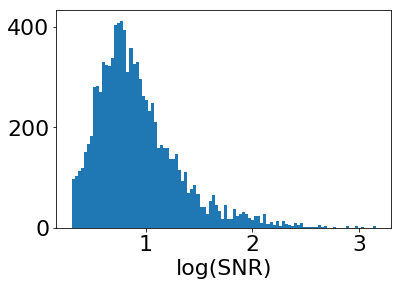

In [86]:
_ = plt.hist(np.log10(SNR_lsst[:]), bins = 100)
plt.xlabel('log(SNR)')
print('median of input SNR for LSST VAE: '+str(np.median(SNR_lsst[:])))
print('mean of input SNR for LSST VAE: '+str(np.mean(SNR_lsst[:])))

median of input SNR for LSST+Euclid VAE: 7.0802900322624955
mean of input SNR for LSST+Euclid VAE: 16.832441445053487


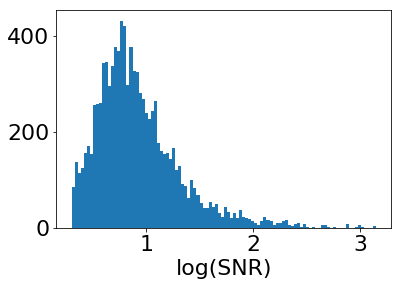

In [87]:
_ = plt.hist(np.log10(SNR_lsst_euclid[:]), bins = 100)
plt.xlabel('log(SNR)')
print('median of input SNR for LSST+Euclid VAE: '+str(np.median(SNR_lsst_euclid[:])))
print('mean of input SNR for LSST+Euclid VAE: '+str(np.mean(SNR_lsst_euclid[:])))

Shapes

In [45]:
delta_e_r = e_beta_r[:,0,0]- e_beta_r[:,1,0]
delta_e_lsst = e_beta_LSST[:,0,0]- e_beta_LSST[:,1,0]
delta_e_lsst_euclid = e_beta_LSST_euclid[:,0,0]- e_beta_LSST_euclid[:,1,0]

In [46]:
print("Mean of delta e for R filter only: "+str(np.mean(delta_e_r)))
print("Mean of delta e for LSST filters: "+str(np.mean(delta_e_lsst)))
print("Mean of delta e for LSST + Euclid filters: "+str(np.mean(delta_e_lsst_euclid)))

Mean of delta e for R filter only: 0.03512378047426242
Mean of delta e for LSST filters: 0.013455855810068596
Mean of delta e for LSST + Euclid filters: 0.0018008332060388391


/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


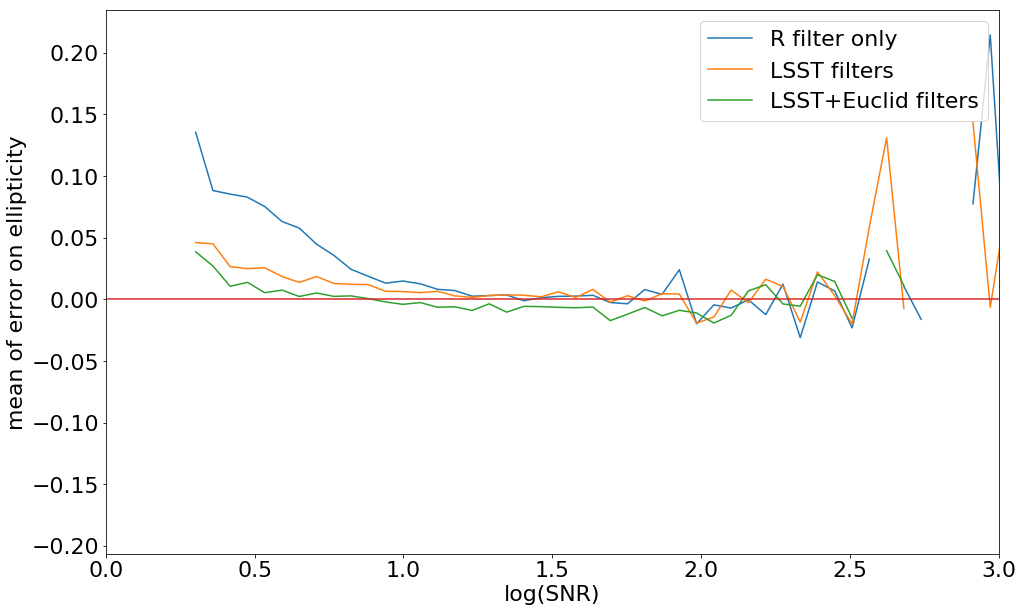

In [47]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(np.log10(SNR_r),delta_e_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_e_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 3)

plt.xlabel('log(SNR)')
plt.ylabel('mean of error on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


In [48]:
delta_e_rel_r = (e_beta_r[:,0,0]- e_beta_r[:,1,0])/e_beta_r[:,0,0]
delta_e_rel_lsst = (e_beta_LSST[:,0,0]- e_beta_LSST[:,1,0])/e_beta_LSST[:,0,0]
delta_e_rel_lsst_euclid = (e_beta_LSST_euclid[:,0,0]- e_beta_LSST_euclid[:,1,0])/e_beta_LSST_euclid[:,0,0]

In [49]:
print("Mean of relative delta e for R filter only: "+str(np.mean(delta_e_rel_r)))
print("Mean of relative delta e for LSST filters: "+str(np.mean(delta_e_rel_lsst)))
print("Mean of relative delta e for LSST + Euclid filters: "+str(np.mean(delta_e_rel_lsst_euclid)))

Mean of relative delta e for R filter only: -0.08430336446070735
Mean of relative delta e for LSST filters: -0.103679359466011
Mean of relative delta e for LSST + Euclid filters: -0.1072681225206824


In [50]:
SNR_below_4_r = np.where(SNR<np.sqrt(10))
SNR_below_4_lsst = np.where(SNR_lsst<np.sqrt(10))
SNR_below_4_lsst_euclid = np.where(SNR_lsst_euclid<np.sqrt(10))

In [51]:
print(SNR_below_4_r[0].shape, SNR_below_4_lsst[0].shape, SNR_below_4_lsst_euclid[0].shape)

(927,) (930,) (899,)


In [52]:
delta_e_rel_r_mod = np.delete(delta_e_rel_r, SNR_below_4_r[0])
delta_e_rel_lsst_mod = np.delete(delta_e_rel_lsst, SNR_below_4_lsst[0])
delta_e_rel_lsst_euclid_mod = np.delete(delta_e_rel_lsst_euclid, SNR_below_4_lsst_euclid[0])

In [53]:
print(delta_e_rel_r_mod.shape, delta_e_rel_lsst_mod.shape, delta_e_rel_lsst_euclid_mod.shape)

(9073,) (9070,) (9101,)


In [54]:
print("Mean of relative delta e for R filter only for SNR above 3.2: "+str(np.mean(delta_e_rel_r_mod)))
print("Mean of relative delta e for LSST filters for SNR above 3.2: "+str(np.mean(delta_e_rel_lsst_mod)))
print("Mean of relative delta e for LSST + Euclid filters for SNR above 3.2: "+str(np.mean(delta_e_rel_lsst_euclid_mod)))

Mean of relative delta e for R filter only for SNR above 3.2: -0.0873719843242748
Mean of relative delta e for LSST filters for SNR above 3.2: -0.08700453597661796
Mean of relative delta e for LSST + Euclid filters for SNR above 3.2: -0.11114675127985792


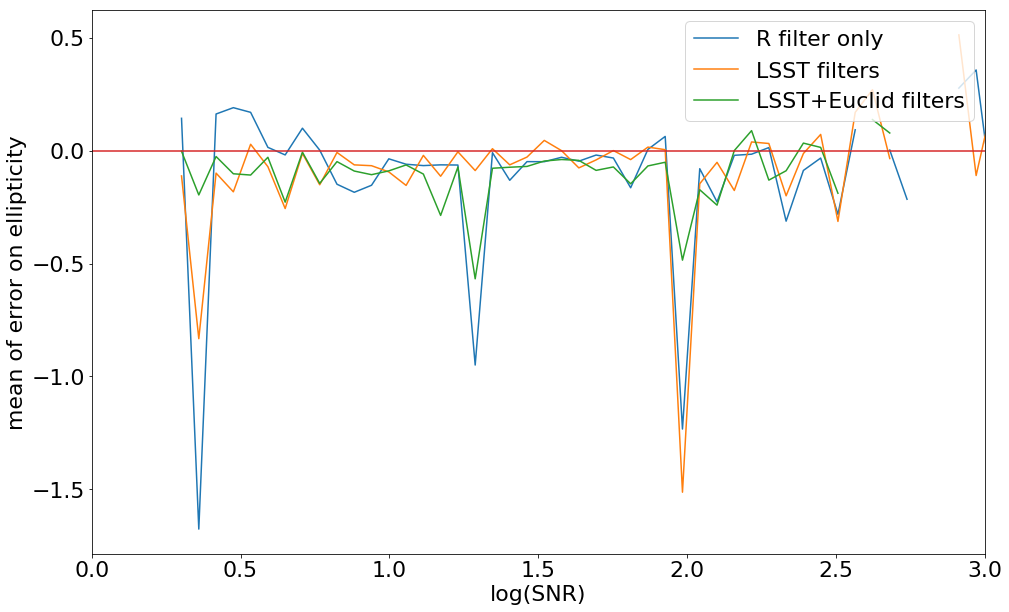

In [55]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(np.log10(SNR_r),delta_e_rel_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_e_rel_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_e_rel_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 3)

plt.xlabel('log(SNR)')
plt.ylabel('mean of error on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


In [56]:
delta_e_abs_r = np.abs(e_beta_r[:,0,0]- e_beta_r[:,1,0])
delta_e_abs_lsst = np.abs(e_beta_LSST[:,0,0]- e_beta_LSST[:,1,0])
delta_e_abs_lsst_euclid = np.abs(e_beta_LSST_euclid[:,0,0]- e_beta_LSST_euclid[:,1,0])

In [57]:
print("Mean of absolute value of delta e for R filter only: "+str(np.mean(delta_e_abs_r)))
print("Mean of absolute value of delta e for LSST filters: "+str(np.mean(delta_e_abs_lsst)))
print("Mean of absolute value of delta e for LSST + Euclid filters: "+str(np.mean(delta_e_abs_lsst_euclid)))

Mean of absolute value of delta e for R filter only: 0.061682461381068455
Mean of absolute value of delta e for LSST filters: 0.03689572750203355
Mean of absolute value of delta e for LSST + Euclid filters: 0.022827616173361934


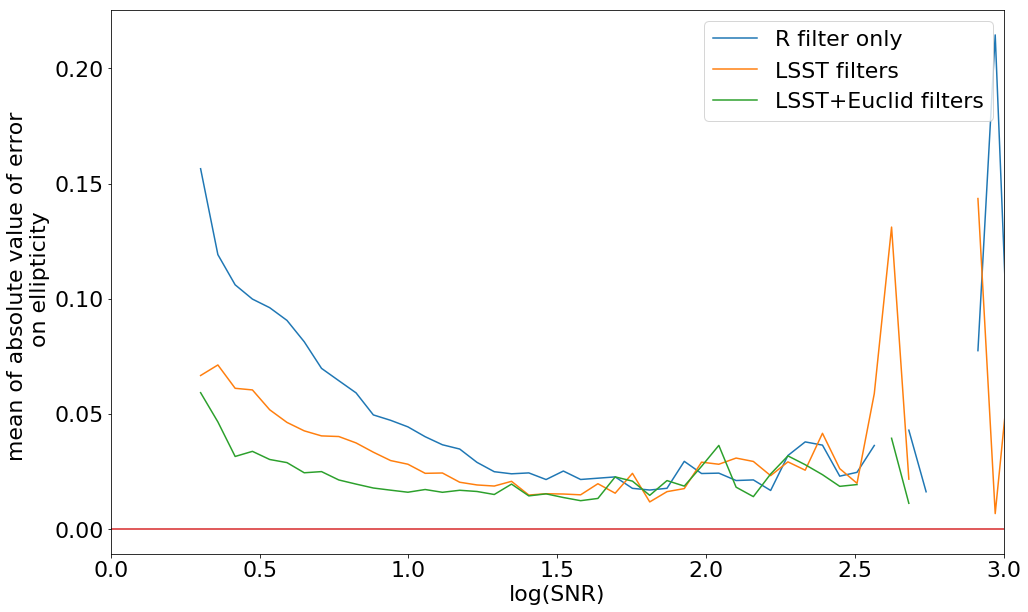

In [58]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(np.log10(SNR_r),delta_e_abs_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_e_abs_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_e_abs_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 3)

plt.xlabel('log(SNR)')
plt.ylabel('mean of absolute value of error \n on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


Flux

In [59]:
lum_in_simple_r.shape

(10000,)

In [60]:
delta_flux_r = lum_in_simple_r[:]- lum_out_simple_r[:]
delta_flux_lsst = lum_in_simple_lsst[:]- lum_out_simple_lsst[:]
delta_flux_lsst_euclid = lum_in_simple_lsst_euclid[:]- lum_out_simple_lsst_euclid[:]

In [61]:
print("Mean of delta flux for R filter only: "+str(np.mean(delta_flux_r)))
print("Mean of delta flux for LSST filters: "+str(np.mean(delta_flux_lsst)))
print("Mean of delta flux for LSST + Euclid filters: "+str(np.mean(delta_flux_lsst_euclid)))

Mean of delta flux for R filter only: 2646.3374
Mean of delta flux for LSST filters: -690.65204
Mean of delta flux for LSST + Euclid filters: 2880.852


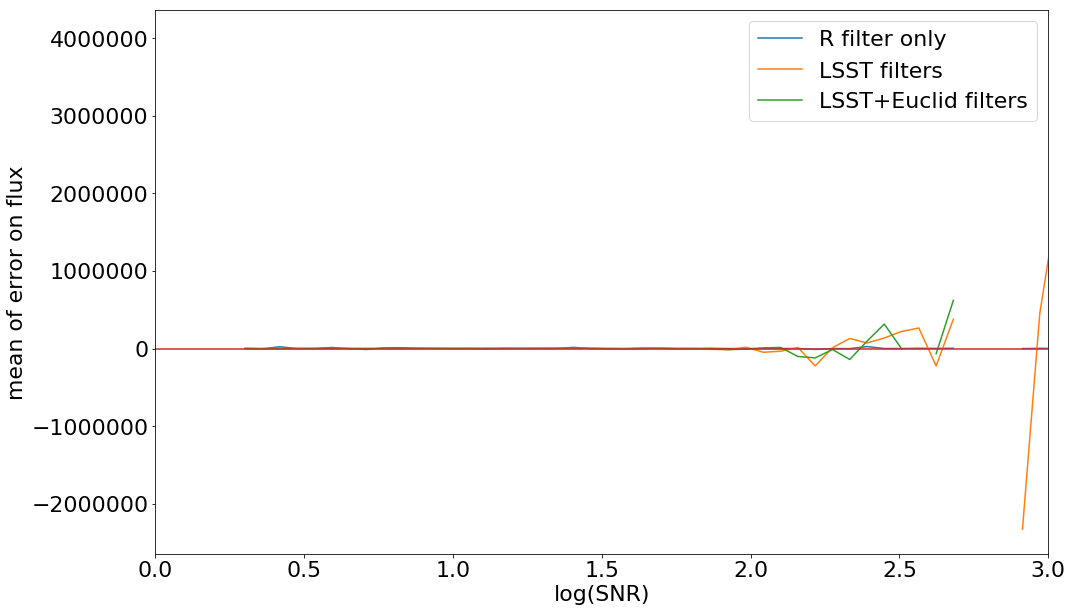

In [62]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(np.log10(SNR),delta_flux_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_flux_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_flux_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 3)

plt.xlabel('log(SNR)')
plt.ylabel('mean of error on flux')
plt.legend(loc = "upper right")


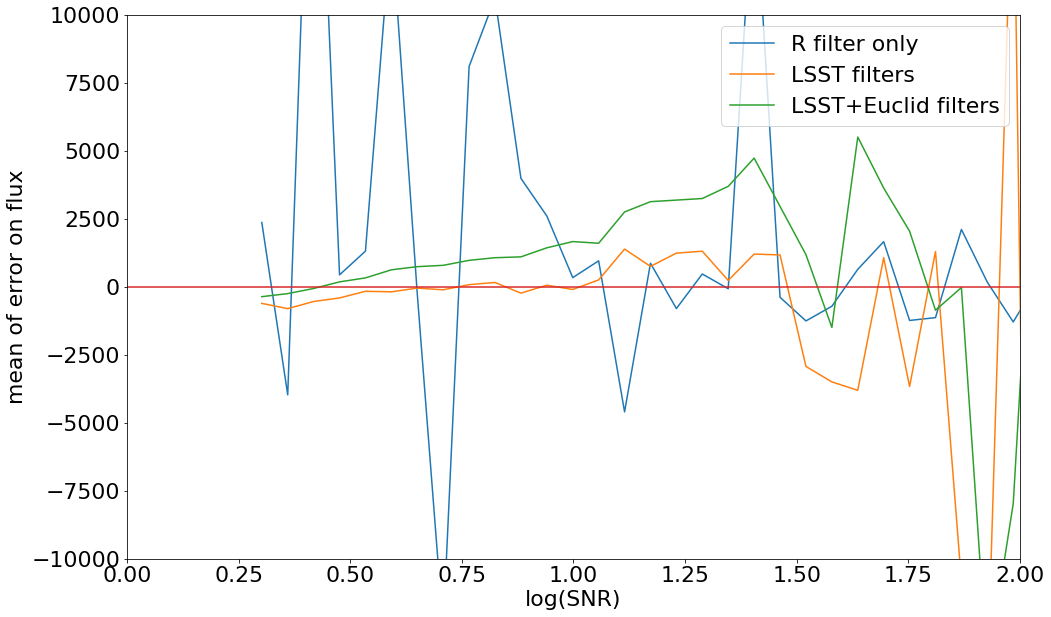

In [63]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(np.log10(SNR),delta_flux_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_flux_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_flux_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 2)
plt.ylim(-10000,10000)

plt.xlabel('log(SNR)')
plt.ylabel('mean of error on flux')
plt.legend(loc = "upper right")


In [64]:
delta_flux_abs_r = np.abs(lum_in_simple_r[:]- lum_out_simple_r[:])
delta_flux_abs_lsst = np.abs(lum_in_simple_lsst[:]- lum_out_simple_lsst[:])
delta_flux_abs_lsst_euclid = np.abs(lum_in_simple_lsst_euclid[:]- lum_out_simple_lsst_euclid[:])

In [65]:
print("Mean of absolute value of delta flux for R filter only: "+str(np.mean(delta_flux_abs_r)))
print("Mean of absolute value of delta flux for LSST filters: "+str(np.mean(delta_flux_abs_lsst)))
print("Mean of absolute value of delta flux for LSST + Euclid filters: "+str(np.mean(delta_flux_abs_lsst_euclid)))

Mean of absolute value of delta flux for R filter only: 10088.795
Mean of absolute value of delta flux for LSST filters: 9033.518
Mean of absolute value of delta flux for LSST + Euclid filters: 6899.457


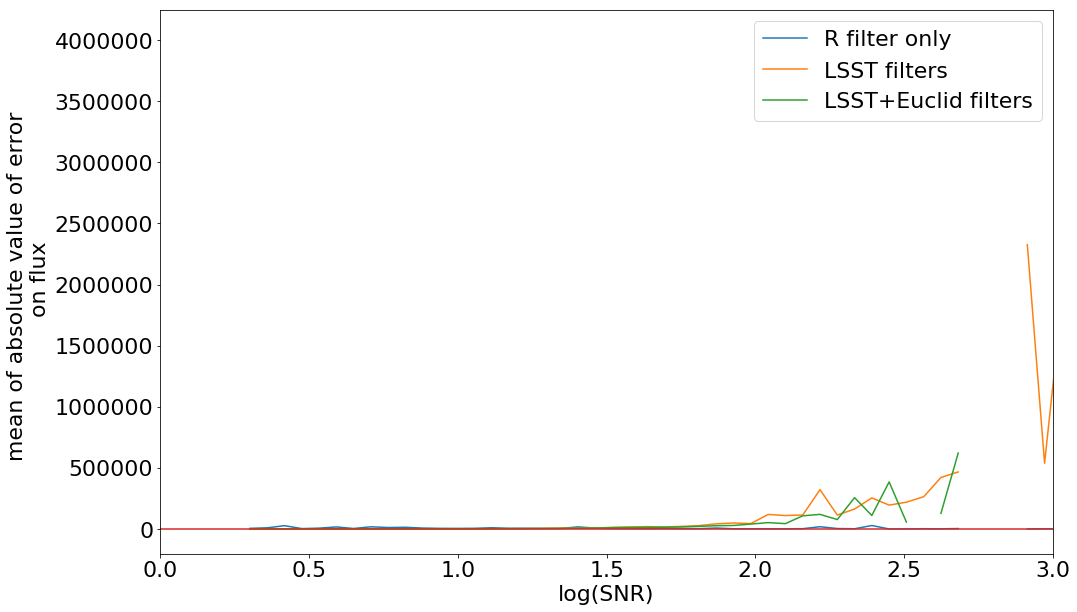

In [66]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(np.log10(SNR),delta_flux_abs_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_flux_abs_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_flux_abs_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 3)

plt.xlabel('log(SNR)')
plt.ylabel('mean of absolute value of error \n on flux')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


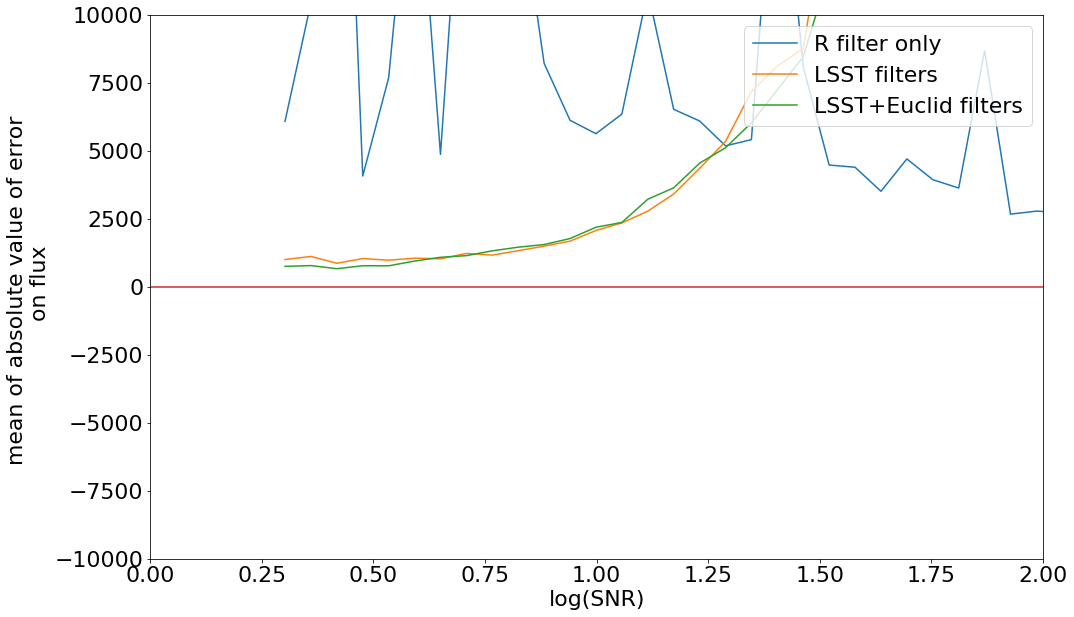

In [67]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(np.log10(SNR),delta_flux_abs_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_flux_abs_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_flux_abs_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 2)
plt.ylim(-10000,10000)

plt.xlabel('log(SNR)')
plt.ylabel('mean of absolute value of error \n on flux')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


In [68]:
delta_flux_rel_r = (lum_in_simple_r[:]- lum_out_simple_r[:])/lum_in_simple_r[:]
delta_flux_rel_lsst = (lum_in_simple_lsst[:]- lum_out_simple_lsst[:])/lum_in_simple_lsst[:]
delta_flux_rel_lsst_euclid = (lum_in_simple_lsst_euclid[:]- lum_out_simple_lsst_euclid[:])/lum_in_simple_lsst_euclid[:]

In [69]:
print("Mean of relative delta flux for R filter only: "+str(np.mean(delta_flux_rel_r)))
print("Mean of relative delta flux for LSST filters: "+str(np.mean(delta_flux_rel_lsst)))
print("Mean of relative delta flux for LSST + Euclid filters: "+str(np.mean(delta_flux_rel_lsst_euclid)))

Mean of relative delta flux for R filter only: -0.010180532
Mean of relative delta flux for LSST filters: -0.0051164026
Mean of relative delta flux for LSST + Euclid filters: 0.029875405


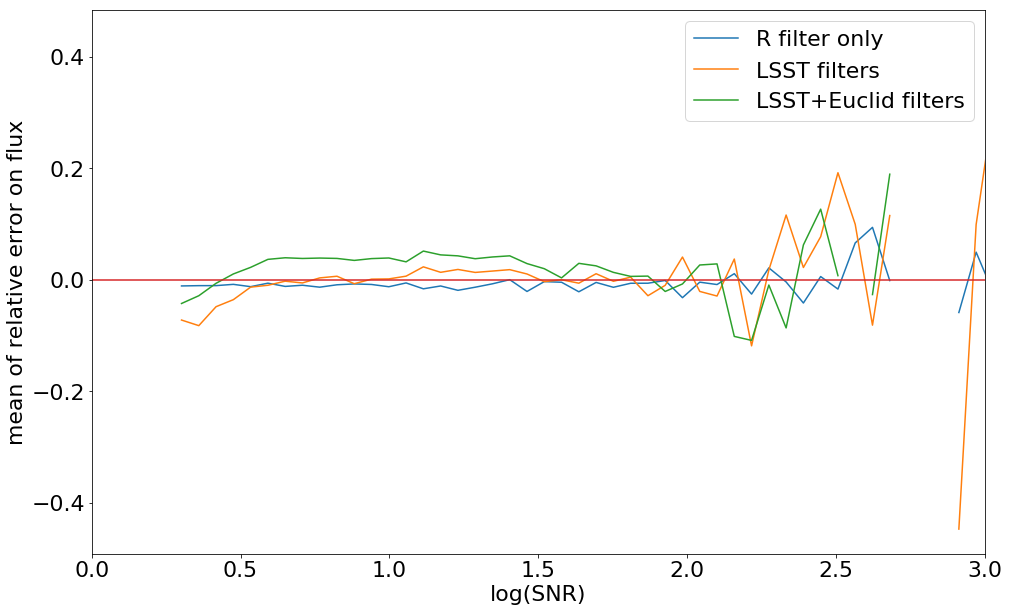

In [70]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(np.log10(SNR),delta_flux_rel_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(np.log10(SNR_lsst),delta_flux_rel_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(np.log10(SNR_lsst_euclid),delta_flux_rel_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(np.log10(SNR_lsst_euclid)), np.max(np.log10(SNR_lsst_euclid)), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 3)

plt.xlabel('log(SNR)')
plt.ylabel('mean of relative error on flux')
plt.legend(loc = "upper right")


## Comparison between different VAE as function of input ellipticity

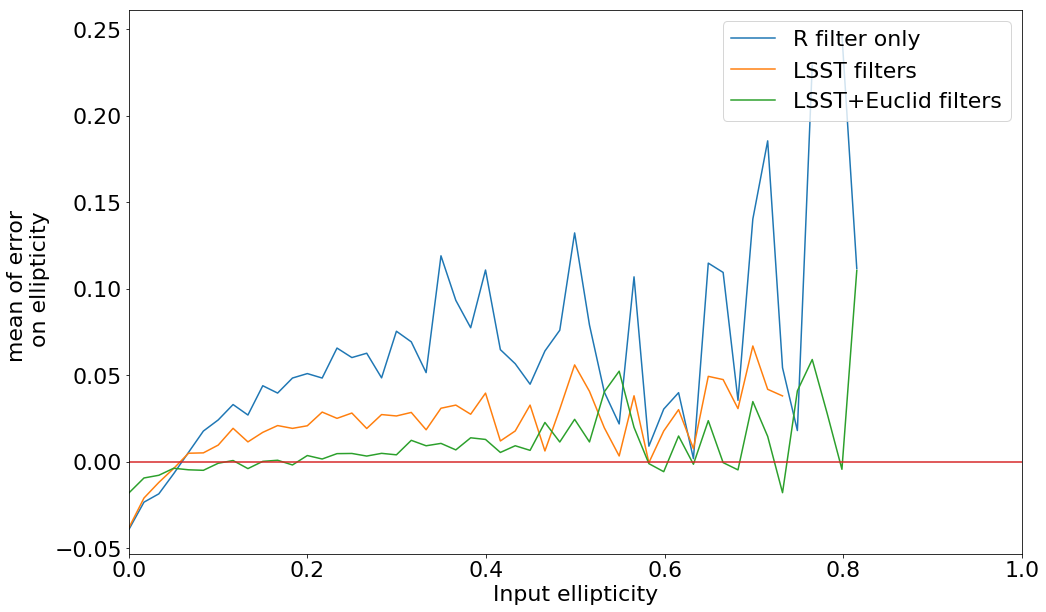

In [72]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(e_beta_r[:,0,0],delta_e_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(e_beta_LSST[:,0,0],delta_e_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(e_beta_LSST_euclid[:,0,0],delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(e_beta_LSST_euclid[:,0,0]), np.max(e_beta_LSST_euclid[:,0,0]), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 1)

plt.xlabel('Input ellipticity')
plt.ylabel('mean of error \n on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


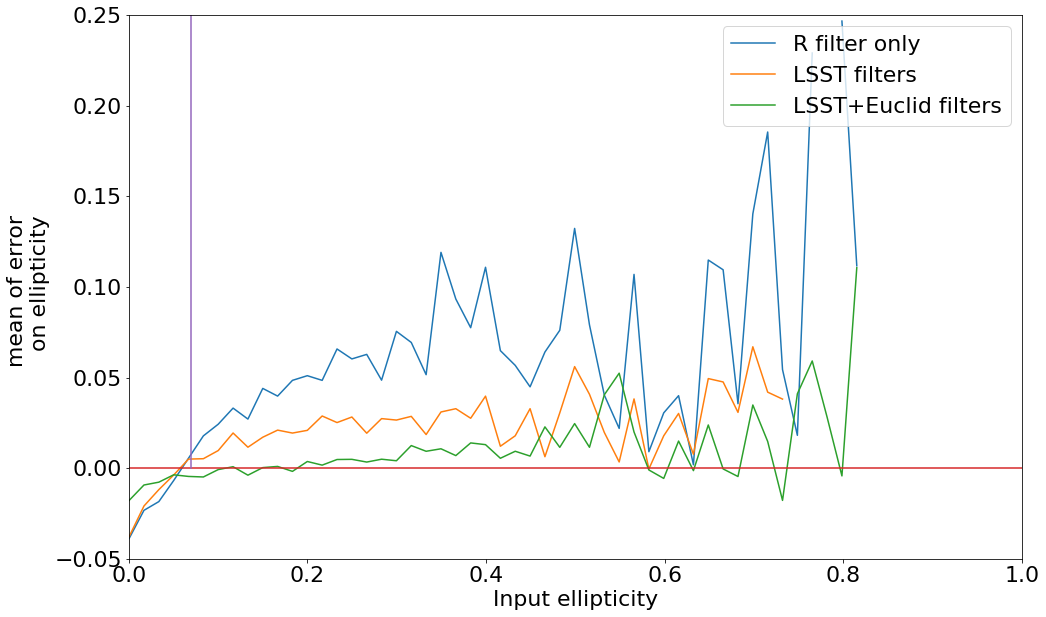

In [178]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(e_beta_r[:,0,0],delta_e_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(e_beta_LSST[:,0,0],delta_e_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(e_beta_LSST_euclid[:,0,0],delta_e_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(e_beta_LSST_euclid[:,0,0]), np.max(e_beta_LSST_euclid[:,0,0]), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5


plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 1)
plt.ylim(-0.05, 0.25)
plt.plot(np.ones((50))*0.07, mid_snr)

plt.xlabel('Input ellipticity')
plt.ylabel('mean of error \n on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


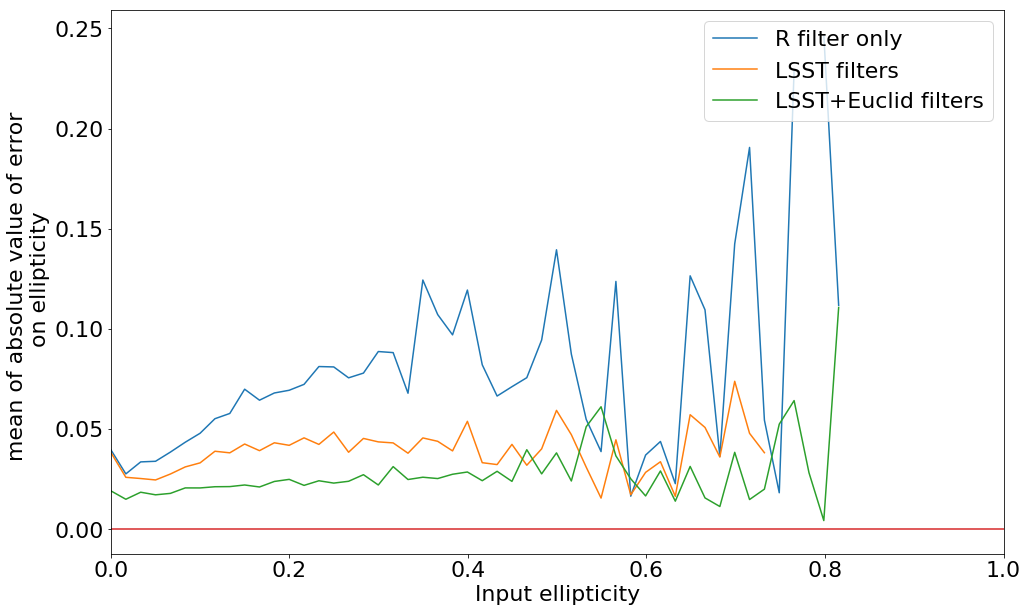

In [73]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(1, figsize=(16,10))


mean_SNR_r, var_SNR_r = mean_var(e_beta_r[:,0,0],delta_e_abs_r, bins = 50)
mean_SNR_lsst, var_SNR_lsst = mean_var(e_beta_LSST[:,0,0],delta_e_abs_lsst, bins = 50)
mean_SNR_lsst_euclid, var_SNR_lsst_euclid = mean_var(e_beta_LSST_euclid[:,0,0],delta_e_abs_lsst_euclid, bins = 50)

x_snr = np.linspace(np.min(e_beta_LSST_euclid[:,0,0]), np.max(e_beta_LSST_euclid[:,0,0]), 50)
mid_snr = (x_snr[0:]+x_snr[:])*0.5



plt.plot(mid_snr,mean_SNR_r, label = 'R filter only')
plt.plot(mid_snr,mean_SNR_lsst, label = 'LSST filters')
plt.plot(mid_snr,mean_SNR_lsst_euclid, label = 'LSST+Euclid filters')
plt.plot(np.arange(0,10), np.zeros(10))
plt.xlim(0, 1)

plt.xlabel('Input ellipticity')
plt.ylabel('mean of absolute value of error \n on ellipticity')
plt.legend(loc = "upper right")
#axes[0].set_ylim(-6,0.5)


### Probabilistic VAE: R, LSST, LSST+Euclid

In [119]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [120]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

###### Loww SNR

In [146]:
res_out_r_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

flux_out_r = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
flux_out_lsst = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
flux_out_lsst_euclid = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
gal_noiseless = []
SNR = []
err_count = 0

# Measurement of fluxes
mask = plot.createCircularMask(stamp_size,stamp_size,None,5)


i=0


while i < N:
    print('Galaxy number '+str(i+1))
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    print('SNR = '+str(list_galsim_simple[3][0]))
    
    if list_galsim_simple[3][0]<10:
        gal.append(list_galsim_simple[0][0])
        gal_noiseless.append(denorm(list_galsim_simple[1], bands_lsst_euclid, channel_last=True)[0])
        SNR.append(list_galsim_simple[3][0])

        for k in range (len(list_galsim_simple[0])):
            list_galsim_simple[0][k] = gal[i]
        
        try: 
            for j in range (nb_of_samplings):
                print('sample number '+str(j+1))
                output_vae_list_r = vae_lsst_r_band_conv.predict(list_galsim_simple[0][:,:,:,6].reshape((batch_size,64,64,1)), batch_size = batch_size)
                output_vae_list_r_denormed = denorm(output_vae_list_r, bands_r, channel_last = True)

                output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0][:,:,:,4:], batch_size = batch_size)
                output_vae_list_lsst_denormed = denorm(output_vae_list_lsst, bands_lsst, channel_last = True)

                output_vae_list_lsst_euclid = vae_lsst_euclid_conv.predict(list_galsim_simple[0], batch_size = batch_size)
                output_vae_list_lsst_euclid_denormed = denorm(output_vae_list_lsst_euclid, bands_lsst_euclid, channel_last = True)

                for t in range (batch_size):
                    img_out_simple = galsim.Image(output_vae_list_r_denormed[t,:,:,0])
                    res_out_r_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                    res_out_r_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
                    res_out_r_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
                    masked_img_in_simple = output_vae_list_r_denormed[t,:,:,0].copy()
                    masked_img_in_simple[~mask] = 0  
                    flux_out_r[i,j*batch_size+t] = np.sum(masked_img_in_simple)

                    img_out_simple = galsim.Image(output_vae_list_lsst_denormed[t,:,:,2])
                    res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                    res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
                    res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
                    masked_img_in_simple = output_vae_list_lsst_denormed[t,:,:,2].copy()
                    masked_img_in_simple[~mask] = 0  
                    flux_out_lsst[i,j*batch_size+t] = np.sum(masked_img_in_simple)
    
                    img_out_simple = galsim.Image(output_vae_list_lsst_euclid_denormed[t,:,:,6])
                    res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                    res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
                    res_out_lsst_euclid_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
                    masked_img_in_simple = output_vae_list_lsst_euclid_denormed[t,:,:,6].copy()
                    masked_img_in_simple[~mask] = 0  
                    flux_out_lsst_euclid[i,j*batch_size+t] = np.sum(masked_img_in_simple)
            i+=1
        except :
            err_count +=1
            print('erreur')
            pass
        continue

print("Finished. Number of error = "+str(err_count))

Galaxy number 1
SNR = 129.87428754840428
Galaxy number 1
SNR = 7.8623086484522675
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
sample number 10
Galaxy number 2
SNR = 10.028838106464532
Galaxy number 2
SNR = 137.13519700324616
Galaxy number 2
SNR = 17.577943335817864
Galaxy number 2
SNR = 4.313827877418426
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
sample number 10
Galaxy number 3
SNR = 12.328022751373656
Galaxy number 3
SNR = 4.315322112968937
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
sample number 10
Finished. Number of error = 0


In [147]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')
flux_in = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(gal_noiseless[k][:,:,6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    masked_img_in_simple = gal_noiseless[k][:,:,6].copy()
    masked_img_in_simple[~mask] = 0  
    flux_in[k] = np.sum(masked_img_in_simple)                
    print(res_in_e1[k], res_in_e2[k])

-0.05719211 -0.07745122
0.025850521 0.124665655
0.19599462 0.04490177


In [148]:
res_in_e.shape, res_out_r_e.shape

((3,), (3, 1000))

In [149]:
delta_e_r_sample = np.zeros((3,1000))
delta_e_lsst_sample = np.zeros((3,1000))
delta_e_lsst_euclid_sample = np.zeros((3,1000))

for i in range (3):
    delta_e_r_sample[i,:] = res_in_e[i] - res_out_r_e[i,:]
    delta_e_lsst_sample[i,:] = res_in_e[i] - res_out_lsst_e[i,:]
    delta_e_lsst_euclid_sample[i,:] = res_in_e[i] - res_out_lsst_euclid_e[i,:]

print('Mean of error on ellipticity for LSST R filter VAE: '+str(np.mean(delta_e_r_sample)))
print('Mean of error on ellipticity for LSST filters VAE: '+str(np.mean(delta_e_lsst_sample)))
print('Mean of error on ellipticity for LSST+Euclid filters VAE: '+str(np.mean(delta_e_lsst_euclid_sample)))

Mean of error on ellipticity for LSST R filter VAE: 0.03656061477214098
Mean of error on ellipticity for LSST filters VAE: 0.02781070553759734
Mean of error on ellipticity for LSST+Euclid filters VAE: 0.001925115168094635


In [150]:
delta_e_r_rel_sample = np.zeros((3,1000))
delta_e_lsst_rel_sample = np.zeros((3,1000))
delta_e_lsst_euclid_rel_sample = np.zeros((3,1000))

for i in range (3):
    delta_e_r_rel_sample[i] = (res_in_e[i] - res_out_r_e[i,:])/res_in_e[i]
    delta_e_lsst_rel_sample[i] = (res_in_e[i] - res_out_lsst_e[i,:])/res_in_e[i]
    delta_e_lsst_euclid_rel_sample[i] = (res_in_e[i] - res_out_lsst_euclid_e[i,:])/res_in_e[i]

print('Mean of relative error on ellipticity for LSST R filter VAE: '+str(np.mean(delta_e_r_rel_sample)))
print('Mean of relative error on ellipticity for LSST filters VAE: '+str(np.mean(delta_e_lsst_rel_sample)))
print('Mean of relative error on ellipticity for LSST+Euclid filters VAE: '+str(np.mean(delta_e_lsst_euclid_rel_sample)))

Mean of relative error on ellipticity for LSST R filter VAE: 0.019691017288016154
Mean of relative error on ellipticity for LSST filters VAE: 0.0014466352939683323
Mean of relative error on ellipticity for LSST+Euclid filters VAE: -0.013062369690895746


In [151]:
denormed_gal = denorm(np.array(gal), bands_lsst_euclid, channel_last = True)

[]

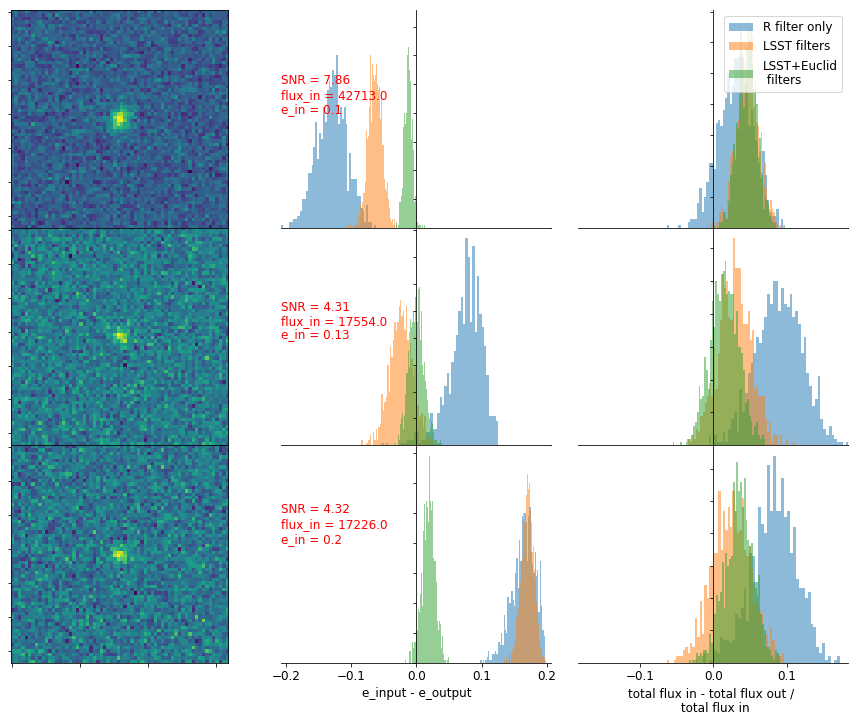

In [152]:
##### Plots configuration
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)


####### Limit for histograms

max_lim_e = np.max(np.concatenate((np.abs(res_out_r_e[0]- res_in_e[0]),
                            np.abs(res_out_r_e[1]- res_in_e[1]),
                            np.abs(res_out_r_e[2]- res_in_e[2]),
                            np.abs(res_out_lsst_e[0]- res_in_e[0]),
                            np.abs(res_out_lsst_e[1]- res_in_e[1]),
                            np.abs(res_out_lsst_e[2]- res_in_e[2]),
                            np.abs(res_out_lsst_euclid_e[0]- res_in_e[0]),
                            np.abs(res_out_lsst_euclid_e[1]- res_in_e[1]),
                            np.abs(res_out_lsst_euclid_e[2]- res_in_e[2]))), axis = 0)

max_lim_flux = np.max(np.concatenate((np.abs(flux_out_r[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_r[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_r[2]- flux_in[2])/flux_in[2],
                            np.abs(flux_out_lsst[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_lsst[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_lsst[2]- flux_in[2])/flux_in[2],
                            np.abs(flux_out_lsst_euclid[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_lsst_euclid[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_lsst_euclid[2]- flux_in[2])/flux_in[2])), axis = 0)

########## Galaxy 1

ax = axes[0,0]
_ = ax.imshow(denormed_gal[0][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[0,1]
_ = ax.hist(res_in_e[0]-res_out_r_e[0], bins = 50, label ='R filter only' , alpha = 0.5)
_ = ax.hist(res_in_e[0]-res_out_lsst_e[0], bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_in_e[0]-res_out_lsst_euclid_e[0], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[0], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[0], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[0], 2)), fontsize =12, color='r')
#ax.legend(loc='upper right')
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[0,2]
_ = ax.hist((flux_in[0]-flux_out_r[0])/flux_in[0], bins = 50, label ='R filter only' , alpha = 0.5)
_ = ax.hist((flux_in[0]-flux_out_lsst[0])/flux_in[0], bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist((flux_in[0]-flux_out_lsst_euclid[0])/flux_in[0], bins = 50, label ='LSST+Euclid\n filters' , alpha = 0.5)
ax.legend(loc='upper right')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])



########## Galaxy 2

ax = axes[1,0]
_ = ax.imshow(denormed_gal[1][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
_ = ax.hist(res_in_e[1]-res_out_r_e[1], bins = 50,  alpha = 0.5)
_ = ax.hist(res_in_e[1]-res_out_lsst_e[1], bins = 50,  alpha = 0.5)
_ = ax.hist(res_in_e[1]-res_out_lsst_euclid_e[1], bins = 50,  alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[1], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[1], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[1], 2)), fontsize =12, color='r')
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
_ = ax.hist((flux_in[1]-flux_out_r[1])/flux_in[1], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[1]-flux_out_lsst[1])/flux_in[1], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[1]-flux_out_lsst_euclid[1])/flux_in[1], bins = 50,  alpha = 0.5)
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])


########## Galaxy 3

ax = axes[2,0]
_ = ax.imshow(denormed_gal[2][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
_ = ax.hist(res_in_e[2]-res_out_r_e[2], bins = 50,  alpha = 0.5)
_ = ax.hist(res_in_e[2]-res_out_lsst_e[2], bins = 50, alpha = 0.5)
_ = ax.hist(res_in_e[2]-res_out_lsst_euclid_e[2], bins = 50, alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[2], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[2], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[2], 2)), fontsize =12, color='r')
ax.set_xlabel('e_input - e_output', fontsize = 12)
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.set_yticklabels([])

ax = axes[2,2]
_ = ax.hist((flux_in[2]-flux_out_r[2])/flux_in[2], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[2]-flux_out_lsst[2])/flux_in[2], bins = 50, alpha = 0.5)
_ = ax.hist((flux_in[2]-flux_out_lsst_euclid[2])/flux_in[2], bins = 50, alpha = 0.5)
ax.set_xlabel('total flux in - total flux out / \n total flux in')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.set_yticklabels([])

[]

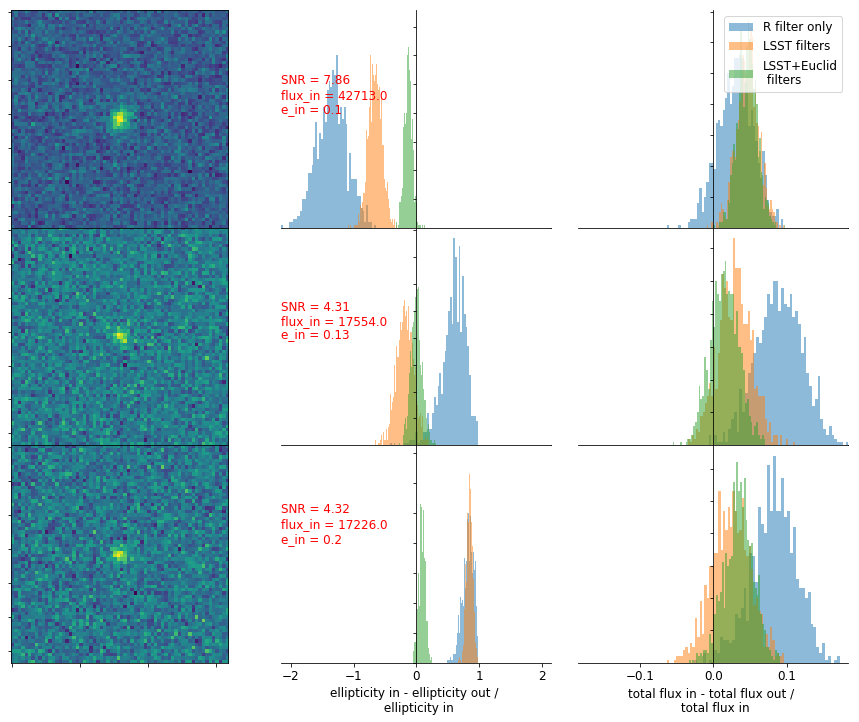

In [153]:
##### Plots configuration
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)


####### Limit for histograms

max_lim_e = np.max(np.concatenate((np.abs(res_out_r_e[0]- res_in_e[0])/res_in_e[0],
                            np.abs(res_out_r_e[1]- res_in_e[1])/res_in_e[1],
                            np.abs(res_out_r_e[2]- res_in_e[2])/res_in_e[2],
                            np.abs(res_out_lsst_e[0]- res_in_e[0])/res_in_e[0],
                            np.abs(res_out_lsst_e[1]- res_in_e[1])/res_in_e[1],
                            np.abs(res_out_lsst_e[2]- res_in_e[2])/res_in_e[2],
                            np.abs(res_out_lsst_euclid_e[0]- res_in_e[0])/res_in_e[0],
                            np.abs(res_out_lsst_euclid_e[1]- res_in_e[1])/res_in_e[1],
                            np.abs(res_out_lsst_euclid_e[2]- res_in_e[2])/res_in_e[2])), axis = 0)

max_lim_flux = np.max(np.concatenate((np.abs(flux_out_r[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_r[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_r[2]- flux_in[2])/flux_in[2],
                            np.abs(flux_out_lsst[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_lsst[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_lsst[2]- flux_in[2])/flux_in[2],
                            np.abs(flux_out_lsst_euclid[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_lsst_euclid[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_lsst_euclid[2]- flux_in[2])/flux_in[2])), axis = 0)

########## Galaxy 1

ax = axes[0,0]
_ = ax.imshow(denormed_gal[0][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[0,1]
_ = ax.hist((res_in_e[0]-res_out_r_e[0])/res_in_e[0], bins = 50, label ='R filter only' , alpha = 0.5)
_ = ax.hist((res_in_e[0]-res_out_lsst_e[0])/res_in_e[0], bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist((res_in_e[0]-res_out_lsst_euclid_e[0])/res_in_e[0], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[0], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[0], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[0], 2)), fontsize =12, color='r')
#ax.legend(loc='upper right')
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[0,2]
_ = ax.hist((flux_in[0]-flux_out_r[0])/flux_in[0], bins = 50, label ='R filter only' , alpha = 0.5)
_ = ax.hist((flux_in[0]-flux_out_lsst[0])/flux_in[0], bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist((flux_in[0]-flux_out_lsst_euclid[0])/flux_in[0], bins = 50, label ='LSST+Euclid\n filters' , alpha = 0.5)
ax.legend(loc='upper right')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])



########## Galaxy 2

ax = axes[1,0]
_ = ax.imshow(denormed_gal[1][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
_ = ax.hist((res_in_e[1]-res_out_r_e[1])/res_in_e[1], bins = 50,  alpha = 0.5)
_ = ax.hist((res_in_e[1]-res_out_lsst_e[1])/res_in_e[1], bins = 50,  alpha = 0.5)
_ = ax.hist((res_in_e[1]-res_out_lsst_euclid_e[1])/res_in_e[1], bins = 50,  alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[1], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[1], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[1], 2)), fontsize =12, color='r')
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
_ = ax.hist((flux_in[1]-flux_out_r[1])/flux_in[1], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[1]-flux_out_lsst[1])/flux_in[1], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[1]-flux_out_lsst_euclid[1])/flux_in[1], bins = 50,  alpha = 0.5)
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])


########## Galaxy 3

ax = axes[2,0]
_ = ax.imshow(denormed_gal[2][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
_ = ax.hist((res_in_e[2]-res_out_r_e[2])/res_in_e[2], bins = 50,  alpha = 0.5)
_ = ax.hist((res_in_e[2]-res_out_lsst_e[2])/res_in_e[2], bins = 50, alpha = 0.5)
_ = ax.hist((res_in_e[2]-res_out_lsst_euclid_e[2])/res_in_e[2], bins = 50, alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[2], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[2], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[2], 2)), fontsize =12, color='r')
ax.set_xlabel('ellipticity in - ellipticity out / \n ellipticity in', fontsize = 12)
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.set_yticklabels([])

ax = axes[2,2]
_ = ax.hist((flux_in[2]-flux_out_r[2])/flux_in[2], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[2]-flux_out_lsst[2])/flux_in[2], bins = 50, alpha = 0.5)
_ = ax.hist((flux_in[2]-flux_out_lsst_euclid[2])/flux_in[2], bins = 50, alpha = 0.5)
ax.set_xlabel('total flux in - total flux out / \n total flux in')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.set_yticklabels([])

##### High SNR only

In [154]:
res_out_r_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

flux_out_r = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
flux_out_lsst = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
flux_out_lsst_euclid = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
gal_noiseless = []
SNR = []
err_count = 0

i=0

# Measurement of fluxes
mask = plot.createCircularMask(stamp_size,stamp_size,None,5)


while i < N:
    print('Galaxy number '+str(i+1))
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    print('SNR = '+str(list_galsim_simple[3][0]))
    
    if list_galsim_simple[3][0]>10:
        gal.append(list_galsim_simple[0][0])
        gal_noiseless.append(denorm(list_galsim_simple[1], bands_lsst_euclid, channel_last=True)[0])
        SNR.append(list_galsim_simple[3][0])

        for k in range (len(list_galsim_simple[0])):
            list_galsim_simple[0][k] = gal[i]
        
        try: 
            for j in range (nb_of_samplings):
                print('sample number '+str(j+1))
                output_vae_list_r = vae_lsst_r_band_conv.predict(list_galsim_simple[0][:,:,:,6].reshape((batch_size,64,64,1)), batch_size = batch_size)
                output_vae_list_r_denormed = denorm(output_vae_list_r, bands_r, channel_last = True)

                output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0][:,:,:,4:], batch_size = batch_size)
                output_vae_list_lsst_denormed = denorm(output_vae_list_lsst, bands_lsst, channel_last = True)

                output_vae_list_lsst_euclid = vae_lsst_euclid_conv.predict(list_galsim_simple[0], batch_size = batch_size)
                output_vae_list_lsst_euclid_denormed = denorm(output_vae_list_lsst_euclid, bands_lsst_euclid, channel_last = True)

                for t in range (batch_size):
                    img_out_simple = galsim.Image(output_vae_list_r_denormed[t,:,:,0])
                    res_out_r_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                    res_out_r_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
                    res_out_r_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
                    masked_img_in_simple = output_vae_list_r_denormed[t,:,:,0].copy()
                    masked_img_in_simple[~mask] = 0  
                    flux_out_r[i,j*batch_size+t] = np.sum(masked_img_in_simple)

                    img_out_simple = galsim.Image(output_vae_list_lsst_denormed[t,:,:,2])
                    res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                    res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
                    res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
                    masked_img_in_simple = output_vae_list_lsst_denormed[t,:,:,2].copy()
                    masked_img_in_simple[~mask] = 0  
                    flux_out_lsst[i,j*batch_size+t] = np.sum(masked_img_in_simple)
    
                    img_out_simple = galsim.Image(output_vae_list_lsst_euclid_denormed[t,:,:,6])
                    res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                    res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
                    res_out_lsst_euclid_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
                    masked_img_in_simple = output_vae_list_lsst_euclid_denormed[t,:,:,6].copy()
                    masked_img_in_simple[~mask] = 0  
                    flux_out_lsst_euclid[i,j*batch_size+t] = np.sum(masked_img_in_simple)
            i+=1
        except :
            err_count +=1
            print('erreur')
            pass
        continue

print("Finished. Number of error = "+str(err_count))

Galaxy number 1
SNR = 4.449225054549358
Galaxy number 1
SNR = 20.747967452103815
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
sample number 10
Galaxy number 2
SNR = 13.762040118496069
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
sample number 10
Galaxy number 3
SNR = 3.9760645779845833
Galaxy number 3
SNR = 22.06146856765262
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
sample number 10
Finished. Number of error = 0


In [155]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')
flux_in = np.empty([N], dtype='float32')

for k in range (N):
    img_in_simple = galsim.Image(gal_noiseless[k][:,:,6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    masked_img_in_simple = gal_noiseless[k][:,:,6].copy()
    masked_img_in_simple[~mask] = 0  
    flux_in[k] = np.sum(masked_img_in_simple) 
    print(res_in_e1[k], res_in_e2[k], flux_in[k])

-0.12471607 -0.12023785 94842.72
-0.07135397 0.14539908 63117.04
0.017428668 0.008613526 86409.58


In [156]:
delta_e_r_sample = np.zeros((3,1000))
delta_e_lsst_sample = np.zeros((3,1000))
delta_e_lsst_euclid_sample = np.zeros((3,1000))

for i in range (3):
    delta_e_r_sample[i,:] = res_in_e[i] - res_out_r_e[i,:]
    delta_e_lsst_sample[i,:] = res_in_e[i] - res_out_lsst_e[i,:]
    delta_e_lsst_euclid_sample[i,:] = res_in_e[i] - res_out_lsst_euclid_e[i,:]

print('Mean of error on ellipticity for LSST R filter VAE: '+str(np.mean(delta_e_r_sample)))
print('Mean of error on ellipticity for LSST filters VAE: '+str(np.mean(delta_e_lsst_sample)))
print('Mean of error on ellipticity for LSST+Euclid filters VAE: '+str(np.mean(delta_e_lsst_euclid_sample)))

Mean of error on ellipticity for LSST R filter VAE: -0.009462342606857419
Mean of error on ellipticity for LSST filters VAE: -0.011612699468930562
Mean of error on ellipticity for LSST+Euclid filters VAE: -0.010511386328997712


In [157]:
delta_e_r_rel_sample = np.zeros((3,1000))
delta_e_lsst_rel_sample = np.zeros((3,1000))
delta_e_lsst_euclid_rel_sample = np.zeros((3,1000))

for i in range (3):
    delta_e_r_rel_sample[i] = (res_in_e[i] - res_out_r_e[i,:])/res_in_e[i]
    delta_e_lsst_rel_sample[i] = (res_in_e[i] - res_out_lsst_e[i,:])/res_in_e[i]
    delta_e_lsst_euclid_rel_sample[i] = (res_in_e[i] - res_out_lsst_euclid_e[i,:])/res_in_e[i]

print('Mean of relative error on ellipticity for LSST R filter VAE: '+str(np.mean(delta_e_r_rel_sample)))
print('Mean of relative error on ellipticity for LSST filters VAE: '+str(np.mean(delta_e_lsst_rel_sample)))
print('Mean of relative error on ellipticity for LSST+Euclid filters VAE: '+str(np.mean(delta_e_lsst_euclid_rel_sample)))

Mean of relative error on ellipticity for LSST R filter VAE: -0.49259192711321037
Mean of relative error on ellipticity for LSST filters VAE: -0.24279726629238213
Mean of relative error on ellipticity for LSST+Euclid filters VAE: -0.05481620375707401


In [158]:
denormed_gal = denorm(np.array(gal), bands_lsst_euclid, channel_last = True)

[]

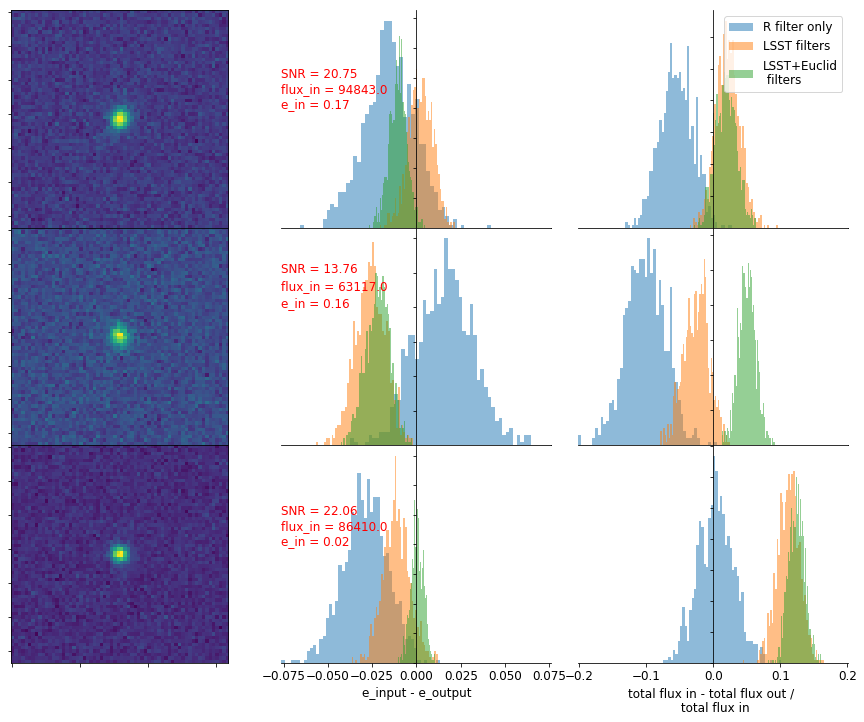

In [159]:
##### Plots configuration
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)


####### Limit for histograms

max_lim_e = np.max(np.concatenate((np.abs(res_out_r_e[0]- res_in_e[0]),
                            np.abs(res_out_r_e[1]- res_in_e[1]),
                            np.abs(res_out_r_e[2]- res_in_e[2]),
                            np.abs(res_out_lsst_e[0]- res_in_e[0]),
                            np.abs(res_out_lsst_e[1]- res_in_e[1]),
                            np.abs(res_out_lsst_e[2]- res_in_e[2]),
                            np.abs(res_out_lsst_euclid_e[0]- res_in_e[0]),
                            np.abs(res_out_lsst_euclid_e[1]- res_in_e[1]),
                            np.abs(res_out_lsst_euclid_e[2]- res_in_e[2]))), axis = 0)

max_lim_flux = np.max(np.concatenate((np.abs(flux_out_r[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_r[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_r[2]- flux_in[2])/flux_in[2],
                            np.abs(flux_out_lsst[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_lsst[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_lsst[2]- flux_in[2])/flux_in[2],
                            np.abs(flux_out_lsst_euclid[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_lsst_euclid[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_lsst_euclid[2]- flux_in[2])/flux_in[2])), axis = 0)

########## Galaxy 1

ax = axes[0,0]
_ = ax.imshow(denormed_gal[0][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[0,1]
_ = ax.hist(res_in_e[0]-res_out_r_e[0], bins = 50, label ='R filter only' , alpha = 0.5)
_ = ax.hist(res_in_e[0]-res_out_lsst_e[0], bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_in_e[0]-res_out_lsst_euclid_e[0], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[0], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[0], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[0], 2)), fontsize =12, color='r')
#ax.legend(loc='upper right')
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[0,2]
_ = ax.hist((flux_in[0]-flux_out_r[0])/flux_in[0], bins = 50, label ='R filter only' , alpha = 0.5)
_ = ax.hist((flux_in[0]-flux_out_lsst[0])/flux_in[0], bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist((flux_in[0]-flux_out_lsst_euclid[0])/flux_in[0], bins = 50, label ='LSST+Euclid\n filters' , alpha = 0.5)
ax.legend(loc='upper right')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])



########## Galaxy 2

ax = axes[1,0]
_ = ax.imshow(denormed_gal[1][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
_ = ax.hist(res_in_e[1]-res_out_r_e[1], bins = 50,  alpha = 0.5)
_ = ax.hist(res_in_e[1]-res_out_lsst_e[1], bins = 50,  alpha = 0.5)
_ = ax.hist(res_in_e[1]-res_out_lsst_euclid_e[1], bins = 50,  alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[1], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[1], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[1], 2)), fontsize =12, color='r')
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
_ = ax.hist((flux_in[1]-flux_out_r[1])/flux_in[1], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[1]-flux_out_lsst[1])/flux_in[1], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[1]-flux_out_lsst_euclid[1])/flux_in[1], bins = 50,  alpha = 0.5)
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])


########## Galaxy 3

ax = axes[2,0]
_ = ax.imshow(denormed_gal[2][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
_ = ax.hist(res_in_e[2]-res_out_r_e[2], bins = 50,  alpha = 0.5)
_ = ax.hist(res_in_e[2]-res_out_lsst_e[2], bins = 50, alpha = 0.5)
_ = ax.hist(res_in_e[2]-res_out_lsst_euclid_e[2], bins = 50, alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[2], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[2], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[2], 2)), fontsize =12, color='r')
ax.set_xlabel('e_input - e_output', fontsize = 12)
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.set_yticklabels([])

ax = axes[2,2]
_ = ax.hist((flux_in[2]-flux_out_r[2])/flux_in[2], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[2]-flux_out_lsst[2])/flux_in[2], bins = 50, alpha = 0.5)
_ = ax.hist((flux_in[2]-flux_out_lsst_euclid[2])/flux_in[2], bins = 50, alpha = 0.5)
ax.set_xlabel('total flux in - total flux out / \n total flux in')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.set_yticklabels([])

[]

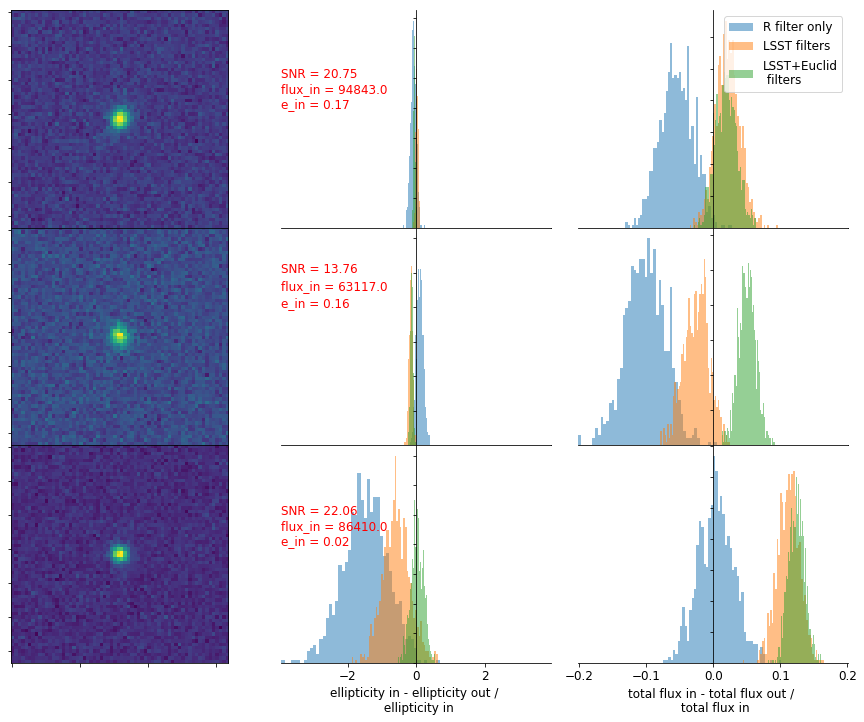

In [160]:
##### Plots configuration
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)


####### Limit for histograms

max_lim_e = np.max(np.concatenate((np.abs(res_out_r_e[0]- res_in_e[0])/res_in_e[0],
                            np.abs(res_out_r_e[1]- res_in_e[1])/res_in_e[1],
                            np.abs(res_out_r_e[2]- res_in_e[2])/res_in_e[2],
                            np.abs(res_out_lsst_e[0]- res_in_e[0])/res_in_e[0],
                            np.abs(res_out_lsst_e[1]- res_in_e[1])/res_in_e[1],
                            np.abs(res_out_lsst_e[2]- res_in_e[2])/res_in_e[2],
                            np.abs(res_out_lsst_euclid_e[0]- res_in_e[0])/res_in_e[0],
                            np.abs(res_out_lsst_euclid_e[1]- res_in_e[1])/res_in_e[1],
                            np.abs(res_out_lsst_euclid_e[2]- res_in_e[2])/res_in_e[2])), axis = 0)

max_lim_flux = np.max(np.concatenate((np.abs(flux_out_r[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_r[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_r[2]- flux_in[2])/flux_in[2],
                            np.abs(flux_out_lsst[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_lsst[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_lsst[2]- flux_in[2])/flux_in[2],
                            np.abs(flux_out_lsst_euclid[0]- flux_in[0])/flux_in[0],
                            np.abs(flux_out_lsst_euclid[1]- flux_in[1])/flux_in[1],
                            np.abs(flux_out_lsst_euclid[2]- flux_in[2])/flux_in[2])), axis = 0)

########## Galaxy 1

ax = axes[0,0]
_ = ax.imshow(denormed_gal[0][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[0,1]
_ = ax.hist((res_in_e[0]-res_out_r_e[0])/res_in_e[0], bins = 50, label ='R filter only' , alpha = 0.5)
_ = ax.hist((res_in_e[0]-res_out_lsst_e[0])/res_in_e[0], bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist((res_in_e[0]-res_out_lsst_euclid_e[0])/res_in_e[0], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[0], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[0], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[0], 2)), fontsize =12, color='r')
#ax.legend(loc='upper right')
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[0,2]
_ = ax.hist((flux_in[0]-flux_out_r[0])/flux_in[0], bins = 50, label ='R filter only' , alpha = 0.5)
_ = ax.hist((flux_in[0]-flux_out_lsst[0])/flux_in[0], bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist((flux_in[0]-flux_out_lsst_euclid[0])/flux_in[0], bins = 50, label ='LSST+Euclid\n filters' , alpha = 0.5)
ax.legend(loc='upper right')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])



########## Galaxy 2

ax = axes[1,0]
_ = ax.imshow(denormed_gal[1][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
_ = ax.hist((res_in_e[1]-res_out_r_e[1])/res_in_e[1], bins = 50,  alpha = 0.5)
_ = ax.hist((res_in_e[1]-res_out_lsst_e[1])/res_in_e[1], bins = 50,  alpha = 0.5)
_ = ax.hist((res_in_e[1]-res_out_lsst_euclid_e[1])/res_in_e[1], bins = 50,  alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[1], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[1], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[1], 2)), fontsize =12, color='r')
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
_ = ax.hist((flux_in[1]-flux_out_r[1])/flux_in[1], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[1]-flux_out_lsst[1])/flux_in[1], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[1]-flux_out_lsst_euclid[1])/flux_in[1], bins = 50,  alpha = 0.5)
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_yticklabels([])
ax.set_xticklabels([])


########## Galaxy 3

ax = axes[2,0]
_ = ax.imshow(denormed_gal[2][:,:,6])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
_ = ax.hist((res_in_e[2]-res_out_r_e[2])/res_in_e[2], bins = 50,  alpha = 0.5)
_ = ax.hist((res_in_e[2]-res_out_lsst_e[2])/res_in_e[2], bins = 50, alpha = 0.5)
_ = ax.hist((res_in_e[2]-res_out_lsst_euclid_e[2])/res_in_e[2], bins = 50, alpha = 0.5)
ax.text(-max_lim_e, 50, 'SNR = '+str(round(SNR[2], 2)), fontsize =12, color='r')
ax.text(-max_lim_e, 45, 'flux_in = '+str(round(flux_in[2], 0)), fontsize =12, color='r')
ax.text(-max_lim_e, 40, 'e_in = '+str(round(res_in_e[2], 2)), fontsize =12, color='r')
ax.set_xlabel('ellipticity in - ellipticity out / \n ellipticity in', fontsize = 12)
ax.set_xlim(-max_lim_e, max_lim_e)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.set_yticklabels([])

ax = axes[2,2]
_ = ax.hist((flux_in[2]-flux_out_r[2])/flux_in[2], bins = 50,  alpha = 0.5)
_ = ax.hist((flux_in[2]-flux_out_lsst[2])/flux_in[2], bins = 50, alpha = 0.5)
_ = ax.hist((flux_in[2]-flux_out_lsst_euclid[2])/flux_in[2], bins = 50, alpha = 0.5)
ax.set_xlabel('total flux in - total flux out / \n total flux in')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('black')
ax.set_yticklabels([])

## Test: High SNR / High ellipticity ?

median of input SNR for LSST R filter VAE: 7.082885922003024
mean of input SNR for LSST R filter VAE: 16.922172524926058


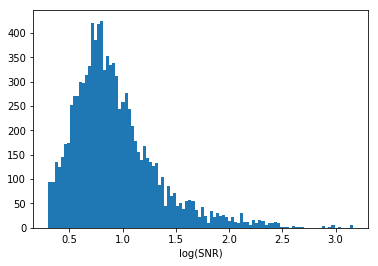

In [20]:
_ = plt.hist(np.log10(SNR_r[:]), bins = 100)
plt.xlabel('log(SNR)')
print('median of input SNR for LSST R filter VAE: '+str(np.median(SNR_r[:])))
print('mean of input SNR for LSST R filter VAE: '+str(np.mean(SNR_r[:])))

median of input SNR for LSST R filter VAE: -0.00047536805504933
mean of input SNR for LSST R filter VAE: 0.0007880204681250688


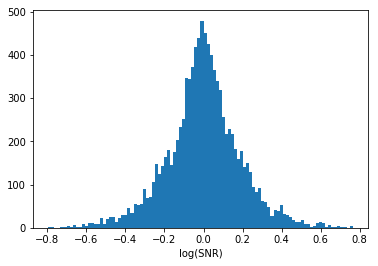

In [21]:
_ = plt.hist(ellipticities_r_band[:,0,0], bins = 100)
plt.xlabel('log(SNR)')
print('median of input SNR for LSST R filter VAE: '+str(np.median(ellipticities_r_band[:,0,0])))
print('mean of input SNR for LSST R filter VAE: '+str(np.mean(ellipticities_r_band[:,0,0])))

In [23]:
SNR_below_10_r = np.where(SNR_r<10)

In [24]:
e_r_mod = np.delete(ellipticities_r_band[:,0,0], SNR_below_10_r[0])

median of input SNR for LSST R filter VAE for SNR above 10: 0.0022345376200973988
mean of input SNR for LSST R filter VAE for SNR above 10: 0.0003650838919746936


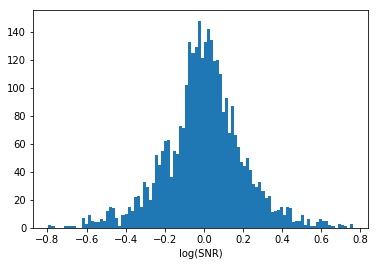

In [26]:
_ = plt.hist(e_r_mod, bins = 100)
plt.xlabel('log(SNR)')
print('median of input SNR for LSST R filter VAE for SNR above 10: '+str(np.median(e_r_mod)))
print('mean of input SNR for LSST R filter VAE for SNR above 10: '+str(np.mean(e_r_mod)))

In [28]:
SNR_above_10_r = np.where(SNR_r>10)

In [29]:
e_r_mod_mod = np.delete(ellipticities_r_band[:,0,0], SNR_above_10_r[0])

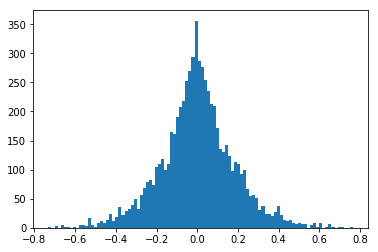

In [30]:
_ = plt.hist(e_r_mod_mod, bins = 100)

## Comparison with VAE R filter only

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


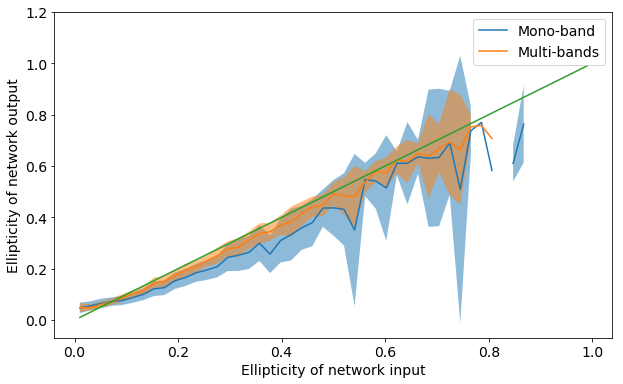

In [74]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


plt.figure(figsize=(10,6))

bins = np.linspace(0, 1, 50)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(e_beta_r[:,0,0],e_beta_r[:,1,0],bins)
mean_multi, var_multi = mean_var(e_beta_LSST[:,0,0],e_beta_LSST[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'Mono-band')
plt.plot(mid, mean_multi, label = 'Multi-bands')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Ellipticity of network output')
plt.xlabel('Ellipticity of network input')
plt.legend()

plt.plot(mid, mid)

In [75]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


plt.figure(figsize=(10,6))

bins = np.linspace(0, 1, 50)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(e_beta_r_mod[:,0,0],e_beta_r_mod[:,1,0],bins)
mean_multi, var_multi = mean_var(e_beta_LSST_mod[:,0,0],e_beta_LSST_mod[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'Mono-band')
plt.plot(mid, mean_multi, label = 'Multi-bands')
plt.fill_between(mid, mean_simple - 30*var_simple**0.5, mean_simple + 30*var_simple**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 30*var_multi**0.5, mean_multi + 30*var_multi**0.5, alpha=0.5)
plt.ylabel('Ellipticity of network output')
plt.xlabel('Ellipticity of network input')
plt.legend()

plt.plot(mid, mid)

NameError: name 'e_beta_r_mod' is not defined

<Figure size 720x432 with 0 Axes>

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


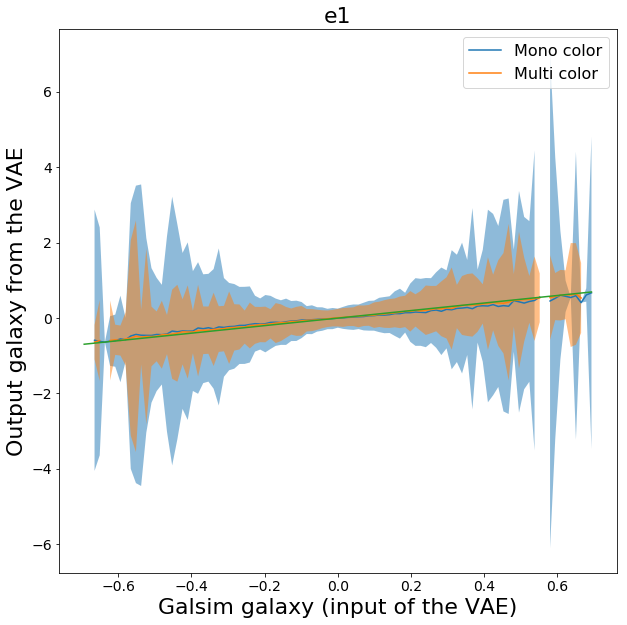

In [76]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_r_band[:,0,0],ellipticities_r_band[:,1,0],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST[:,0,0],ellipticities_LSST[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'Mono color')
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e1', fontsize = 22)
plt.legend(fontsize = 16)

plt.plot(mid, mid)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


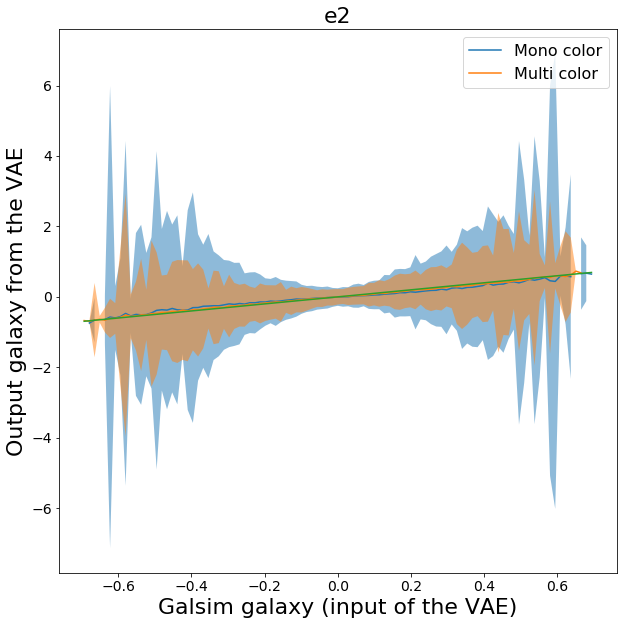

In [77]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_r_band[:,0,1],ellipticities_r_band[:,1,1],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST[:,0,1],ellipticities_LSST[:,1,1],bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e2', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

#### LSST compared to LSST+EUCLID

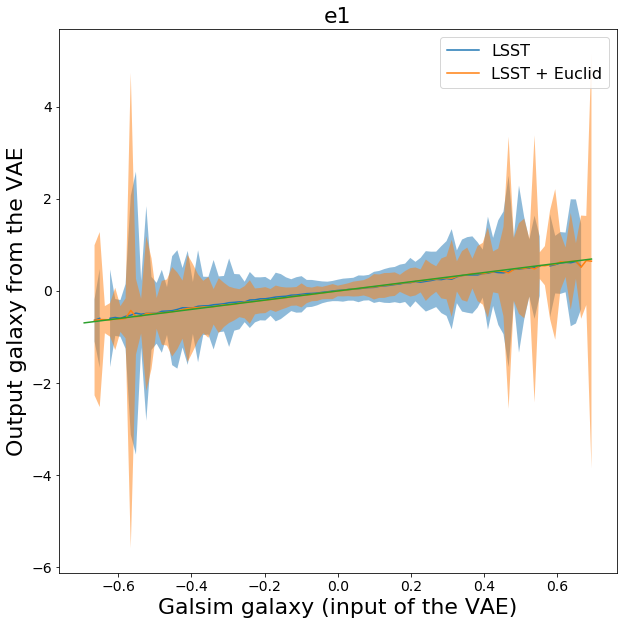

In [78]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_LSST[:,0,0],ellipticities_LSST[:,1,0],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST_euclid[:,0,0],ellipticities_LSST_euclid[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST + Euclid')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e1', fontsize = 22)
plt.legend(fontsize = 16)

#plt.spines['bottom'].set_color('w')
#plt.spines['right'].set_color('w')
#plt.spines['left'].set_color('w')
#plt.spines['top'].set_color('w')
#plt.xaxis.label.set_color('w')
#plt.tick_params(axis='x', colors='w')
#plt.tick_params(axis='y', colors='w')

plt.plot(mid, mid)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


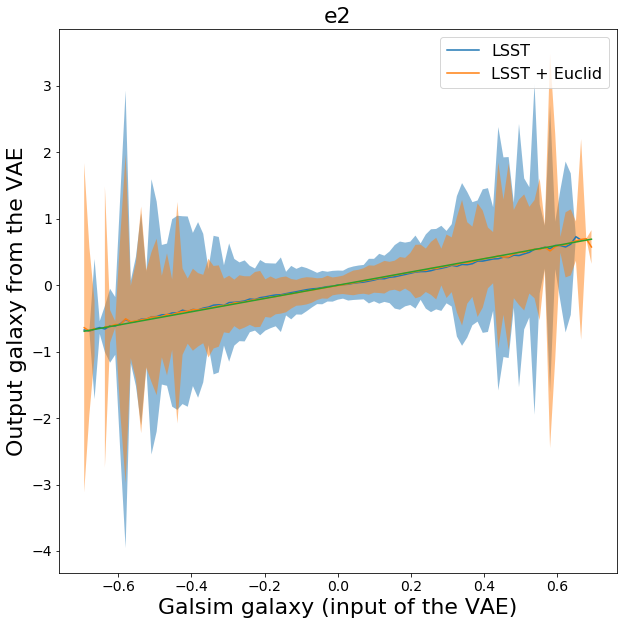

In [79]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_LSST[:,0,1],ellipticities_LSST[:,1,1],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST_euclid[:,0,1],ellipticities_LSST_euclid[:,1,1],bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST + Euclid')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e2', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

## Flux comparison

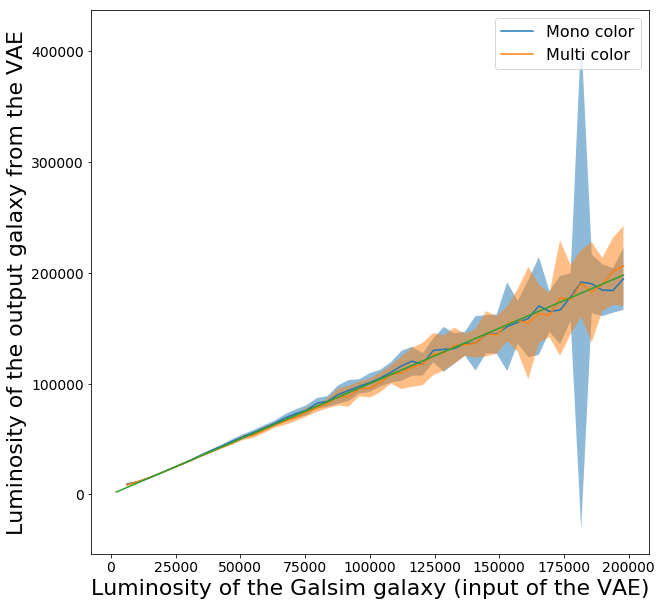

In [83]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 200000, 50)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple_r,lum_out_simple_r,bins)
mean_multi, var_multi = mean_var(lum_in_simple_lsst,lum_out_simple_lsst,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


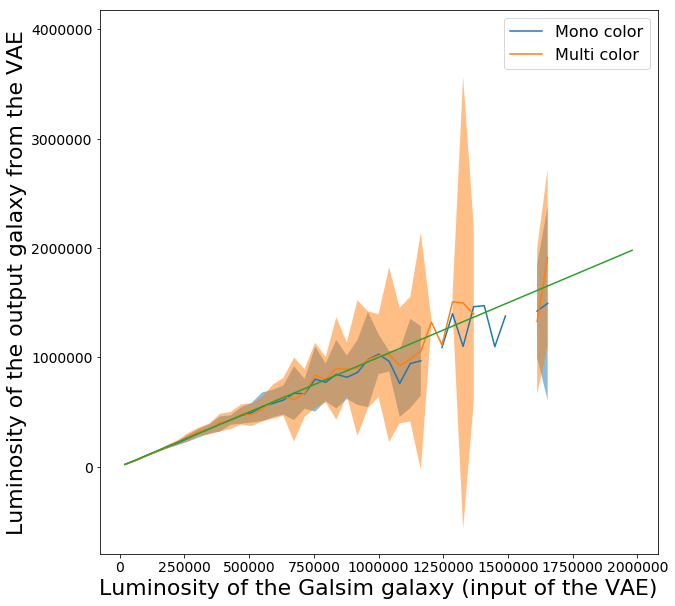

In [81]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 2000000, 50)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple_r,lum_out_simple_r,bins)
mean_multi, var_multi = mean_var(lum_in_simple_lsst,lum_out_simple_lsst,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

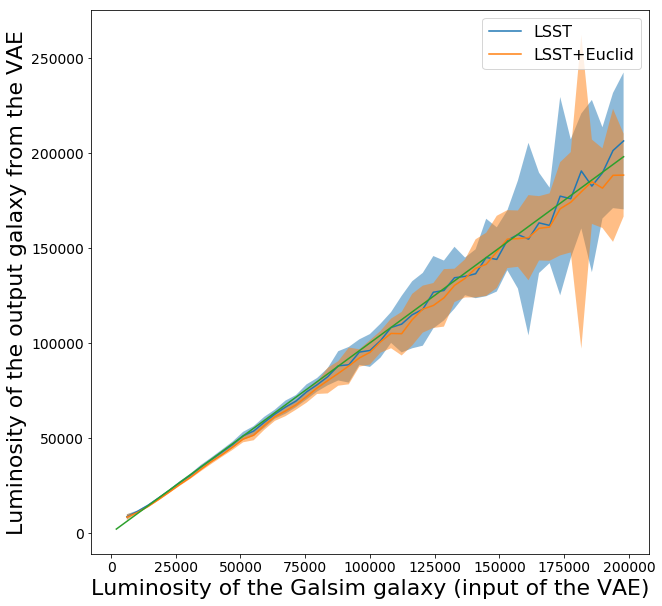

In [84]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 200000, 50)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple_lsst,lum_out_simple_lsst,bins)
mean_multi, var_multi = mean_var(lum_in_simple_lsst_euclid,lum_out_simple_lsst_euclid,bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST+Euclid')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


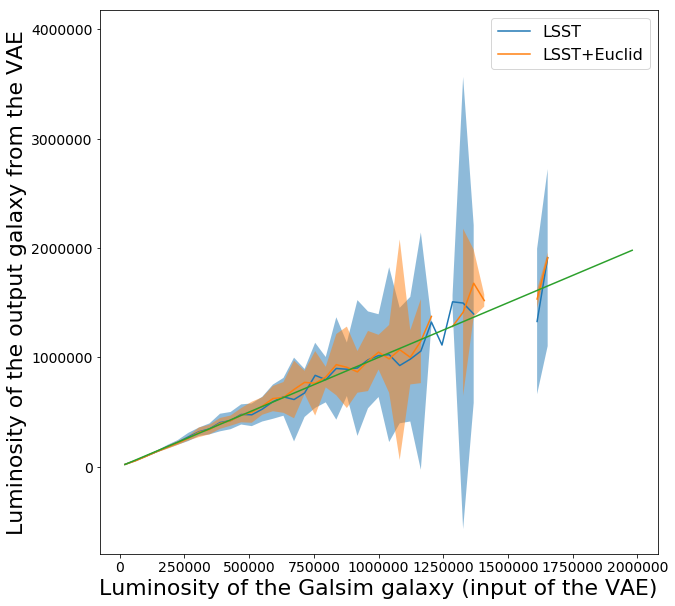

In [85]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 2000000, 50)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple_lsst,lum_out_simple_lsst,bins)
mean_multi, var_multi = mean_var(lum_in_simple_lsst_euclid,lum_out_simple_lsst_euclid,bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST+Euclid')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)